# Long Book

## Import libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import os
import random

import warnings
warnings.filterwarnings('ignore')

# Import dendrogram, linkage to create dendrogram
from scipy.cluster.hierarchy import dendrogram, linkage

# Import AgglomerativeClustering
from sklearn.cluster import AgglomerativeClustering

# Import pyfolio to backtest the strategy
import pyfolio as pf

# Import yfinance library
import yfinance as yf

# Import library for technical analysis
import talib as ta

# Import libraries for machine learning
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score
from sklearn.utils import class_weight, compute_class_weight
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, ParameterGrid, RandomizedSearchCV, HalvingRandomSearchCV

# Import library to save selected models
import pickle

## Import data

In [2]:
# Import data from Excel file
data = pd.read_excel('/Users/lucadonghi/Desktop/Python Works/LongShort Strategy/Short list.xlsx', sheet_name='Dataset 2018')
data.head()

,ISIN,Name,Weight,GICS Sector,Gross Margin,Rev. Gwth.,ROIC,D/C TTM,Mkt Cap (mln USD)
0,US02079K3059,Alphabet Inc A,0.60796,Communication Services,56.48,19.77,0.1726,2.2931,723558.708460
1,NL0009805522,Yandex NV,0.53159,Communication Services,71.88,8.87,0.2625,17.7733,8881.284080
2,US64110W1027,NetEase Inc ADR,0.51224,Communication Services,53.43,40.96,0.1024,NaN,30118.118480
3,US68555P1003,ORBCOMM Inc,0.50763,Communication Services,46.90,30.06,-0.0247,48.7579,634.693431
4,US30303M1027,Facebook Inc A,0.46326,Communication Services,83.25,47.97,0.2702,NaN,374130.860000


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371 entries, 0 to 370
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ISIN               371 non-null    object 
 1   Name               371 non-null    object 
 2   Weight             371 non-null    float64
 3   GICS Sector        335 non-null    object 
 4   Gross Margin       301 non-null    float64
 5   Rev. Gwth.         305 non-null    float64
 6   ROIC               314 non-null    float64
 7   D/C TTM            258 non-null    float64
 8   Mkt Cap (mln USD)  286 non-null    float64
dtypes: float64(6), object(3)
memory usage: 26.2+ KB


In [4]:
# Covert data type to float
data[['Gross Margin', 'Rev. Gwth.', 'ROIC', 'D/C TTM']] = data[['Gross Margin', 'Rev. Gwth.', 'ROIC', 'D/C TTM']].astype(float)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371 entries, 0 to 370
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ISIN               371 non-null    object 
 1   Name               371 non-null    object 
 2   Weight             371 non-null    float64
 3   GICS Sector        335 non-null    object 
 4   Gross Margin       301 non-null    float64
 5   Rev. Gwth.         305 non-null    float64
 6   ROIC               314 non-null    float64
 7   D/C TTM            258 non-null    float64
 8   Mkt Cap (mln USD)  286 non-null    float64
dtypes: float64(6), object(3)
memory usage: 26.2+ KB


In [5]:
# Drop useless columns
data_new = data.drop(['Weight', 'D/C TTM'], axis=1)
data_new.head()

,ISIN,Name,GICS Sector,Gross Margin,Rev. Gwth.,ROIC,Mkt Cap (mln USD)
0,US02079K3059,Alphabet Inc A,Communication Services,56.48,19.77,0.1726,723558.708460
1,NL0009805522,Yandex NV,Communication Services,71.88,8.87,0.2625,8881.284080
2,US64110W1027,NetEase Inc ADR,Communication Services,53.43,40.96,0.1024,30118.118480
3,US68555P1003,ORBCOMM Inc,Communication Services,46.90,30.06,-0.0247,634.693431
4,US30303M1027,Facebook Inc A,Communication Services,83.25,47.97,0.2702,374130.860000


In [6]:
# Drop rows where "GICS Sector" column has NaN values
df_cleaned = data_new.dropna(subset=['GICS Sector'])
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 335 entries, 0 to 370
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ISIN               335 non-null    object 
 1   Name               335 non-null    object 
 2   GICS Sector        335 non-null    object 
 3   Gross Margin       301 non-null    float64
 4   Rev. Gwth.         305 non-null    float64
 5   ROIC               314 non-null    float64
 6   Mkt Cap (mln USD)  286 non-null    float64
dtypes: float64(4), object(3)
memory usage: 20.9+ KB


## Screening stocks

In [7]:
# Define a function to apply Min-Max scaling within each sector
# Define a function to apply Min-Max scaling within each sector and treat NaN as 0
def min_max_scaling(group):
    group = group.fillna(0)  # Fill NaN values with 0
    group['Gross Margin MinMax'] = (group['Gross Margin'] - group['Gross Margin'].min()) / (group['Gross Margin'].max() - group['Gross Margin'].min())
    group['Rev. Gwth. MinMax'] = (group['Rev. Gwth.'] - group['Rev. Gwth.'].min()) / (group['Rev. Gwth.'].max() - group['Rev. Gwth.'].min())
    group['ROIC MinMax'] = (group['ROIC'] - group['ROIC'].min()) / (group['ROIC'].max() - group['ROIC'].min())
    return group

# Apply the scaling function within each sector group
df_cleaned = df_cleaned.groupby('GICS Sector').apply(min_max_scaling)

In [8]:
df_cleaned.head()

,ISIN,Name,GICS Sector,Gross Margin,Rev. Gwth.,ROIC,Mkt Cap (mln USD),Gross Margin MinMax,Rev. Gwth. MinMax,ROIC MinMax
0,US02079K3059,Alphabet Inc A,Communication Services,56.48,19.77,0.1726,723558.708460,0.601747,0.436675,0.812321
1,NL0009805522,Yandex NV,Communication Services,71.88,8.87,0.2625,8881.284080,0.765821,0.265399,0.924207
2,US64110W1027,NetEase Inc ADR,Communication Services,53.43,40.96,0.1024,30118.118480,0.569252,0.769642,0.724953
3,US68555P1003,ORBCOMM Inc,Communication Services,46.90,30.06,-0.0247,634.693431,0.499680,0.598366,0.566770
4,US30303M1027,Facebook Inc A,Communication Services,83.25,47.97,0.2702,374130.860000,0.886959,0.879793,0.933790


In [9]:
# Calculate Score for each stock 
df_cleaned['Score'] = df_cleaned['Gross Margin MinMax'] + df_cleaned['Rev. Gwth. MinMax'] + df_cleaned['ROIC MinMax']
df_cleaned.head()

,ISIN,Name,GICS Sector,Gross Margin,Rev. Gwth.,ROIC,Mkt Cap (mln USD),Gross Margin MinMax,Rev. Gwth. MinMax,ROIC MinMax,Score
0,US02079K3059,Alphabet Inc A,Communication Services,56.48,19.77,0.1726,723558.708460,0.601747,0.436675,0.812321,1.850743
1,NL0009805522,Yandex NV,Communication Services,71.88,8.87,0.2625,8881.284080,0.765821,0.265399,0.924207,1.955427
2,US64110W1027,NetEase Inc ADR,Communication Services,53.43,40.96,0.1024,30118.118480,0.569252,0.769642,0.724953,2.063847
3,US68555P1003,ORBCOMM Inc,Communication Services,46.90,30.06,-0.0247,634.693431,0.499680,0.598366,0.566770,1.664817
4,US30303M1027,Facebook Inc A,Communication Services,83.25,47.97,0.2702,374130.860000,0.886959,0.879793,0.933790,2.700542


In [10]:
# Define a function to assign quartiles within each sector based on the "Score"
def assign_quartiles(group):
    group['Quartile'] = pd.qcut(group['Score'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
    return group

# Apply the quartile assignment function within each sector group
df_cleaned = df_cleaned.groupby('GICS Sector').apply(assign_quartiles)

In [11]:
df_cleaned.head()

,ISIN,Name,GICS Sector,Gross Margin,Rev. Gwth.,ROIC,Mkt Cap (mln USD),Gross Margin MinMax,Rev. Gwth. MinMax,ROIC MinMax,Score,Quartile
0,US02079K3059,Alphabet Inc A,Communication Services,56.48,19.77,0.1726,723558.708460,0.601747,0.436675,0.812321,1.850743,Q3
1,NL0009805522,Yandex NV,Communication Services,71.88,8.87,0.2625,8881.284080,0.765821,0.265399,0.924207,1.955427,Q3
2,US64110W1027,NetEase Inc ADR,Communication Services,53.43,40.96,0.1024,30118.118480,0.569252,0.769642,0.724953,2.063847,Q4
3,US68555P1003,ORBCOMM Inc,Communication Services,46.90,30.06,-0.0247,634.693431,0.499680,0.598366,0.566770,1.664817,Q2
4,US30303M1027,Facebook Inc A,Communication Services,83.25,47.97,0.2702,374130.860000,0.886959,0.879793,0.933790,2.700542,Q4


In [12]:
# Keep only stocks in top quartile
short_list = df_cleaned[df_cleaned['Quartile'] == 'Q4']
short_list.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85 entries, 2 to 368
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   ISIN                 85 non-null     object  
 1   Name                 85 non-null     object  
 2   GICS Sector          85 non-null     object  
 3   Gross Margin         85 non-null     float64 
 4   Rev. Gwth.           85 non-null     float64 
 5   ROIC                 85 non-null     float64 
 6   Mkt Cap (mln USD)    85 non-null     float64 
 7   Gross Margin MinMax  85 non-null     float64 
 8   Rev. Gwth. MinMax    85 non-null     float64 
 9   ROIC MinMax          85 non-null     float64 
 10  Score                85 non-null     float64 
 11  Quartile             85 non-null     category
dtypes: category(1), float64(8), object(3)
memory usage: 8.3+ KB


In [13]:
short_list.head()

,ISIN,Name,GICS Sector,Gross Margin,Rev. Gwth.,ROIC,Mkt Cap (mln USD),Gross Margin MinMax,Rev. Gwth. MinMax,ROIC MinMax,Score,Quartile
2,US64110W1027,NetEase Inc ADR,Communication Services,53.43,40.96,0.1024,30118.11848,0.569252,0.769642,0.724953,2.063847,Q4
4,US30303M1027,Facebook Inc A,Communication Services,83.25,47.97,0.2702,374130.86000,0.886959,0.879793,0.933790,2.700542,Q4
11,US9485961018,Weibo Corp ADR Class A,Communication Services,83.84,55.62,0.2276,13137.25810,0.893245,1.000000,0.880772,2.774017,Q4
13,US57665R1068,Match Group Inc,Communication Services,76.30,16.59,0.3234,0.00000,0.812913,0.386706,1.000000,2.199619,Q4
14,US90184L1026,Twitter Inc,Communication Services,68.28,35.55,0.1492,21964.74618,0.727466,0.684632,0.783199,2.195297,Q4


In [14]:
# Filter stocks by removing those with a market cap smaller than USD 2 bln
short_list_new = short_list[short_list['Mkt Cap (mln USD)'] >= 2000]

In [15]:
short_list_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60 entries, 2 to 368
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   ISIN                 60 non-null     object  
 1   Name                 60 non-null     object  
 2   GICS Sector          60 non-null     object  
 3   Gross Margin         60 non-null     float64 
 4   Rev. Gwth.           60 non-null     float64 
 5   ROIC                 60 non-null     float64 
 6   Mkt Cap (mln USD)    60 non-null     float64 
 7   Gross Margin MinMax  60 non-null     float64 
 8   Rev. Gwth. MinMax    60 non-null     float64 
 9   ROIC MinMax          60 non-null     float64 
 10  Score                60 non-null     float64 
 11  Quartile             60 non-null     category
dtypes: category(1), float64(8), object(3)
memory usage: 5.9+ KB


In [16]:
# Count the number of stocks per GICS Sector
sector_counts = short_list_new['GICS Sector'].value_counts()

print(sector_counts)

Information Technology    17
Health Care               13
Industrials               10
Consumer Discretionary     6
Communication Services     5
Financials                 4
Materials                  2
Utilities                  2
Energy                     1
Name: GICS Sector, dtype: int64


## Import short-listed stock prices

In [17]:
prices = pd.read_excel('/Users/lucadonghi/Desktop/Python Works/LongShort Strategy/Short list.xlsx', sheet_name='Prices', header=1, index_col=0)
prices.head()

,NetEase Inc ADR,Facebook Inc A,Weibo Corp ADR Class A,Twitter Inc,Yelp Inc Class A,Tesla Inc,Garmin Ltd,ADT Inc,iRobot Corp,MercadoLibre Inc,...,Palo Alto Networks Inc,Analog Devices Inc,Check Point Software Technologies Ltd,F5 Networks Inc,Texas Instruments Inc,Fortinet Inc,Ingevity Corp,Ball Corp,NextEra Energy Inc,Algonquin Power & Utilities Corp
2018-12-31,47.074,131.09,58.43,28.6599,34.99,22.18667,63.32,6.01,83.74,292.85,...,62.78333,85.83,102.65,162.03,94.50,14.086,83.69,45.98,43.4550,10.052716
2019-01-01,47.074,131.09,58.43,28.6599,34.99,22.18667,63.32,6.01,83.74,292.85,...,62.78333,85.83,102.65,162.03,94.50,14.086,83.69,45.98,43.4550,10.052716
2019-01-02,45.948,135.68,58.94,28.8529,34.57,20.67467,62.52,6.41,79.24,298.01,...,61.07000,85.92,103.50,161.18,94.45,13.936,84.02,44.67,42.4575,9.944142
2019-01-03,44.180,131.74,55.97,28.2527,33.64,20.02400,61.39,6.32,78.28,296.59,...,59.90000,80.73,102.35,154.31,88.88,13.514,79.69,44.26,42.3525,10.019981
2019-01-04,45.950,137.95,61.23,29.8000,34.56,21.17933,63.72,6.67,83.32,315.33,...,61.46333,82.69,105.35,159.79,92.90,13.382,83.99,45.59,43.1325,10.118736


In [18]:
rets = prices.pct_change().fillna(0)
rets.head()

,NetEase Inc ADR,Facebook Inc A,Weibo Corp ADR Class A,Twitter Inc,Yelp Inc Class A,Tesla Inc,Garmin Ltd,ADT Inc,iRobot Corp,MercadoLibre Inc,...,Palo Alto Networks Inc,Analog Devices Inc,Check Point Software Technologies Ltd,F5 Networks Inc,Texas Instruments Inc,Fortinet Inc,Ingevity Corp,Ball Corp,NextEra Energy Inc,Algonquin Power & Utilities Corp
2018-12-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
2019-01-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.221245e-15
2019-01-02,-0.023920,0.035014,0.008728,0.006734,-0.012003,-0.068149,-0.012634,0.066556,-0.053738,0.017620,...,-0.027290,0.001049,0.008281,-0.005246,-0.000529,-0.010649,0.003943,-0.028491,-0.022955,-1.080047e-02
2019-01-03,-0.038478,-0.029039,-0.050390,-0.020802,-0.026902,-0.031472,-0.018074,-0.014041,-0.012115,-0.004765,...,-0.019158,-0.060405,-0.011111,-0.042623,-0.058973,-0.030281,-0.051535,-0.009178,-0.002473,7.626446e-03
2019-01-04,0.040063,0.047138,0.093979,0.054766,0.027348,0.057697,0.037954,0.055380,0.064384,0.063185,...,0.026099,0.024278,0.029311,0.035513,0.045230,-0.009768,0.053959,0.030050,0.018417,9.855878e-03


In [19]:
rets.tail()

,NetEase Inc ADR,Facebook Inc A,Weibo Corp ADR Class A,Twitter Inc,Yelp Inc Class A,Tesla Inc,Garmin Ltd,ADT Inc,iRobot Corp,MercadoLibre Inc,...,Palo Alto Networks Inc,Analog Devices Inc,Check Point Software Technologies Ltd,F5 Networks Inc,Texas Instruments Inc,Fortinet Inc,Ingevity Corp,Ball Corp,NextEra Energy Inc,Algonquin Power & Utilities Corp
2024-08-26,0.004995,-0.013030,-0.009009,0.0,-0.005721,-0.032271,-0.001279,-0.010681,-0.013183,0.002195,...,-0.010349,-0.012172,-0.004204,0.002010,-0.007766,0.006022,0.006764,-0.003408,0.012302,0.009205
2024-08-27,0.012608,-0.003876,-0.015584,0.0,-0.001151,-0.018761,0.006239,0.005398,-0.041985,0.015718,...,0.008844,0.027614,-0.006913,0.001504,0.011717,0.010508,-0.002584,-0.004352,-0.012773,-0.012562
2024-08-28,-0.037831,-0.004469,-0.031662,0.0,-0.009505,-0.016538,-0.003155,-0.012081,-0.021248,-0.020155,...,0.000714,-0.020143,0.007279,-0.004106,-0.014002,-0.004739,0.002850,-0.008898,-0.002512,-0.009796
2024-08-29,0.001991,0.002786,0.016349,0.0,0.015121,0.002576,0.003165,0.000000,0.008820,0.010335,...,0.022172,0.016375,0.010761,0.016341,0.016126,0.008729,0.019633,-0.017326,0.007808,0.012520
2024-08-30,-0.001118,0.005963,0.002681,0.0,0.000573,0.037958,0.014614,-0.009511,-0.015467,0.022755,...,0.012590,0.017108,0.004645,0.004997,0.015396,0.005769,0.001520,0.022760,0.005998,0.010915


## Find weights by applying HRP

In [20]:
stock_returns_hrp = prices.resample("1M", label='left').last().pct_change().dropna()

In [21]:
stock_returns_hrp.head()

,NetEase Inc ADR,Facebook Inc A,Weibo Corp ADR Class A,Twitter Inc,Yelp Inc Class A,Tesla Inc,Garmin Ltd,ADT Inc,iRobot Corp,MercadoLibre Inc,...,Palo Alto Networks Inc,Analog Devices Inc,Check Point Software Technologies Ltd,F5 Networks Inc,Texas Instruments Inc,Fortinet Inc,Ingevity Corp,Ball Corp,NextEra Energy Inc,Algonquin Power & Utilities Corp
2018-12-31,0.070357,0.271569,0.038165,0.168357,0.040869,-0.077464,0.092546,0.201331,0.072247,0.242957,...,0.140536,0.151812,0.090307,-0.006665,0.065397,0.087179,0.124029,0.137016,0.029686,0.099057
2019-01-31,-0.113960,-0.031436,0.191065,-0.086158,0.023064,0.041886,0.213790,0.108033,0.392805,0.260412,...,0.146402,0.081934,0.092745,0.044672,0.050656,0.133473,0.224833,0.047819,0.048832,0.003376
2019-02-28,0.081668,0.032456,-0.142007,0.078758,-0.074074,-0.125109,0.028343,-0.201250,-0.058932,0.106672,...,-0.013765,-0.015800,0.034260,-0.066671,0.002742,-0.032492,-0.083406,0.056225,0.029832,0.014850
2019-03-31,0.178422,0.160238,0.105017,0.211754,0.161159,-0.147109,-0.007064,0.031299,-0.120231,-0.046462,...,0.024498,0.104208,-0.045300,-0.000191,0.110870,0.112540,0.089007,0.035949,0.005794,0.010303
2019-04-30,-0.126243,-0.082368,-0.393869,-0.084375,-0.232901,-0.224266,-0.108001,-0.112291,-0.158683,0.178419,...,-0.195676,-0.168789,-0.086784,-0.158190,-0.114742,-0.224149,-0.237458,0.024191,0.019389,0.026281


In [22]:
# Split the stock_returns dataframe
returns_till_2020 = stock_returns_hrp[:'2020']

In [23]:
# Take a transpose of returns_till_2020
returns_till_2020_transpose = stock_returns_hrp[:'2020'].T

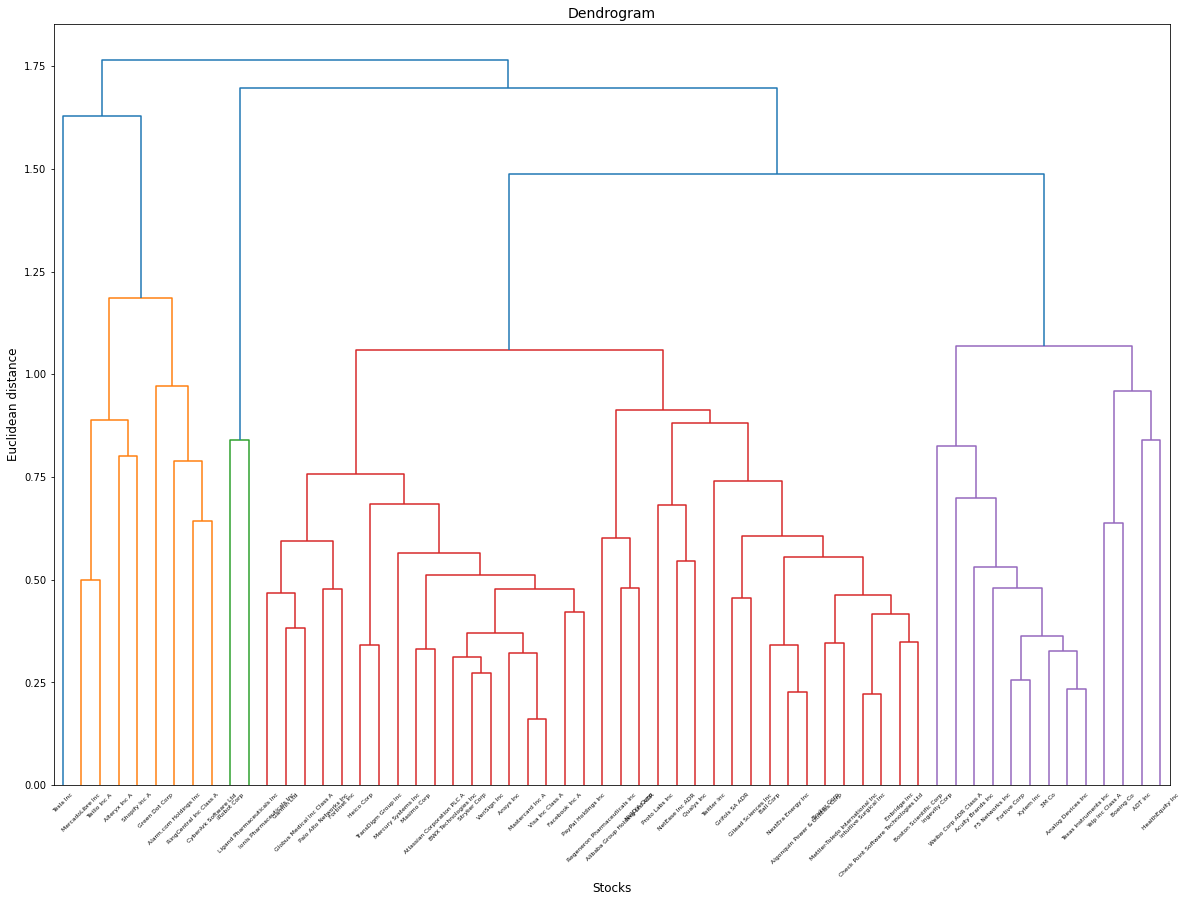

In [24]:
# Define the size of the graph
plt.figure(figsize=(20, 14))

# Title of the chart
plt.title('Dendrogram', fontsize=14)

# Create linkage matrix
linkage_matrix = linkage(returns_till_2020_transpose, method='ward')

# Create dendrogram
dendrogram(linkage_matrix, labels=returns_till_2020_transpose.index)

# Define labels
plt.xlabel("Stocks", fontsize=12)
plt.ylabel('Euclidean distance', fontsize=12)
plt.xticks(rotation=45)
plt.show()

In [25]:
# Step 1: Define an agglomerative clustering model
model = AgglomerativeClustering(n_clusters=2, linkage='ward')

# Step 2: Call fit_predict_method on scaled training data. This labels the stocks as 0 and 1
clusters = model.fit_predict(returns_till_2020_transpose)

# Step 3: Get tickers of cluster_0 and cluster_1 using labels 0 and 1
cluster_0 = returns_till_2020_transpose.loc[clusters == 0, :].index

cluster_1 = returns_till_2020_transpose.loc[clusters == 1, :].index

# Cluster_0
print(f'The stocks in cluster_0 are: {cluster_0.to_list()}')

# Cluster_1
print(f'The stocks in cluster_1 are: {cluster_1.to_list()}')

The stocks in cluster_0 are: ['NetEase Inc ADR', 'Facebook Inc A', 'Weibo Corp ADR Class A', 'Twitter Inc', 'Yelp Inc Class A', 'Garmin Ltd', 'ADT Inc', 'iRobot Corp', 'Alibaba Group Holding Ltd ADR', 'Enbridge Inc', 'PayPal Holdings Inc', 'Mastercard Inc A', 'Visa Inc Class A', 'Bruker Corp', 'Masimo Corp', 'Boston Scientific Corp', 'Intuitive Surgical Inc', 'Stryker Corp', 'Globus Medical Inc Class A', 'Mettler-Toledo International Inc', 'Grifols SA ADR', 'Gilead Sciences Inc', 'Regeneron Pharmaceuticals Inc', 'Ionis Pharmaceuticals Inc', 'Ligand Pharmaceuticals Inc', 'HealthEquity Inc', 'Proto Labs Inc', 'Boeing Co', 'Fortive Corp', '3M Co', 'Acuity Brands Inc', 'Heico Corp', 'TransDigm Group Inc', 'Mercury Systems Inc', 'Xylem Inc', 'BWX Technologies Inc', 'Atlassian Corporation PLC A', 'Ansys Inc', 'NVIDIA Corp', 'VeriSign Inc', 'Qualys Inc', 'Palo Alto Networks Inc', 'Analog Devices Inc', 'Check Point Software Technologies Ltd', 'F5 Networks Inc', 'Texas Instruments Inc', 'Fortin

In [26]:
# Function to calculate cluster volatility
def calculate_cluster_volatility(returns_data, tickers):

    # Calculating the standard deviation of stocks returns in the tickers list
    volatility = returns_data[tickers].std()

    # Calculate the weights of stocks using inverse volatility method
    weights = (1/volatility)/np.sum(1/volatility)

    # Multiply the returns data with weights calculated to get cluster returns
    cluster_returns = returns_data[tickers].dot(weights)

    # Calculate the volatility of cluster using standard deviation of cluster returns
    cluster_volatility = cluster_returns.std()

    return cluster_volatility

In [27]:
def hrp_weights(tickers, dataset, returns_data,weights_hrp_initital):

    if len(tickers) > 1:
        
        input_df = dataset.loc[tickers]

        # Hierarchical Clustering using Agglomerative Clustering

        # Step 1: Define an agglomerative clustering model
        model = AgglomerativeClustering(
            n_clusters=2, linkage='ward')
        
        # Step 2: Call fit_predict_method on dataset
        clusters = model.fit_predict(input_df)

        # Step 3: Get tickers of cluster_0 and cluster_1
        cluster_0 = input_df.loc[clusters == 0, :].index
        
        cluster_1 = input_df.loc[clusters == 1, :].index
        
        # Step-4: Calculate the volatility of cluster_0 and cluster_1 
        cluster_0_volatility  = calculate_cluster_volatility(returns_data[cluster_0], cluster_0)
        
        cluster_1_volatility  = calculate_cluster_volatility(returns_data[cluster_1], cluster_1)

        # Step-5: Calculate the weights of cluster_0 and cluster_1
        weight_cluster_0 = (1/cluster_0_volatility)/((1/cluster_0_volatility)+(1/cluster_1_volatility))
        
        weight_cluster_1 = (1/cluster_1_volatility)/((1/cluster_0_volatility)+(1/cluster_1_volatility))

        # Multiply the weights of tickers in 'weights_hrp_initial' dataframe with respective weights of cluster_0 and cluster_1
        weights_hrp_initital.loc[cluster_0, 'HRP'] *= weight_cluster_0
        
        weights_hrp_initital.loc[cluster_1, 'HRP'] *= weight_cluster_1

        # Run the clustering algorithm on the new clusters i.e. cluster_0 and cluster_1
        hrp_weights(cluster_0, dataset, returns_data, weights_hrp_initital)
        
        hrp_weights(cluster_1, dataset, returns_data, weights_hrp_initital)
        
        # Create weights_hrp dataframe
        weights_hrp = weights_hrp_initital

        # output weights_hrp
        return weights_hrp

In [28]:
# tickers
tickers = returns_till_2020_transpose.index.to_list()
weights_hrp_initital = pd.DataFrame(
        [1]*len(tickers), index=tickers, columns=['HRP'])
weights_hrp = hrp_weights(tickers,returns_till_2020_transpose, returns_till_2020, weights_hrp_initital)
round(weights_hrp.sort_values(by='HRP', ascending=False).head(10), 2)

,HRP
Tesla Inc,0.10
iRobot Corp,0.08
Ligand Pharmaceuticals Inc,0.07
Green Dot Corp,0.05
Ingevity Corp,0.04
Alarm.com Holdings Inc,0.03
Shopify Inc A,0.03
Weibo Corp ADR Class A,0.03
Regeneron Pharmaceuticals Inc,0.03
MercadoLibre Inc,0.03


In [29]:
weights = weights_hrp.sort_values(by='HRP', ascending=False)
weights.head(10)

,HRP
Tesla Inc,0.101374
iRobot Corp,0.079589
Ligand Pharmaceuticals Inc,0.072350
Green Dot Corp,0.050806
Ingevity Corp,0.035281
Alarm.com Holdings Inc,0.033578
Shopify Inc A,0.030983
Weibo Corp ADR Class A,0.030738
Regeneron Pharmaceuticals Inc,0.030500
MercadoLibre Inc,0.028272


In [30]:
weights.to_excel("/Users/lucadonghi/Desktop/Python Works/LongShort Strategy/long_book.xlsx")

## Redistribute weights

In [31]:
def sanity_check_and_allocation(data, weight_limit=0.10):
    """Check if weight redistribution is possible"""
    # Get the total number of stocks available
    num_stocks = len(data.index)

    # Calculate the minimum number of stocks needed for the given weight_limit
    num_stocks_needed = np.ceil(1 / weight_limit)    
   
    # Proceed if sufficient stocks are available
    if (num_stocks < num_stocks_needed):
        print(f"Weight redistribution is not possible. Add {num_stocks_needed - num_stocks} more stocks or reduce the weight limit to {round(1 / num_stocks, 2)}.")
    else:
        return redistribute_weights(data, weight_limit)

def redistribute_weights(data, weight_limit):
    """
    Code to redistribute weights between stocks.
    """
    # Sort the dataframe to get the stock with maximum weight
    data = data.sort_values(by=data.columns.to_list(), ascending=False)

    if data.iloc[0][0] <= weight_limit:
        data.rename(columns={"Original": "New"}, inplace=True)
        return data

    # If stock with maximum weights is greater than the weight_limit,
    # reassign weights
    if data.iloc[0][0] > weight_limit:
        # Calculate excess weight
        excess_weight = data.iloc[0][0] - weight_limit

        # Assign weight_limit to stock with excess weight
        data.iloc[0][0] = weight_limit

        # Calculate ratio of distribution of excess weight
        ratio = (data.iloc[1:] / data.iloc[1:].sum())

        # Distribute excess weight
        excess_weight_distribution = data.iloc[1:] + (ratio * excess_weight)

        # Update the weights
        data.iloc[1:, :] = excess_weight_distribution                
        return pd.concat([pd.DataFrame(data.iloc[0]).T,redistribute_weights(data.iloc[1:], weight_limit)])         
    return data

In [32]:
# Calculating the new weights after redistribution
new_weights = sanity_check_and_allocation(weights, weight_limit=0.03)

In [33]:
new_weights.mul(100).head(10)

,HRP
Tesla Inc,3.0
iRobot Corp,3.0
Ligand Pharmaceuticals Inc,3.0
Green Dot Corp,3.0
Ingevity Corp,3.0
Alarm.com Holdings Inc,3.0
Shopify Inc A,3.0
Weibo Corp ADR Class A,3.0
Regeneron Pharmaceuticals Inc,3.0
MercadoLibre Inc,3.0


In [34]:
new_weights.mul(100).tail(10)

,HRP
Check Point Software Technologies Ltd,0.291009
Boston Scientific Corp,0.278386
Ansys Inc,0.270546
Enbridge Inc,0.260147
Intuitive Surgical Inc,0.236280
BWX Technologies Inc,0.233888
VeriSign Inc,0.164671
Stryker Corp,0.151574
Visa Inc Class A,0.139656
Mastercard Inc A,0.116703


## Backtesting long-only strategy

In [35]:
# Take returns from January 2020 for backtest 
rets_bt = rets.loc['2020-01-02':]

# Calculate strategy daily returns
hrp_returns = rets_bt @ new_weights['HRP']

# HRP Cumulative returns
hrp_cum_rets = (1 + hrp_returns).cumprod()

In [36]:
# Define the ticker symbol
ticker_symbol = 'KOMP'

# Define the start and end dates
start_date = '2020-01-02'
end_date = '2024-08-31'

# Fetch the historical daily data
komp_data = yf.download(ticker_symbol, start=start_date, end=end_date, interval='1d')['Adj Close']

# Reindex 'komp_data' to match the index of 'rets_bt'
komp_data_aligned = komp_data.reindex(rets_bt.index)

# Display the first few rows
print(komp_data_aligned.head())

[*********************100%***********************]  1 of 1 completed
2020-01-02    34.540054
2020-01-03    34.445656
2020-01-06    34.521172
2020-01-07    34.540054
2020-01-08    34.776051
Name: Adj Close, dtype: float64


In [37]:
# Calculate benchmark returns
komp_rets = komp_data_aligned.pct_change().fillna(0)
komp_rets.head()

2020-01-02    0.000000
2020-01-03   -0.002733
2020-01-06    0.002192
2020-01-07    0.000547
2020-01-08    0.006833
Name: Adj Close, dtype: float64

Start date,2020-01-02
End date,2024-08-30
Total months,57
,Backtest
Annual return,11.2%
Cumulative returns,66.9%
Annual volatility,25.7%
Sharpe ratio,0.54
Calmar ratio,0.31
Stability,0.10
Max drawdown,-35.7%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,35.66,2021-11-12,2022-10-14,NaT,NaN
1,35.58,2020-02-19,2020-03-18,2020-05-26,70
2,14.05,2021-02-09,2021-03-08,2021-04-26,55
3,10.75,2020-09-02,2020-09-24,2020-10-09,28
4,10.31,2021-04-26,2021-05-13,2021-06-24,44


Stress Events,mean,min,max
New Normal,0.06%,-11.65%,10.56%


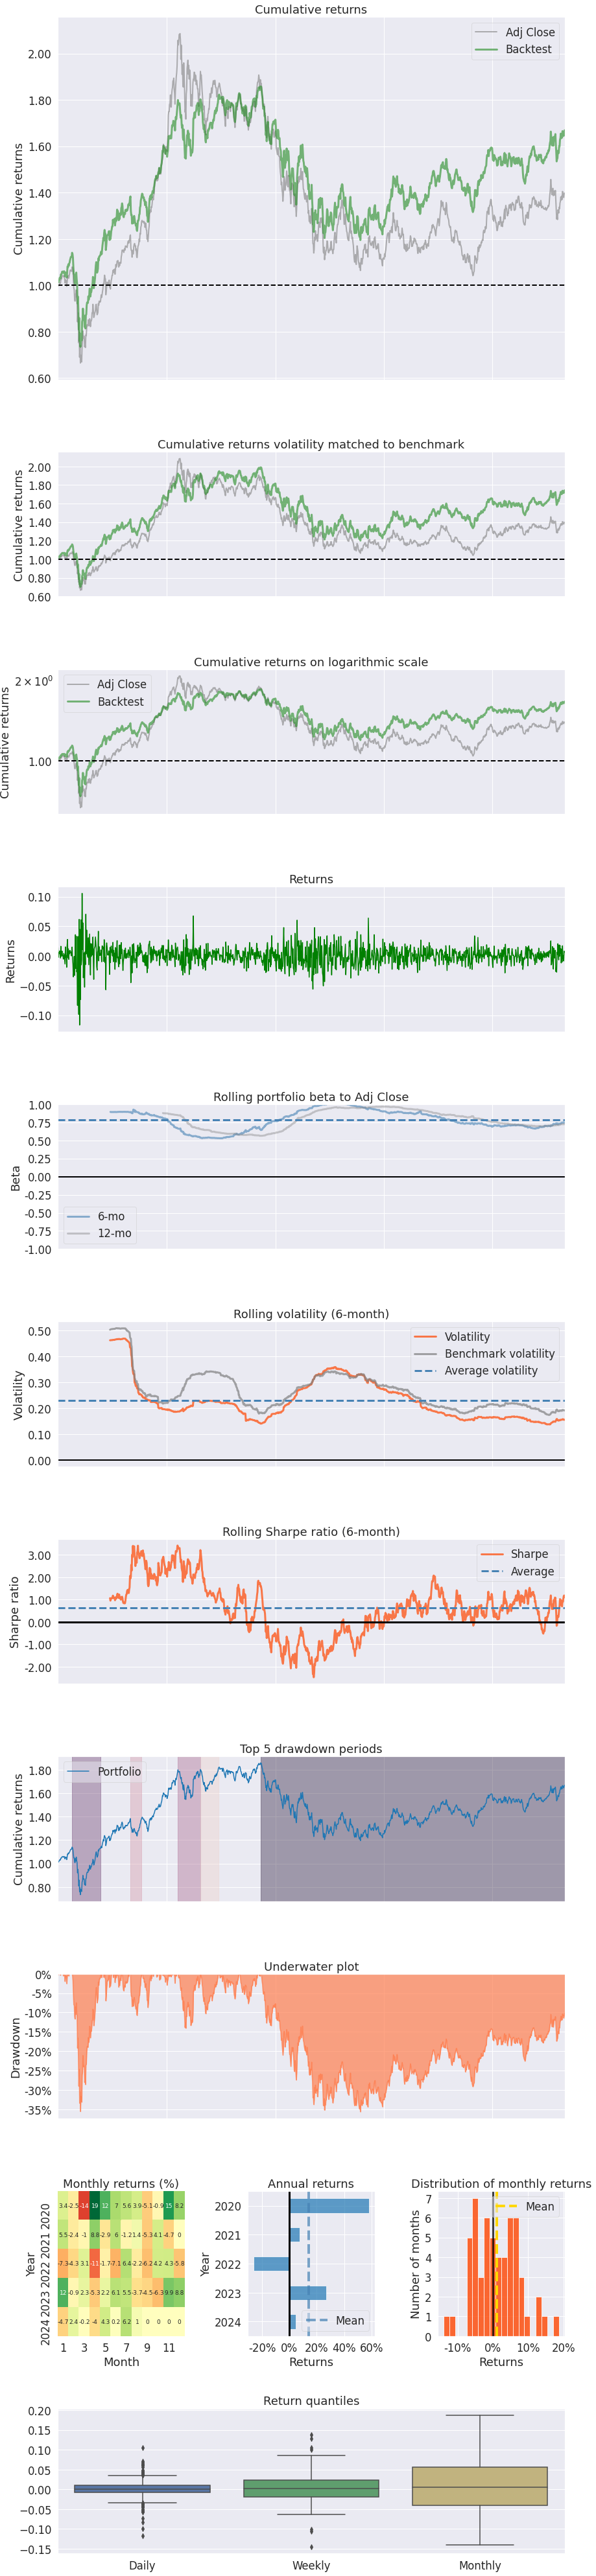

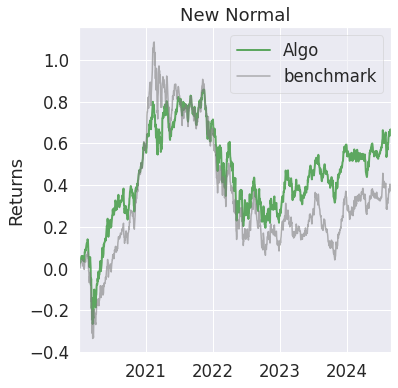

In [38]:
pf.create_full_tear_sheet(hrp_returns, 
                          benchmark_rets=komp_rets)

# Short Book

## Get S&P 500 data

In [39]:
# URL of the Wikipedia page
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"

# Use pandas to scrape all tables on the page
tables = pd.read_html(url)

# The first table is the "S&P 500 component stocks"
sp500_table = tables[0]

# Display the first few rows of the dataframe
sp500_table.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [40]:
# Sort S&P 500 data by date of foundation
sp500_table_sorted = sp500_table.sort_values(by='Founded', ascending=False)
sp500_table_sorted.head(10)

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
211,GEV,GE Vernova,Industrials,Heavy Electrical Equipment,"Cambridge, Massachusetts",2024-04-02,1996810,2024
469,VLTO,Veralto,Industrials,Environmental & Facilities Services,"Waltham, Massachusetts",2023-10-02,1967680,2023
421,SOLV,Solventum,Health Care,Health Care Technology,"Saint Paul, Minnesota",2024-04-01,1964738,2023
485,WBD,Warner Bros. Discovery,Communication Services,Broadcasting,"New York City, New York",2022-04-11,1437107,2022 (Warner Bros. 1923)
271,KVUE,Kenvue,Consumer Staples,Personal Care Products,"Skillman, New Jersey",2023-08-25,1944048,2022 (Johnson & Johnson spinoff)
131,CTRA,Coterra,Energy,Oil & Gas Exploration & Production,"Houston, Texas",2008-06-23,858470,2021 (1989)
88,CARR,Carrier Global,Industrials,Building Products,"Palm Beach Gardens, Florida",2020-04-03,1783180,"2020 (1915, United Technologies spinoff)"
359,OTIS,Otis Worldwide,Industrials,Industrial Machinery & Supplies & Components,"Farmington, Connecticut",2020-04-03,1781335,"2020 (1853, United Technologies spinoff)"
24,AMTM,Amentum,Industrials,Diversified Support Services,"Chantilly, Virginia",2024-09-30,2011286,2020
364,PARA,Paramount Global,Communication Services,Movies & Entertainment,"New York City, New York",1994-09-30,813828,2019 (Paramount Pictures 1912)


In [41]:
# Store symbols of stocks in a list
sp500_tickers = sp500_table['Symbol'].tolist()

start_date_sp500 = '2014-09-30' 
end_date_sp500 = '2024-08-31'

In [42]:
"""
Run the below code only once. After running it once, data are saved in an excel file named "S&P 500 data.xlsx"

sp500_data = yf.download(sp500_tickers, 
                         start=start_date_sp500, 
                         end=end_date_sp500, 
                         interval='1d', 
                         group_by='ticker') """

'\nRun the below code only once. After running it once, data are saved in an excel file named "S&P 500 data.xlsx"\n\nsp500_data = yf.download(sp500_tickers, \n                         start=start_date_sp500, \n                         end=end_date_sp500, \n                         interval=\'1d\', \n                         group_by=\'ticker\') '

In [43]:
# Import S&P 500 data
sp500_data = pd.read_excel('/Users/lucadonghi/Desktop/Python Works/LongShort Strategy/S&P 500 data.xlsx', index_col=0, header=[0, 1])
sp500_data.head()

STX                                                         \
                 Open       High        Low      Close  Adj Close     Volume   
Date                                                                           
2014-09-29  56.230000  57.310001  55.779999  57.250000  35.246475  2122200.0   
2014-09-30  57.209999  57.790001  56.740002  57.270000  35.258789  2311600.0   
2014-10-01  57.060001  57.250000  54.830002  55.080002  33.910500  3999100.0   
2014-10-02  55.230000  55.759998  54.380001  55.520000  34.181389  2314300.0   
2014-10-03  55.799999  56.730000  55.650002  56.080002  34.526150  2388600.0   

                  DLR                                   ...        ZBH  \
                 Open       High        Low      Close  ...        Low   
Date                                                    ...              
2014-09-29  62.130001  62.570000  61.450001  62.570000  ...  97.766991   
2014-09-30  62.480000  62.680000  61.849998  62.380001  ...  97.621361   
2014-10-01  62.419998  63.540001  62.189999  62.889999  ...  96.601944   
2014-10-02  62.740002  63.330002  62.330002  62.830002  ...  95.990288   
2014-10-03  63.139999  63.270000  62.299999  62.869999  ...  99.194176   

                                                    KR                        \
                Close  Adj Close     Volume       Open       High        Low   
Date                                                                           
2014-09-29  98.504852  91.183289   623356.0  25.750000  26.025000  25.725000   
2014-09-30  97.621361  90.365494  1056059.0  26.165001  26.250000  25.905001   
2014-10-01  97.825241  90.554222  1737713.0  25.959999  25.980000  25.770000   
2014-10-02  99.223305  91.848343  2803248.0  25.879999  25.940001  25.635000   
2014-10-03  99.601944  92.198853   753239.0  25.915001  26.475000  25.895000   

                                             
                Close  Adj Close     Volume  
Date                                         
2014-09-29  25.985001  21.488514  3305200.0  
2014-09-30  26.000000  21.500923  6503000.0  
2014-10-01  25.799999  21.335527  5078600.0  
2014-10-02  25.750000  21.294184  3775200.0  
2014-10-03  26.440001  21.864786  7326000.0  

[5 rows x 3018 columns]

In [44]:
# Dropping stocks with no prices available
sp500_data.drop(['BRK.B', 'BF.B'], axis=1, inplace=True)

## Get stock clusters with hierarchical clustering

In [45]:
# Storing close prices in a dedicated dataframe for hierarchical clustering
sp500_close = sp500_data.xs('Adj Close', axis=1, level=1)
sp500_close.head()

,STX,DLR,PEP,ALL,MAA,YUM,CI,CMCSA,QRVO,BKR,...,CFG,TJX,CL,CE,GS,KEY,O,WMT,ZBH,KR
Date,,,,,,,,,,,,,,,,,,,,,
2014-09-29,35.246475,42.959583,69.767746,49.228119,46.644791,43.166988,85.410698,21.975582,NaN,36.120983,...,16.495907,26.014616,51.954536,48.575890,151.146301,9.204414,25.384409,20.692081,91.183289,21.488514
2014-09-30,35.258789,42.829140,69.722794,49.292377,46.369347,42.762997,84.895859,21.821400,NaN,35.520412,...,16.630835,25.740551,51.629963,47.544075,150.932541,9.135876,25.192930,20.798157,90.365494,21.500923
2014-10-01,33.910500,43.179306,69.393242,48.842590,46.764870,42.483772,83.725700,21.476509,NaN,34.630493,...,16.645029,25.762304,51.368725,45.935436,148.572830,9.033073,25.304117,20.702963,90.554222,21.335527
2014-10-02,34.181389,43.138107,69.340813,49.107647,46.821373,42.489719,83.051697,21.439993,NaN,33.909813,...,16.574011,26.079870,51.281647,46.146675,150.365204,9.053635,25.304117,20.732880,91.848343,21.294184
2014-10-03,34.526150,43.165569,70.029877,49.581528,47.054459,42.555061,84.802231,21.768650,NaN,33.680519,...,16.495907,26.571449,51.819965,46.114170,154.632431,9.266094,25.384409,21.029339,92.198853,21.864786


In [46]:
# Resampling to weekly frequency 
sp500_weekly_close = sp500_close.resample('W').last()
sp500_weekly_close.head()

,STX,DLR,PEP,ALL,MAA,YUM,CI,CMCSA,QRVO,BKR,...,CFG,TJX,CL,CE,GS,KEY,O,WMT,ZBH,KR
Date,,,,,,,,,,,,,,,,,,,,,
2014-10-05,34.526150,43.165569,70.029877,49.581528,47.054459,42.555061,84.802231,21.768650,NaN,33.680519,...,16.495907,26.571449,51.819965,46.114170,154.632431,9.266094,25.384409,21.029339,92.198853,21.864786
2014-10-12,33.824299,43.151829,70.891205,49.123688,47.557579,41.176758,84.802231,21.350731,NaN,30.945232,...,15.821302,26.784611,51.685379,42.474442,148.309738,8.827462,26.267614,21.293161,90.841805,22.294804
2014-10-19,32.599136,44.209179,68.539406,48.706043,48.185963,40.865353,83.351265,20.563566,NaN,29.007076,...,15.565660,26.275635,50.733986,43.944965,145.456635,8.464220,26.891415,20.153574,87.642380,21.356211
2014-10-26,35.929855,45.520550,70.853767,50.256218,49.764084,41.767899,86.899132,22.016157,NaN,29.203619,...,16.460402,27.006477,52.023632,47.405956,150.751617,8.765783,27.774611,20.773678,94.625389,22.406441
2014-11-02,38.681850,47.367455,72.029663,52.087502,50.456726,42.933441,93.208519,22.458429,NaN,29.007875,...,16.772850,27.545906,53.241634,47.922394,156.211090,9.046781,28.543072,20.743763,99.972710,23.034927


In [47]:
# We are going to use only returns for the period 30/09/2020 to include most stocks in our clustering analysis
sp500_weekly_close_sub = sp500_weekly_close.loc['2020-09-30':]
sp500_weekly_close_sub.head()

,STX,DLR,PEP,ALL,MAA,YUM,CI,CMCSA,QRVO,BKR,...,CFG,TJX,CL,CE,GS,KEY,O,WMT,ZBH,KR
Date,,,,,,,,,,,,,,,,,,,,,
2020-10-04,42.371723,129.215637,123.228836,83.803772,108.528305,88.411652,156.789932,40.848473,130.570007,11.302935,...,21.915627,54.344711,70.430733,99.464005,181.044434,10.065571,51.209827,44.112038,129.960953,31.241899
2020-10-11,44.310352,136.993622,123.568001,83.659645,108.484444,88.708923,165.387421,40.781815,137.869995,11.794367,...,23.378897,54.872780,72.587334,108.275627,187.963791,10.806895,50.672569,44.827873,139.682755,31.590364
2020-10-18,44.718948,136.439926,126.504570,83.407387,105.632828,91.533043,166.793793,41.427402,134.759995,11.740757,...,22.250090,53.420570,73.078705,110.352211,186.759262,10.650394,48.539494,45.433826,138.682266,31.241899
2020-10-25,44.110409,132.027481,124.567696,82.209145,104.987206,94.087784,172.972397,40.972763,135.699997,12.768297,...,24.357197,53.769466,72.594322,110.425720,185.699615,11.078715,48.715912,45.163818,134.699158,30.040636
2020-11-01,41.571922,124.846405,118.971260,79.956841,103.147636,86.702324,156.546158,38.408562,127.360001,13.197183,...,23.102938,47.904068,72.182579,104.837936,171.208786,10.691577,46.584679,43.562595,124.684731,29.536293


In [48]:
# Dropping NaN values from subset dataframe of weekly returns
sp500_weekly_close_sub.dropna(axis=1, inplace=True)
print(len(sp500_weekly_close.columns))
print(len(sp500_weekly_close_sub.columns))

501
493


In [49]:
# Get the set of columns from each DataFrame
all_stocks = set(sp500_weekly_close.columns)
sub_stocks = set(sp500_weekly_close_sub.columns)

# Find the difference (stocks in sp500_weekly_close that are not in sp500_weekly_close_sub)
missing_stocks = list(all_stocks - sub_stocks)

# Display or store the missing stocks
print(missing_stocks)

['SOLV', 'KVUE', 'SW', 'ABNB', 'GEHC', 'CEG', 'VLTO', 'GEV']


In [50]:
# Calculate the number of missing stocks
num_missing_stocks = len(missing_stocks)

# Print the statement using an f-string
print(f"We lose {num_missing_stocks} stocks after dropping NaN values.")

We lose 8 stocks after dropping NaN values.


In [51]:
# Calculating weekly returns of S&P 500 sub-set
sp500_weekly_close_sub_rets = sp500_weekly_close_sub.pct_change().fillna(0)
sp500_weekly_close_sub_rets.head()

,STX,DLR,PEP,ALL,MAA,YUM,CI,CMCSA,QRVO,BKR,...,CFG,TJX,CL,CE,GS,KEY,O,WMT,ZBH,KR
Date,,,,,,,,,,,,,,,,,,,,,
2020-10-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-10-11,0.045753,0.060194,0.002752,-0.001720,-0.000404,0.003362,0.054834,-0.001632,0.055909,0.043478,...,0.066768,0.009717,0.030620,0.088591,0.038219,0.073650,-0.010491,0.016228,0.074806,0.011154
2020-10-18,0.009221,-0.004042,0.023765,-0.003015,-0.026286,0.031836,0.008504,0.015830,-0.022557,-0.004545,...,-0.048283,-0.026465,0.006769,0.019179,-0.006408,-0.014482,-0.042095,0.013517,-0.007163,-0.011031
2020-10-25,-0.013608,-0.032340,-0.015311,-0.014366,-0.006112,0.027911,0.037043,-0.010974,0.006975,0.087519,...,0.094701,0.006531,-0.006628,0.000666,-0.005674,0.040216,0.003635,-0.005943,-0.028721,-0.038450
2020-11-01,-0.057548,-0.054391,-0.044927,-0.027397,-0.017522,-0.078495,-0.094965,-0.062583,-0.061459,0.033590,...,-0.051494,-0.109084,-0.005672,-0.050602,-0.078034,-0.034944,-0.043748,-0.035454,-0.074347,-0.016789


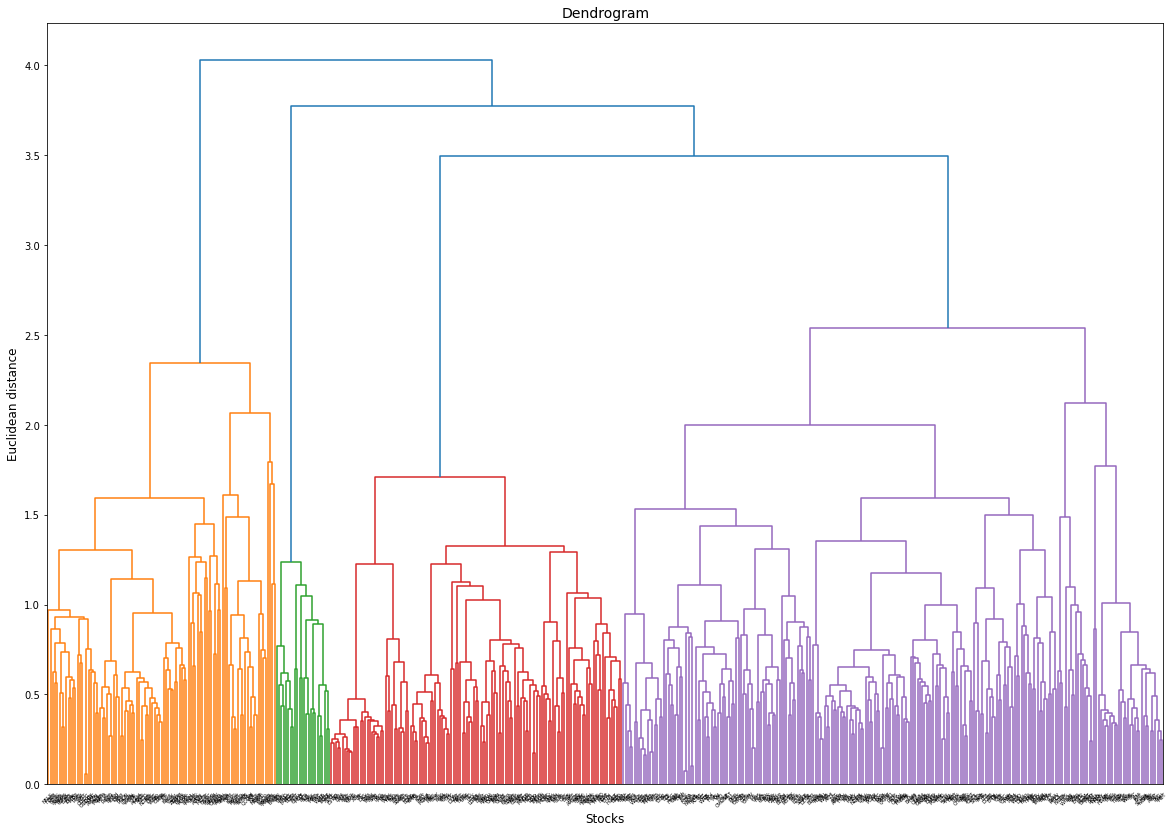

In [52]:
# Define the size of the graph
plt.figure(figsize=(20, 14))

# Title of the chart
plt.title('Dendrogram', fontsize=14)

# Create linkage matrix
linkage_matrix = linkage(sp500_weekly_close_sub_rets.T, method='ward')

# Create dendrogram
dendrogram(linkage_matrix, labels=sp500_weekly_close_sub_rets.T.index)

# Define labels
plt.xlabel("Stocks", fontsize=12)
plt.ylabel('Euclidean distance', fontsize=12)
plt.xticks(rotation=45)
plt.show()

In [53]:
# Step 1: Define an agglomerative clustering model
hrp_model = AgglomerativeClustering(n_clusters=4, linkage='ward')

# Step 2: Call fit_predict_method on scaled training data. This labels the stocks as 0 and 1
clusters = hrp_model.fit_predict(sp500_weekly_close_sub_rets.T)

# Step 3: Get tickers of cluster_0 and cluster_1 using labels 0 and 1
cluster_0 = sp500_weekly_close_sub_rets.T.loc[clusters == 0, :].index

cluster_1 = sp500_weekly_close_sub_rets.T.loc[clusters == 1, :].index

cluster_2 = sp500_weekly_close_sub_rets.T.loc[clusters == 2, :].index

cluster_3 = sp500_weekly_close_sub_rets.T.loc[clusters == 3, :].index

# Cluster_0
print(f'The stocks in cluster_0 are: {cluster_0.to_list()}')

# Cluster_1
print(f'The stocks in cluster_1 are: {cluster_1.to_list()}')

# Cluster_2
print(f'The stocks in cluster_2 are: {cluster_2.to_list()}')

# Cluster_3
print(f'The stocks in cluster_3 are: {cluster_3.to_list()}')

The stocks in cluster_0 are: ['STX', 'ALL', 'MAA', 'CMCSA', 'DRI', 'STT', 'HSIC', 'CB', 'AIG', 'LULU', 'NTAP', 'SHW', 'JCI', 'AOS', 'ROK', 'BSX', 'DAL', 'AIZ', 'SBUX', 'BWA', 'NSC', 'DIS', 'HON', 'DD', 'LVS', 'CPT', 'WFC', 'RL', 'DVA', 'NTRS', 'LEN', 'TDG', 'FDX', 'CHRW', 'SCHW', 'L', 'WYNN', 'CINF', 'TFX', 'VTRS', 'MAR', 'VZ', 'LYB', 'MDT', 'HIG', 'EQR', 'PRU', 'IFF', 'PKG', 'PM', 'BBWI', 'MLM', 'TPR', 'NCLH', 'WY', 'MO', 'CARR', 'AME', 'UAL', 'BG', 'USB', 'BEN', 'UPS', 'UNP', 'TEL', 'BAX', 'APH', 'GLW', 'FICO', 'UDR', 'LIN', 'VMC', 'CAT', 'OMC', 'SYY', 'ALLE', 'AVY', 'NWSA', 'WDC', 'BXP', 'FOX', 'ROST', 'GPC', 'MMM', 'HUBB', 'CHTR', 'JBHT', 'GWW', 'FIS', 'PARA', 'FMC', 'NWS', 'FI', 'HST', 'LUV', 'BX', 'EFX', 'FRT', 'INTC', 'DELL', 'FAST', 'BBY', 'LYV', 'IVZ', 'CMI', 'T', 'HAS', 'TSN', 'INVH', 'AXP', 'APTV', 'NKE', 'EMN', 'BK', 'HPQ', 'HPE', 'ACGL', 'HLT', 'WBD', 'BALL', 'SYK', 'STLD', 'GPN', 'GL', 'PH', 'BA', 'ODFL', 'HWM', 'OTIS', 'CCL', 'ADM', 'CTVA', 'BKNG', 'STE', 'DE', 'V', 'ULT

## Develop Predictive Model for Cluster 0

### Select candidate for the model

In [54]:
cluster_0_list = cluster_0.to_list()

In [55]:
# Filter the dataframe for rows where the 'Symbol' is in cluster_0_list
cluster_0_df = sp500_table[sp500_table['Symbol'].isin(cluster_0_list)]

# Sort the dataframe by the 'Date added' column in ascending order
cluster_0_df = cluster_0_df.sort_values(by='Date added', ascending=True)

# Show the first 5 values of cluster_df_0
cluster_0_df.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
461,UNP,Union Pacific Corporation,Industrials,Rail Transportation,"Omaha, Nebraska",1957-03-04,100885,1862
378,PPG,PPG Industries,Materials,Specialty Chemicals,"Pittsburgh, Pennsylvania",1957-03-04,79879,1883
343,NSC,Norfolk Southern Railway,Industrials,Rail Transportation,"Atlanta, Georgia",1957-03-04,702165,1881/1894 (1980)
235,HON,Honeywell,Industrials,Industrial Conglomerates,"Charlotte, North Carolina",1957-03-04,773840,1906


We pick the first company in the dataframe, as it is the one with the longest presence in the S&P 500

In [56]:
# Create dataframe to be used in the ML model based on the selected company
cluster_0_candidate = sp500_data[cluster_0_df.iloc[0,0]]

In [57]:
cluster_0_candidate.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-29,117.842812,119.013374,117.608696,118.887962,84.865318,3406567.0
2014-09-30,119.147156,119.481606,118.127090,118.461540,84.560913,3199420.0
2014-10-01,118.026756,118.453178,115.986626,116.371239,83.068817,3499376.0
2014-10-02,115.861206,116.488297,115.342812,115.944817,82.764427,3852675.0
2014-10-03,116.496658,117.433113,115.861206,117.198997,83.659668,4202864.0


In [58]:
cluster_0_candidate.fillna(method='ffill', inplace=True)
cluster_0_candidate.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2499 entries, 2014-09-29 to 2024-08-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2499 non-null   float64
 1   High       2499 non-null   float64
 2   Low        2499 non-null   float64
 3   Close      2499 non-null   float64
 4   Adj Close  2499 non-null   float64
 5   Volume     2499 non-null   float64
dtypes: float64(6)
memory usage: 136.7 KB


### Calculate technical indicators

In [59]:
"""This function applies TA indicators to the dataframe"""

def add_technical_indicators(df):
    # BBANDS (Bollinger Bands)
    df['upperband'], df['middleband'], df['lowerband'] = ta.BBANDS(df['Adj Close'], timeperiod=20)

    # EMA (Exponential Moving Average)
    df['EMA'] = ta.EMA(df['Adj Close'], timeperiod=14)

    # KAMA (Kaufman Adaptive Moving Average)
    df['KAMA'] = ta.KAMA(df['Adj Close'], timeperiod=30)

    # SAR (Parabolic SAR)
    df['SAR'] = ta.SAR(df['High'], df['Low'], acceleration=0.02, maximum=0.2)

    # ADX (Average Directional Movement Index)
    df['ADX'] = ta.ADX(df['High'], df['Low'], df['Adj Close'], timeperiod=14)

    # AROONOSC (Aroon Oscillator)
    df['AROONOSC'] = ta.AROONOSC(df['High'], df['Low'], timeperiod=14)

    # MFI (Money Flow Index)
    df['MFI'] = ta.MFI(df['High'], df['Low'], df['Adj Close'], df['Volume'], timeperiod=14)

    # MOM (Momentum)
    df['MOM'] = ta.MOM(df['Adj Close'], timeperiod=10)

    # ROC (Rate of Change)
    df['ROC'] = ta.ROC(df['Adj Close'], timeperiod=10)

    # RSI (Relative Strength Index)
    df['RSI'] = ta.RSI(df['Adj Close'], timeperiod=14)

    # OBV (On-Balance Volume)
    df['OBV'] = ta.OBV(df['Adj Close'], df['Volume'])

    # HT_TRENDMODE (Hilbert Transform - Trend vs Cycle Mode)
    df['HT_TRENDMODE'] = ta.HT_TRENDMODE(df['Adj Close'])

    # ATR (Average True Range)
    df['ATR'] = ta.ATR(df['High'], df['Low'], df['Adj Close'], timeperiod=14)

    # Candlestick Pattern Recognition
    df['CDL3BLACKCROWS'] = ta.CDL3BLACKCROWS(df['Open'], df['High'], df['Low'], df['Adj Close'])
    df['CDL3WHITESOLDIERS'] = ta.CDL3WHITESOLDIERS(df['Open'], df['High'], df['Low'], df['Adj Close'])
    df['CDLDARKCLOUDCOVER'] = ta.CDLDARKCLOUDCOVER(df['Open'], df['High'], df['Low'], df['Adj Close'])
    df['CDLDOJI'] = ta.CDLDOJI(df['Open'], df['High'], df['Low'], df['Adj Close'])
    df['CDLDOJISTAR'] = ta.CDLDOJISTAR(df['Open'], df['High'], df['Low'], df['Adj Close'])
    df['CDLDRAGONFLYDOJI'] = ta.CDLDRAGONFLYDOJI(df['Open'], df['High'], df['Low'], df['Adj Close'])
    df['CDLENGULFING'] = ta.CDLENGULFING(df['Open'], df['High'], df['Low'], df['Adj Close'])
    df['CDLEVENINGDOJISTAR'] = ta.CDLEVENINGDOJISTAR(df['Open'], df['High'], df['Low'], df['Adj Close'])
    df['CDLEVENINGSTAR'] = ta.CDLEVENINGSTAR(df['Open'], df['High'], df['Low'], df['Adj Close'])
    df['CDLGRAVESTONEDOJI'] = ta.CDLGRAVESTONEDOJI(df['Open'], df['High'], df['Low'], df['Adj Close'])
    df['CDLHAMMER'] = ta.CDLHAMMER(df['Open'], df['High'], df['Low'], df['Adj Close'])
    df['CDLHANGINGMAN'] = ta.CDLHANGINGMAN(df['Open'], df['High'], df['Low'], df['Adj Close'])
    df['CDLHARAMI'] = ta.CDLHARAMI(df['Open'], df['High'], df['Low'], df['Adj Close'])
    df['CDLHIKKAKE'] = ta.CDLHIKKAKE(df['Open'], df['High'], df['Low'], df['Adj Close'])
    df['CDLMORNINGDOJISTAR'] = ta.CDLMORNINGDOJISTAR(df['Open'], df['High'], df['Low'], df['Adj Close'])
    df['CDLMORNINGSTAR'] = ta.CDLMORNINGSTAR(df['Open'], df['High'], df['Low'], df['Adj Close'])
    df['CDLPIERCING'] = ta.CDLPIERCING(df['Open'], df['High'], df['Low'], df['Adj Close'])
    df['CDLSPINNINGTOP'] = ta.CDLSPINNINGTOP(df['Open'], df['High'], df['Low'], df['Adj Close'])
    df['CDLMARUBOZU'] = ta.CDLMARUBOZU(df['Open'], df['High'], df['Low'], df['Adj Close'])
    df['CDLINVERTEDHAMMER'] = ta.CDLINVERTEDHAMMER(df['Open'], df['High'], df['Low'], df['Adj Close'])

    return df

In [60]:
# Apply add_technical_indicators function to candidate dataframe
cluster_0_ta = add_technical_indicators(cluster_0_candidate.copy())

In [61]:
# Display first 5 rows of dataframe
cluster_0_ta.head()

,Open,High,Low,Close,Adj Close,Volume,upperband,middleband,lowerband,EMA,...,CDLHAMMER,CDLHANGINGMAN,CDLHARAMI,CDLHIKKAKE,CDLMORNINGDOJISTAR,CDLMORNINGSTAR,CDLPIERCING,CDLSPINNINGTOP,CDLMARUBOZU,CDLINVERTEDHAMMER
Date,,,,,,,,,,,,,,,,,,,,,
2014-09-29,117.842812,119.013374,117.608696,118.887962,84.865318,3406567.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2014-09-30,119.147156,119.481606,118.127090,118.461540,84.560913,3199420.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2014-10-01,118.026756,118.453178,115.986626,116.371239,83.068817,3499376.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2014-10-02,115.861206,116.488297,115.342812,115.944817,82.764427,3852675.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2014-10-03,116.496658,117.433113,115.861206,117.198997,83.659668,4202864.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [62]:
cluster_0_ta.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2499 entries, 2014-09-29 to 2024-08-30
Data columns (total 41 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Open                2499 non-null   float64
 1   High                2499 non-null   float64
 2   Low                 2499 non-null   float64
 3   Close               2499 non-null   float64
 4   Adj Close           2499 non-null   float64
 5   Volume              2499 non-null   float64
 6   upperband           2480 non-null   float64
 7   middleband          2480 non-null   float64
 8   lowerband           2480 non-null   float64
 9   EMA                 2486 non-null   float64
 10  KAMA                2469 non-null   float64
 11  SAR                 2498 non-null   float64
 12  ADX                 2472 non-null   float64
 13  AROONOSC            2485 non-null   float64
 14  MFI                 2485 non-null   float64
 15  MOM                 2489 non-null   f

### Populate the label column

In [63]:
def create_short_sell_target(df, price_drop_threshold=-0.05, upward_move_threshold=0.03, N=20):
    """
    Function to create a target column for short selling based on two conditions:
    1. Price drop > price_drop_threshold (e.g., 5%) over the next N days.
    2. No upward movement > upward_move_threshold (e.g., 3%) during the same N days.
    
    Parameters:
    - df: DataFrame containing 'Close' price data.
    - price_drop_threshold: Percentage drop threshold (default is -0.05 for a 5% drop).
    - upward_move_threshold: Maximum upward move allowed (default is 0.03 for 3%).
    - N: Time horizon (default is 20 days).
    
    Returns:
    - df: DataFrame with an additional 'Target' column and without intermediate calculation columns.
    """
    
    # Condition (a): Price drop > price_drop_threshold over the next N days
    df['Price_Drop'] = (df['Close'].shift(-N) - df['Close']) / df['Close']

    # Condition (b): No upward move > upward_move_threshold during the next N days
    df['Max_Upward_Move'] = df['Close'].rolling(window=N).max().shift(-N)
    df['Upward_Move_Flag'] = (df['Max_Upward_Move'] - df['Close']) / df['Close']

    # Target is 1 if price drop > price_drop_threshold and no upward move > upward_move_threshold
    df['Target'] = np.where((df['Price_Drop'] <= price_drop_threshold) & 
                            (df['Upward_Move_Flag'] <= upward_move_threshold), 1, 0)

    # Drop the intermediate columns
    df.drop(columns=['Price_Drop', 'Max_Upward_Move', 'Upward_Move_Flag'], inplace=True)

    # Drop any rows with NaN values caused by the shifting operation
    df.dropna(subset=['Target'], inplace=True)

    return df

# Example usage:
# df = create_short_sell_target(df, price_drop_threshold=-0.05, upward_move_threshold=0.03, N=20)



In [64]:
cluster_0_ta = create_short_sell_target(cluster_0_ta, 
                                        price_drop_threshold=-0.05, 
                                        upward_move_threshold=0.03, 
                                        N=20)


cluster_0_ta.head()


,Open,High,Low,Close,Adj Close,Volume,upperband,middleband,lowerband,EMA,...,CDLHANGINGMAN,CDLHARAMI,CDLHIKKAKE,CDLMORNINGDOJISTAR,CDLMORNINGSTAR,CDLPIERCING,CDLSPINNINGTOP,CDLMARUBOZU,CDLINVERTEDHAMMER,Target
Date,,,,,,,,,,,,,,,,,,,,,
2014-09-29,117.842812,119.013374,117.608696,118.887962,84.865318,3406567.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2014-09-30,119.147156,119.481606,118.127090,118.461540,84.560913,3199420.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2014-10-01,118.026756,118.453178,115.986626,116.371239,83.068817,3499376.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2014-10-02,115.861206,116.488297,115.342812,115.944817,82.764427,3852675.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2014-10-03,116.496658,117.433113,115.861206,117.198997,83.659668,4202864.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [65]:
target_count = cluster_0_ta['Target'].sum()
print(f"Number of times Target is equal to 1: {target_count}")

Number of times Target is equal to 1: 385


In [66]:
# Remove rows with NaN values
cluster_0_ta.dropna(axis=0, inplace=True)
cluster_0_ta.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2469 entries, 2014-11-10 to 2024-08-30
Data columns (total 42 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Open                2469 non-null   float64
 1   High                2469 non-null   float64
 2   Low                 2469 non-null   float64
 3   Close               2469 non-null   float64
 4   Adj Close           2469 non-null   float64
 5   Volume              2469 non-null   float64
 6   upperband           2469 non-null   float64
 7   middleband          2469 non-null   float64
 8   lowerband           2469 non-null   float64
 9   EMA                 2469 non-null   float64
 10  KAMA                2469 non-null   float64
 11  SAR                 2469 non-null   float64
 12  ADX                 2469 non-null   float64
 13  AROONOSC            2469 non-null   float64
 14  MFI                 2469 non-null   float64
 15  MOM                 2469 non-null   f

In [67]:
cluster_0_ta.head()

,Open,High,Low,Close,Adj Close,Volume,upperband,middleband,lowerband,EMA,...,CDLHANGINGMAN,CDLHARAMI,CDLHIKKAKE,CDLMORNINGDOJISTAR,CDLMORNINGSTAR,CDLPIERCING,CDLSPINNINGTOP,CDLMARUBOZU,CDLINVERTEDHAMMER,Target
Date,,,,,,,,,,,,,,,,,,,,,
2014-11-10,130.643814,131.864548,130.476593,131.822739,94.098480,1750346.0,97.604736,87.848640,78.092544,90.647596,...,0,0,-100,0,0,0,0,0,0,0
2014-11-11,132.065216,132.107025,130.978256,131.362869,93.770226,2160694.0,97.927889,88.532922,79.137955,91.063947,...,0,0,-200,0,0,0,0,-100,0,0
2014-11-12,130.978256,131.998322,130.852844,131.839462,94.110435,1794837.0,98.083572,89.233020,80.382468,91.470145,...,0,0,0,0,0,0,0,0,0,0
2014-11-13,132.107025,133.001678,131.672241,132.399673,94.510323,2840620.0,98.118326,89.928345,81.738364,91.875502,...,0,0,0,0,0,0,0,0,0,0
2014-11-14,132.550171,132.842804,131.864548,132.817719,94.808739,2136415.0,98.161159,90.568460,82.975762,92.266601,...,0,0,0,0,0,0,0,0,0,0


In [68]:
cluster_0_ta.tail()

,Open,High,Low,Close,Adj Close,Volume,upperband,middleband,lowerband,EMA,...,CDLHANGINGMAN,CDLHARAMI,CDLHIKKAKE,CDLMORNINGDOJISTAR,CDLMORNINGSTAR,CDLPIERCING,CDLSPINNINGTOP,CDLMARUBOZU,CDLINVERTEDHAMMER,Target
Date,,,,,,,,,,,,,,,,,,,,,
2024-08-26,129.600006,131.919998,129.600006,131.850006,131.850006,3915800.0,130.570457,125.943600,121.316743,126.341099,...,0,0,0,0,0,0,0,100,0,0
2024-08-27,131.320007,132.619995,130.949997,131.399994,131.399994,2878500.0,131.413444,126.210081,121.006718,127.015618,...,0,-100,0,0,0,0,100,0,0,0
2024-08-28,131.399994,132.619995,131.149994,131.610001,131.610001,3274000.0,132.156541,126.447277,120.738012,127.628202,...,0,0,0,0,0,0,100,0,0,0
2024-08-29,131.649994,133.179993,131.339996,132.910004,132.910004,2992600.0,133.155858,126.803183,120.450508,128.332443,...,0,0,0,0,0,0,0,0,0,0
2024-08-30,133.070007,134.990005,132.610001,134.690002,134.690002,6092800.0,134.434821,127.309259,120.183698,129.180117,...,0,0,0,0,0,0,0,0,0,0


### Augment features space

In [69]:
# Select the first 19 columns for lag and rolling statistics
columns_to_transform = cluster_0_ta.columns[:19]

# Create lagged features (lag by 20 and 60 days)
for lag in [20, 60]:
    for column in columns_to_transform:
        cluster_0_ta[f'{column}_lag_{lag}'] = cluster_0_ta[column].shift(lag)

# Create rolling statistics (mean and std over the past 20 and 60 days)
for window in [20, 60]:
    for column in columns_to_transform:
        cluster_0_ta[f'{column}_rolling_mean_{window}'] = cluster_0_ta[column].rolling(window=window).mean()
        cluster_0_ta[f'{column}_rolling_std_{window}'] = cluster_0_ta[column].rolling(window=window).std()

# Add the day of the week as a feature
cluster_0_ta['day_of_week'] = cluster_0_ta.index.dayofweek

cluster_0_ta.head()

,Open,High,Low,Close,Adj Close,Volume,upperband,middleband,lowerband,EMA,...,MFI_rolling_std_60,MOM_rolling_mean_60,MOM_rolling_std_60,ROC_rolling_mean_60,ROC_rolling_std_60,RSI_rolling_mean_60,RSI_rolling_std_60,OBV_rolling_mean_60,OBV_rolling_std_60,day_of_week
Date,,,,,,,,,,,,,,,,,,,,,
2014-11-10,130.643814,131.864548,130.476593,131.822739,94.098480,1750346.0,97.604736,87.848640,78.092544,90.647596,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2014-11-11,132.065216,132.107025,130.978256,131.362869,93.770226,2160694.0,97.927889,88.532922,79.137955,91.063947,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2014-11-12,130.978256,131.998322,130.852844,131.839462,94.110435,1794837.0,98.083572,89.233020,80.382468,91.470145,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
2014-11-13,132.107025,133.001678,131.672241,132.399673,94.510323,2840620.0,98.118326,89.928345,81.738364,91.875502,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
2014-11-14,132.550171,132.842804,131.864548,132.817719,94.808739,2136415.0,98.161159,90.568460,82.975762,92.266601,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4


In [70]:
# Drop rows with NaN values
cluster_0_ta = cluster_0_ta.dropna()

In [71]:
# Calculate the new total number of features and the length of the cleaned dataframe
num_features = cluster_0_ta.shape[1]
num_rows = cluster_0_ta.shape[0]

num_features, num_rows

(157, 2409)

In [72]:
cluster_0_ta.head()

,Open,High,Low,Close,Adj Close,Volume,upperband,middleband,lowerband,EMA,...,MFI_rolling_std_60,MOM_rolling_mean_60,MOM_rolling_std_60,ROC_rolling_mean_60,ROC_rolling_std_60,RSI_rolling_mean_60,RSI_rolling_std_60,OBV_rolling_mean_60,OBV_rolling_std_60,day_of_week
Date,,,,,,,,,,,,,,,,,,,,,
2015-02-06,138.988297,140.200668,138.428101,138.854507,99.649979,2184972.0,100.592004,98.014833,95.437662,98.706383,...,16.010539,1.140328,2.471486,1.235671,2.567656,60.594939,9.509672,4.299409e+07,5.588330e+06,4
2015-02-09,137.441467,138.411377,136.989960,137.826080,98.911896,2479308.0,100.670961,98.111439,95.551916,98.733785,...,15.459555,1.086146,2.451964,1.175009,2.544006,60.304796,9.458916,4.307141e+07,5.512427e+06,0
2015-02-10,138.294312,138.913040,137.625412,138.645493,99.499954,2254580.0,100.772415,98.263851,95.755286,98.835941,...,14.887961,1.041699,2.422595,1.123700,2.508308,60.039613,9.357385,4.315640e+07,5.458638e+06,1
2015-02-11,137.558533,137.934784,136.680603,137.525085,99.309769,2027340.0,100.801135,98.410354,96.019573,98.899118,...,14.338886,0.995159,2.396754,1.071104,2.477543,59.740762,9.231186,4.316025e+07,5.456446e+06,2
2015-02-12,137.901337,138.754181,137.834442,138.720734,100.173172,1932377.0,100.838615,98.623429,96.408244,99.068992,...,13.747264,0.952746,2.382573,1.024189,2.461148,59.488151,9.053938,4.316070e+07,5.456360e+06,3


In [73]:
cluster_0_ta.tail()

,Open,High,Low,Close,Adj Close,Volume,upperband,middleband,lowerband,EMA,...,MFI_rolling_std_60,MOM_rolling_mean_60,MOM_rolling_std_60,ROC_rolling_mean_60,ROC_rolling_std_60,RSI_rolling_mean_60,RSI_rolling_std_60,OBV_rolling_mean_60,OBV_rolling_std_60,day_of_week
Date,,,,,,,,,,,,,,,,,,,,,
2024-08-26,129.600006,131.919998,129.600006,131.850006,131.850006,3915800.0,130.570457,125.943600,121.316743,126.341099,...,10.305529,4.500026,8.148829,4.323000,7.856431,63.289144,9.365790,2.618838e+07,1.578369e+07,0
2024-08-27,131.320007,132.619995,130.949997,131.399994,131.399994,2878500.0,131.413444,126.210081,121.006718,127.015618,...,10.284066,4.678316,8.076960,4.476827,7.783955,63.572682,9.466883,2.679681e+07,1.609319e+07,1
2024-08-28,131.399994,132.619995,131.149994,131.610001,131.610001,3274000.0,132.156541,126.447277,120.738012,127.628202,...,10.274343,4.859399,7.983286,4.634175,7.692930,63.885636,9.547609,2.753494e+07,1.640191e+07,2
2024-08-29,131.649994,133.179993,131.339996,132.910004,132.910004,2992600.0,133.155858,126.803183,120.450508,128.332443,...,10.495599,5.063976,7.860717,4.812634,7.574252,64.300306,9.581711,2.840608e+07,1.666340e+07,3
2024-08-30,133.070007,134.990005,132.610001,134.690002,134.690002,6092800.0,134.434821,127.309259,120.183698,129.180117,...,10.934903,5.258506,7.793083,4.977195,7.502172,64.726890,9.680389,2.932684e+07,1.713920e+07,4


### Feature engineering

In [74]:
# Separate features and target
X_0 = cluster_0_ta.drop(columns=['Target'])
y_0 = cluster_0_ta['Target']

In [75]:
# Compute correlation matrix
correlation_matrix = X_0.corr()

# Find highly correlated features
threshold = 0.8
high_corr_pairs = correlation_matrix[(correlation_matrix > threshold) & (correlation_matrix < 1.0)]
high_corr_pairs.dropna(how='all', inplace=True)  # Remove NaN rows

In [76]:
high_corr_pairs

,Open,High,Low,Close,Adj Close,Volume,upperband,middleband,lowerband,EMA,...,MFI_rolling_std_60,MOM_rolling_mean_60,MOM_rolling_std_60,ROC_rolling_mean_60,ROC_rolling_std_60,RSI_rolling_mean_60,RSI_rolling_std_60,OBV_rolling_mean_60,OBV_rolling_std_60,day_of_week
Open,NaN,0.999387,0.999197,0.998536,0.932969,NaN,0.894816,0.923577,0.930934,0.930878,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
High,0.999387,NaN,0.998986,0.999270,0.935289,NaN,0.897059,0.924869,0.931213,0.932134,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Low,0.999197,0.998986,NaN,0.999342,0.932301,NaN,0.890269,0.920098,0.928643,0.927851,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Close,0.998536,0.999270,0.999342,NaN,0.934532,NaN,0.892744,0.921548,0.928999,0.929207,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Adj Close,0.932969,0.935289,0.932301,0.934532,NaN,NaN,0.963727,0.980321,0.973735,0.990375,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MOM_rolling_std_60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.881092,NaN,NaN,NaN,NaN,NaN
ROC_rolling_mean_60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.981257,NaN,NaN,NaN,0.865495,NaN,NaN,NaN,NaN
ROC_rolling_std_60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.881092,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RSI_rolling_mean_60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.878648,NaN,0.865495,NaN,NaN,NaN,NaN,NaN,NaN


In [77]:
# Step 1: Split the dataset into training + validation (90%) and test set (10%)
X_train_val, X_test, y_train_val, y_test = train_test_split(X_0, y_0, test_size=0.10, random_state=42, stratify=y_0)

# Step 2: Split the training + validation set into training (70%) and validation (20%)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.22, random_state=42, stratify=y_train_val)  # 22% to get 20% of the original dataset

# Verify the shapes of the partitions
print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}")

Training set: (1691, 156), Validation set: (477, 156), Test set: (241, 156)


### Train Random Forest Model

In [78]:
# Define the Random Forest model
rf_0 = RandomForestClassifier(random_state=42, class_weight='balanced')  # Handle class imbalance by assigning weights

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],  # Number of trees in the forest
    'max_depth': [6],  # Maximum depth of the tree
    'max_features': ['sqrt', 'log2'],  # Number of features to consider at each split
    'min_samples_leaf': [12],  # This ensures that leaf nodes contain more samples
    'min_samples_split': [50]  # This controls how many samples a node must have before it can be split
}

# Set up StratifiedKFold for cross-validation to preserve class distribution
tscv = TimeSeriesSplit(n_splits=5)

# Set up GridSearchCV with cross-validation only on the training data, using precision score for imbalanced data
grid_search_0 = GridSearchCV(estimator=rf_0, param_grid=param_grid, 
                           cv=tscv, scoring='precision', n_jobs=-1, verbose=2)

# Fit the model using GridSearchCV on the training data
grid_search_0.fit(X_train, y_train)

# Get the best parameters from GridSearchCV
best_params_0 = grid_search_0.best_params_
print("Best Hyperparameters:", best_params_0)
print('---------------------------------------------------------------')

# Train the Random Forest with the best hyperparameters on the training data
best_rf_0 = RandomForestClassifier(**best_params_0, random_state=42, class_weight='balanced')
best_rf_0.fit(X_train, y_train)

# Step 1: Predict probabilities instead of hard class labels
y_train_proba_0 = best_rf_0.predict_proba(X_train)[:, 1]  # Probability estimates for class 1
y_val_proba_0 = best_rf_0.predict_proba(X_val)[:, 1]

# Step 2: Apply a custom threshold for class 1 predictions
threshold = 0.6  # Adjust this value to increase precision for class 1
y_pred_train_custom_thresh_0 = (y_train_proba_0 >= threshold).astype(int)
y_pred_val_custom_thresh_0 = (y_val_proba_0 >= threshold).astype(int)

# Step 3: Evaluate model performance with the custom threshold

# Training performance
print("Training Accuracy:", accuracy_score(y_train, y_pred_train_custom_thresh_0))
print("Training Precision:", precision_score(y_train, y_pred_train_custom_thresh_0))
print("Training Recall:", recall_score(y_train, y_pred_train_custom_thresh_0))
print("\nTraining Classification Report:\n", classification_report(y_train, y_pred_train_custom_thresh_0))
print('---------------------------------------------------------------')

# Validation performance
print("Validation Accuracy:", accuracy_score(y_val, y_pred_val_custom_thresh_0))
print("Validation Precision:", precision_score(y_val, y_pred_val_custom_thresh_0))
print("Validation Recall:", recall_score(y_val, y_pred_val_custom_thresh_0))
print("\nValidation Classification Report:\n", classification_report(y_val, y_pred_val_custom_thresh_0))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Hyperparameters: {'max_depth': 6, 'max_features': 'log2', 'min_samples_leaf': 12, 'min_samples_split': 50, 'n_estimators': 200}
---------------------------------------------------------------
Training Accuracy: 0.9455943228858663
Training Precision: 0.84765625
Training Recall: 0.8037037037037037

Training Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.97      1421
           1       0.85      0.80      0.83       270

    accuracy                           0.95      1691
   macro avg       0.91      0.89      0.90      1691
weighted avg       0.94      0.95      0.95      1691

---------------------------------------------------------------
Validation Accuracy: 0.9077568134171907
Validation Precision: 0.82
Validation Recall: 0.5394736842105263

Validation Classification Report:
               precision    recall  f1-score   support

           0     

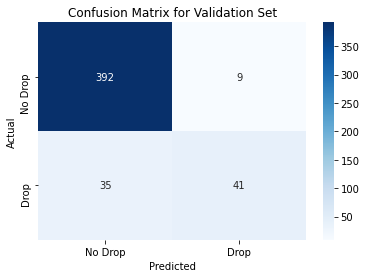

In [79]:
# Generate the confusion matrix
cm_val_0 = confusion_matrix(y_val, y_pred_val_custom_thresh_0)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6,4))
sns.heatmap(cm_val_0, annot=True, fmt='d', cmap='Blues', xticklabels=['No Drop', 'Drop'], yticklabels=['No Drop', 'Drop'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for Validation Set')
plt.show()

### Evaluate the Model on the Test Set

In [80]:
# Step 1: Predict probabilities for the test set
y_test_proba_0 = best_rf_0.predict_proba(X_test)[:, 1]  # Probability estimates for class 1

# Step 2: Apply the same custom threshold for class 1 predictions
y_pred_test_custom_thresh_0 = (y_test_proba_0 >= threshold).astype(int)

# Step 3: Evaluate model performance on the test set with the custom threshold

# Test performance
print("Test Accuracy:", accuracy_score(y_test, y_pred_test_custom_thresh_0))
print("Test Precision:", precision_score(y_test, y_pred_test_custom_thresh_0))
print("Test Recall:", recall_score(y_test, y_pred_test_custom_thresh_0))
print("\nTest Classification Report:\n", classification_report(y_test, y_pred_test_custom_thresh_0))

Test Accuracy: 0.91701244813278
Test Precision: 0.8064516129032258
Test Recall: 0.6410256410256411

Test Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95       202
           1       0.81      0.64      0.71        39

    accuracy                           0.92       241
   macro avg       0.87      0.81      0.83       241
weighted avg       0.91      0.92      0.91       241



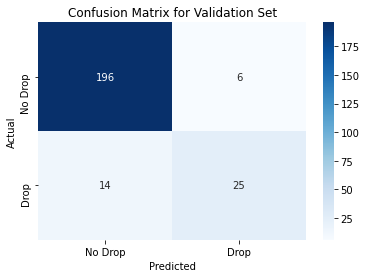

In [81]:
# Generate the confusion matrix
cm_test_0 = confusion_matrix(y_test, y_pred_test_custom_thresh_0)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6,4))
sns.heatmap(cm_test_0, annot=True, fmt='d', cmap='Blues', xticklabels=['No Drop', 'Drop'], yticklabels=['No Drop', 'Drop'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for Validation Set')
plt.show()

### Saving Predictive Model for Cluster 0

In [82]:
# Set the path to your Desktop
desktop_path = os.path.join(os.path.expanduser("~"), "Desktop/Python Works/LongShort Strategy", "best_rf_0_model.pkl")

# Save the model to the specified path
with open(desktop_path, 'wb') as file:
    pickle.dump(best_rf_0, file)

## Develop Predictive Model for Cluster 1

### Select candidate for the model

In [83]:
cluster_1_list = cluster_1.to_list()

In [84]:
# Filter the dataframe for rows where the 'Symbol' is in cluster_1_list
cluster_1_df = sp500_table[sp500_table['Symbol'].isin(cluster_1_list)]

# Sort the dataframe by the 'Date added' column in ascending order
cluster_1_df = cluster_1_df.sort_values(by='Date added', ascending=True)

# Show the first 5 values of cluster_df_1
cluster_1_df.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
331,MSI,Motorola Solutions,Information Technology,Communications Equipment,"Chicago, Illinois",1957-03-04,68505,1928 (2011)
408,SPGI,S&P Global,Financials,Financial Exchanges & Data,"New York City, New York",1957-03-04,64040,1917
50,ADP,Automatic Data Processing,Industrials,Human Resource & Employment Services,"Roseland, New Jersey",1981-03-31,8670,1949
39,AAPL,Apple Inc.,Information Technology,"Technology Hardware, Storage & Peripherals","Cupertino, California",1982-11-30,320193,1977
402,RVTY,Revvity,Health Care,Health Care Equipment,"Waltham, Massachusetts",1985-05-31,31791,1937


In [85]:
# Create dataframe to be used in the ML model based on the selected company
cluster_1_candidate = sp500_data[cluster_1_df.iloc[0,0]]

In [86]:
cluster_1_candidate.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-29,62.959999,63.320000,62.520000,63.180000,53.301003,2216600.0
2014-09-30,63.180000,63.419998,63.000000,63.279999,53.385372,1635500.0
2014-10-01,63.380001,63.380001,62.270000,62.340000,52.592339,3382100.0
2014-10-02,62.060001,62.200001,60.860001,61.029999,51.487183,2723200.0
2014-10-03,61.080002,61.480000,60.639999,61.299999,51.714962,1798400.0


In [87]:
cluster_1_candidate.fillna(method='ffill', inplace=True)
cluster_1_candidate.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2499 entries, 2014-09-29 to 2024-08-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2499 non-null   float64
 1   High       2499 non-null   float64
 2   Low        2499 non-null   float64
 3   Close      2499 non-null   float64
 4   Adj Close  2499 non-null   float64
 5   Volume     2499 non-null   float64
dtypes: float64(6)
memory usage: 136.7 KB


### Calculate technical indicators

In [88]:
# Apply add_technical_indicators function to candidate dataframe
cluster_1_ta = add_technical_indicators(cluster_1_candidate.copy())

In [89]:
# Display first 5 rows of dataframe
cluster_1_ta.head()

,Open,High,Low,Close,Adj Close,Volume,upperband,middleband,lowerband,EMA,...,CDLHAMMER,CDLHANGINGMAN,CDLHARAMI,CDLHIKKAKE,CDLMORNINGDOJISTAR,CDLMORNINGSTAR,CDLPIERCING,CDLSPINNINGTOP,CDLMARUBOZU,CDLINVERTEDHAMMER
Date,,,,,,,,,,,,,,,,,,,,,
2014-09-29,62.959999,63.320000,62.520000,63.180000,53.301003,2216600.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2014-09-30,63.180000,63.419998,63.000000,63.279999,53.385372,1635500.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2014-10-01,63.380001,63.380001,62.270000,62.340000,52.592339,3382100.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2014-10-02,62.060001,62.200001,60.860001,61.029999,51.487183,2723200.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2014-10-03,61.080002,61.480000,60.639999,61.299999,51.714962,1798400.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [90]:
cluster_1_ta.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2499 entries, 2014-09-29 to 2024-08-30
Data columns (total 41 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Open                2499 non-null   float64
 1   High                2499 non-null   float64
 2   Low                 2499 non-null   float64
 3   Close               2499 non-null   float64
 4   Adj Close           2499 non-null   float64
 5   Volume              2499 non-null   float64
 6   upperband           2480 non-null   float64
 7   middleband          2480 non-null   float64
 8   lowerband           2480 non-null   float64
 9   EMA                 2486 non-null   float64
 10  KAMA                2469 non-null   float64
 11  SAR                 2498 non-null   float64
 12  ADX                 2472 non-null   float64
 13  AROONOSC            2485 non-null   float64
 14  MFI                 2485 non-null   float64
 15  MOM                 2489 non-null   f

### Populate the label column

In [91]:
cluster_1_ta = create_short_sell_target(cluster_1_ta, 
                                        price_drop_threshold=-0.05, 
                                        upward_move_threshold=0.03, 
                                        N=20)


cluster_1_ta.head()

,Open,High,Low,Close,Adj Close,Volume,upperband,middleband,lowerband,EMA,...,CDLHANGINGMAN,CDLHARAMI,CDLHIKKAKE,CDLMORNINGDOJISTAR,CDLMORNINGSTAR,CDLPIERCING,CDLSPINNINGTOP,CDLMARUBOZU,CDLINVERTEDHAMMER,Target
Date,,,,,,,,,,,,,,,,,,,,,
2014-09-29,62.959999,63.320000,62.520000,63.180000,53.301003,2216600.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2014-09-30,63.180000,63.419998,63.000000,63.279999,53.385372,1635500.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2014-10-01,63.380001,63.380001,62.270000,62.340000,52.592339,3382100.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2014-10-02,62.060001,62.200001,60.860001,61.029999,51.487183,2723200.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2014-10-03,61.080002,61.480000,60.639999,61.299999,51.714962,1798400.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [92]:
target_count = cluster_1_ta['Target'].sum()
print(f"Number of times Target is equal to 1: {target_count}")

Number of times Target is equal to 1: 240


In [93]:
# Remove rows with NaN values
cluster_1_ta.dropna(axis=0, inplace=True)
cluster_1_ta.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2469 entries, 2014-11-10 to 2024-08-30
Data columns (total 42 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Open                2469 non-null   float64
 1   High                2469 non-null   float64
 2   Low                 2469 non-null   float64
 3   Close               2469 non-null   float64
 4   Adj Close           2469 non-null   float64
 5   Volume              2469 non-null   float64
 6   upperband           2469 non-null   float64
 7   middleband          2469 non-null   float64
 8   lowerband           2469 non-null   float64
 9   EMA                 2469 non-null   float64
 10  KAMA                2469 non-null   float64
 11  SAR                 2469 non-null   float64
 12  ADX                 2469 non-null   float64
 13  AROONOSC            2469 non-null   float64
 14  MFI                 2469 non-null   float64
 15  MOM                 2469 non-null   f

In [94]:
cluster_1_ta.head()

,Open,High,Low,Close,Adj Close,Volume,upperband,middleband,lowerband,EMA,...,CDLHANGINGMAN,CDLHARAMI,CDLHIKKAKE,CDLMORNINGDOJISTAR,CDLMORNINGSTAR,CDLPIERCING,CDLSPINNINGTOP,CDLMARUBOZU,CDLINVERTEDHAMMER,Target
Date,,,,,,,,,,,,,,,,,,,,,
2014-11-10,64.129997,64.400002,63.709999,63.939999,53.942154,2450000.0,56.369172,52.933595,49.498019,53.740369,...,0,0,0,0,0,0,0,0,0,0
2014-11-11,63.970001,64.000000,63.430000,63.549999,53.613140,1929200.0,56.208741,53.136911,50.065082,53.723405,...,0,0,0,0,0,0,0,-100,0,0
2014-11-12,63.419998,63.939999,63.349998,63.700001,53.739704,1569400.0,56.052920,53.321669,50.590418,53.725578,...,0,100,0,0,0,0,0,0,0,0
2014-11-13,63.860001,64.510002,63.860001,64.430000,54.355541,1655800.0,55.817294,53.543123,51.268952,53.809574,...,0,0,0,0,0,0,0,0,0,0
2014-11-14,64.379997,65.269997,64.110001,65.250000,55.047333,1314900.0,55.843770,53.731254,51.618738,53.974608,...,0,0,0,0,0,0,0,0,0,1


In [95]:
cluster_1_ta.tail()

,Open,High,Low,Close,Adj Close,Volume,upperband,middleband,lowerband,EMA,...,CDLHANGINGMAN,CDLHARAMI,CDLHIKKAKE,CDLMORNINGDOJISTAR,CDLMORNINGSTAR,CDLPIERCING,CDLSPINNINGTOP,CDLMARUBOZU,CDLINVERTEDHAMMER,Target
Date,,,,,,,,,,,,,,,,,,,,,
2024-08-26,431.290009,433.279999,428.279999,430.230011,429.271332,475200.0,434.954814,413.037091,391.119369,418.982503,...,0,0,0,0,0,0,0,0,0,0
2024-08-27,430.829987,433.510010,430.540009,432.359985,431.396576,626000.0,436.449409,414.884465,393.319521,420.637713,...,0,0,0,0,0,0,0,0,0,0
2024-08-28,433.959991,436.450012,433.049988,435.209991,434.240234,418700.0,438.375741,416.694920,395.014099,422.451382,...,0,0,0,0,0,0,100,0,0,0
2024-08-29,435.000000,439.140015,435.000000,437.149994,436.175903,393200.0,440.041683,418.619124,397.196565,424.281318,...,0,0,0,0,0,0,0,0,0,0
2024-08-30,438.609985,443.880005,437.149994,442.040009,441.055023,940900.0,443.278971,420.202588,397.126205,426.517812,...,0,0,0,0,0,0,0,0,0,0


### Augment features space

In [96]:
# Select the first 19 columns for lag and rolling statistics
columns_to_transform = cluster_1_ta.columns[:19]

# Create lagged features (lag by 20 and 60 days)
for lag in [20, 60]:
    for column in columns_to_transform:
        cluster_1_ta[f'{column}_lag_{lag}'] = cluster_1_ta[column].shift(lag)

# Create rolling statistics (mean and std over the past 20 and 60 days)
for window in [20, 60]:
    for column in columns_to_transform:
        cluster_1_ta[f'{column}_rolling_mean_{window}'] = cluster_1_ta[column].rolling(window=window).mean()
        cluster_1_ta[f'{column}_rolling_std_{window}'] = cluster_1_ta[column].rolling(window=window).std()

# Add the day of the week as a feature
cluster_1_ta['day_of_week'] = cluster_1_ta.index.dayofweek

cluster_1_ta.head()

,Open,High,Low,Close,Adj Close,Volume,upperband,middleband,lowerband,EMA,...,MFI_rolling_std_60,MOM_rolling_mean_60,MOM_rolling_std_60,ROC_rolling_mean_60,ROC_rolling_std_60,RSI_rolling_mean_60,RSI_rolling_std_60,OBV_rolling_mean_60,OBV_rolling_std_60,day_of_week
Date,,,,,,,,,,,,,,,,,,,,,
2014-11-10,64.129997,64.400002,63.709999,63.939999,53.942154,2450000.0,56.369172,52.933595,49.498019,53.740369,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2014-11-11,63.970001,64.000000,63.430000,63.549999,53.613140,1929200.0,56.208741,53.136911,50.065082,53.723405,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2014-11-12,63.419998,63.939999,63.349998,63.700001,53.739704,1569400.0,56.052920,53.321669,50.590418,53.725578,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
2014-11-13,63.860001,64.510002,63.860001,64.430000,54.355541,1655800.0,55.817294,53.543123,51.268952,53.809574,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
2014-11-14,64.379997,65.269997,64.110001,65.250000,55.047333,1314900.0,55.843770,53.731254,51.618738,53.974608,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4


In [97]:
# Drop rows with NaN values
cluster_1_ta = cluster_1_ta.dropna()

In [98]:
# Calculate the new total number of features and the length of the cleaned dataframe
num_features = cluster_1_ta.shape[1]
num_rows = cluster_1_ta.shape[0]

num_features, num_rows

(157, 2409)

In [99]:
cluster_1_ta.head()

,Open,High,Low,Close,Adj Close,Volume,upperband,middleband,lowerband,EMA,...,MFI_rolling_std_60,MOM_rolling_mean_60,MOM_rolling_std_60,ROC_rolling_mean_60,ROC_rolling_std_60,RSI_rolling_mean_60,RSI_rolling_std_60,OBV_rolling_mean_60,OBV_rolling_std_60,day_of_week
Date,,,,,,,,,,,,,,,,,,,,,
2015-02-06,64.010002,65.089996,63.869999,64.660004,54.843136,1587100.0,55.841627,54.457641,53.073655,54.421242,...,13.597556,-0.005414,1.857990,0.046255,3.413794,51.389812,9.128415,9.801383e+06,6.699280e+06,4
2015-02-09,70.110001,70.260002,67.010002,67.779999,57.489449,7313900.0,56.464227,54.570873,52.677518,54.830336,...,13.641991,0.031019,1.870906,0.112027,3.435238,51.671175,9.336449,9.761333e+06,6.691124e+06,0
2015-02-10,67.620003,68.379997,67.220001,68.220001,57.862644,2444300.0,57.110744,54.734995,52.359247,55.234644,...,13.696030,0.080760,1.903975,0.202462,3.493127,51.964731,9.574765,9.735865e+06,6.678027e+06,1
2015-02-11,68.180000,68.779999,68.180000,68.570000,58.159508,1592100.0,57.720718,54.924139,52.127560,55.624626,...,13.762296,0.142704,1.970371,0.316845,3.614817,52.217466,9.831005,9.709335e+06,6.657674e+06,2
2015-02-12,68.870003,70.019997,68.870003,70.000000,59.372391,2193800.0,58.558567,55.188770,51.818972,56.124328,...,13.863453,0.219379,2.076422,0.458570,3.809975,52.479340,10.188091,9.697453e+06,6.645314e+06,3


In [100]:
cluster_1_ta.tail()

,Open,High,Low,Close,Adj Close,Volume,upperband,middleband,lowerband,EMA,...,MFI_rolling_std_60,MOM_rolling_mean_60,MOM_rolling_std_60,ROC_rolling_mean_60,ROC_rolling_std_60,RSI_rolling_mean_60,RSI_rolling_std_60,OBV_rolling_mean_60,OBV_rolling_std_60,day_of_week
Date,,,,,,,,,,,,,,,,,,,,,
2024-08-26,431.290009,433.279999,428.279999,430.230011,429.271332,475200.0,434.954814,413.037091,391.119369,418.982503,...,11.962529,9.893410,7.837143,2.575858,2.035018,66.589402,5.814224,1.895545e+08,3.477715e+06,0
2024-08-27,430.829987,433.510010,430.540009,432.359985,431.396576,626000.0,436.449409,414.884465,393.319521,420.637713,...,12.025280,10.256866,7.805754,2.665043,2.019168,66.887791,5.813246,1.897600e+08,3.376767e+06,1
2024-08-28,433.959991,436.450012,433.049988,435.209991,434.240234,418700.0,438.375741,416.694920,395.014099,422.451382,...,12.175248,10.556470,7.695219,2.737562,1.985787,67.190737,5.879167,1.899626e+08,3.292853e+06,2
2024-08-29,435.000000,439.140015,435.000000,437.149994,436.175903,393200.0,440.041683,418.619124,397.196565,424.281318,...,12.315387,10.796302,7.609314,2.794068,1.960854,67.468125,6.013616,1.901602e+08,3.230626e+06,3
2024-08-30,438.609985,443.880005,437.149994,442.040009,441.055023,940900.0,443.278971,420.202588,397.126205,426.517812,...,12.464140,11.124941,7.600708,2.871723,1.950471,67.765840,6.234063,1.903628e+08,3.203737e+06,4


### Feature engineering

In [101]:
# Separate features and target
X_1 = cluster_1_ta.drop(columns=['Target'])
y_1 = cluster_1_ta['Target']

In [102]:
# Compute correlation matrix
correlation_matrix = X_1.corr()

# Find highly correlated features
threshold = 0.8
high_corr_pairs = correlation_matrix[(correlation_matrix > threshold) & (correlation_matrix < 1.0)]
high_corr_pairs.dropna(how='all', inplace=True)  # Remove NaN rows

In [103]:
high_corr_pairs

,Open,High,Low,Close,Adj Close,Volume,upperband,middleband,lowerband,EMA,...,MFI_rolling_std_60,MOM_rolling_mean_60,MOM_rolling_std_60,ROC_rolling_mean_60,ROC_rolling_std_60,RSI_rolling_mean_60,RSI_rolling_std_60,OBV_rolling_mean_60,OBV_rolling_std_60,day_of_week
Open,NaN,0.999861,0.999833,0.999673,0.999533,NaN,0.996899,0.997788,0.996316,0.998903,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.892530,NaN,NaN
High,0.999861,NaN,0.999791,0.999838,0.999676,NaN,0.997120,0.997866,0.996240,0.998937,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.894044,NaN,NaN
Low,0.999833,0.999791,NaN,0.999855,0.999721,NaN,0.996442,0.997490,0.996190,0.998696,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.890769,NaN,NaN
Close,0.999673,0.999838,0.999855,NaN,0.999839,NaN,0.996648,0.997533,0.996058,0.998694,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.892280,NaN,NaN
Adj Close,0.999533,0.999676,0.999721,0.999839,NaN,NaN,0.996913,0.997848,0.996425,0.998958,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.888609,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MOM_rolling_mean_60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.847583,NaN,NaN,NaN,NaN,NaN,NaN
MOM_rolling_std_60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ROC_rolling_mean_60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.847583,NaN,NaN,NaN,0.863707,NaN,NaN,NaN,NaN
RSI_rolling_mean_60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.863707,NaN,NaN,NaN,NaN,NaN,NaN


In [104]:
# Step 1: Split the dataset into training + validation (90%) and test set (10%)
X_train_val, X_test, y_train_val, y_test = train_test_split(X_1, y_1, test_size=0.10, random_state=42, stratify=y_1)

# Step 2: Split the training + validation set into training (70%) and validation (20%)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.22, random_state=42, stratify=y_train_val)  # 22% to get 20% of the original dataset

# Verify the shapes of the partitions
print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}")

Training set: (1691, 156), Validation set: (477, 156), Test set: (241, 156)


### Train Random Forest Model

In [105]:
# Define the Random Forest model
rf_1 = RandomForestClassifier(random_state=42, class_weight='balanced')  # Handle class imbalance by assigning weights

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [200],  # Number of trees in the forest
    'max_depth': [6],  # Maximum depth of the tree
    'max_features': ['sqrt', 'log2'],  # Number of features to consider at each split
    'min_samples_leaf': [15],  # This ensures that leaf nodes contain more samples
    'min_samples_split': [90]  # This controls how many samples a node must have before it can be split
}

# Set up StratifiedKFold for cross-validation to preserve class distribution
tscv = TimeSeriesSplit(n_splits=5)

# Set up GridSearchCV with cross-validation only on the training data, using precision score for imbalanced data
grid_search_1 = GridSearchCV(estimator=rf_1, param_grid=param_grid, 
                           cv=tscv, scoring='precision', n_jobs=-1, verbose=2)

# Fit the model using GridSearchCV on the training data
grid_search_1.fit(X_train, y_train)

# Get the best parameters from GridSearchCV
best_params_1 = grid_search_1.best_params_
print("Best Hyperparameters:", best_params_1)
print('---------------------------------------------------------------')

# Train the Random Forest with the best hyperparameters on the training data
best_rf_1 = RandomForestClassifier(**best_params_1, random_state=42, class_weight='balanced')
best_rf_1.fit(X_train, y_train)

# Step 1: Predict probabilities instead of hard class labels
y_train_proba_1 = best_rf_1.predict_proba(X_train)[:, 1]  # Probability estimates for class 1
y_val_proba_1 = best_rf_1.predict_proba(X_val)[:, 1]

# Step 2: Apply a custom threshold for class 1 predictions
threshold = 0.7  # Adjust this value to increase precision for class 1
y_pred_train_custom_thresh_1 = (y_train_proba_1 >= threshold).astype(int)
y_pred_val_custom_thresh_1 = (y_val_proba_1 >= threshold).astype(int)

# Step 3: Evaluate model performance with the custom threshold

# Training performance
print("Training Accuracy:", accuracy_score(y_train, y_pred_train_custom_thresh_1))
print("Training Precision:", precision_score(y_train, y_pred_train_custom_thresh_1))
print("Training Recall:", recall_score(y_train, y_pred_train_custom_thresh_1))
print("\nTraining Classification Report:\n", classification_report(y_train, y_pred_train_custom_thresh_1))
print('---------------------------------------------------------------')

# Validation performance
print("Validation Accuracy:", accuracy_score(y_val, y_pred_val_custom_thresh_1))
print("Validation Precision:", precision_score(y_val, y_pred_val_custom_thresh_1))
print("Validation Recall:", recall_score(y_val, y_pred_val_custom_thresh_1))
print("\nValidation Classification Report:\n", classification_report(y_val, y_pred_val_custom_thresh_1))

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best Hyperparameters: {'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 15, 'min_samples_split': 90, 'n_estimators': 200}
---------------------------------------------------------------
Training Accuracy: 0.9390892962743939
Training Precision: 0.7540983606557377
Training Recall: 0.5575757575757576

Training Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.97      1526
           1       0.75      0.56      0.64       165

    accuracy                           0.94      1691
   macro avg       0.85      0.77      0.80      1691
weighted avg       0.93      0.94      0.93      1691

---------------------------------------------------------------
Validation Accuracy: 0.9287211740041929
Validation Precision: 0.7
Validation Recall: 0.45652173913043476

Validation Classification Report:
               precision    recall  f1-score   support

         

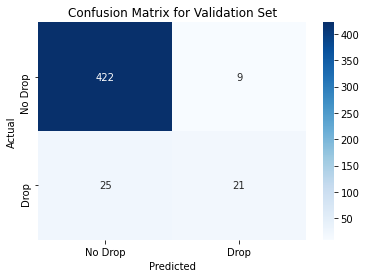

In [106]:
# Generate the confusion matrix
cm_val_1 = confusion_matrix(y_val, y_pred_val_custom_thresh_1)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6,4))
sns.heatmap(cm_val_1, annot=True, fmt='d', cmap='Blues', xticklabels=['No Drop', 'Drop'], yticklabels=['No Drop', 'Drop'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for Validation Set')
plt.show()

### Evaluate the Model on the Test Set

In [107]:
# Step 1: Predict probabilities for the test set
y_test_proba_1 = best_rf_1.predict_proba(X_test)[:, 1]  # Probability estimates for class 1

# Step 2: Apply the same custom threshold for class 1 predictions
y_pred_test_custom_thresh_1 = (y_test_proba_1 >= threshold).astype(int)

# Step 3: Evaluate model performance on the test set with the custom threshold

# Test performance
print("Test Accuracy:", accuracy_score(y_test, y_pred_test_custom_thresh_1))
print("Test Precision:", precision_score(y_test, y_pred_test_custom_thresh_1))
print("Test Recall:", recall_score(y_test, y_pred_test_custom_thresh_1))
print("\nTest Classification Report:\n", classification_report(y_test, y_pred_test_custom_thresh_1))

Test Accuracy: 0.9294605809128631
Test Precision: 0.7142857142857143
Test Recall: 0.43478260869565216

Test Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96       218
           1       0.71      0.43      0.54        23

    accuracy                           0.93       241
   macro avg       0.83      0.71      0.75       241
weighted avg       0.92      0.93      0.92       241



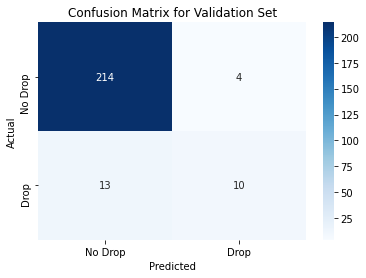

In [108]:
# Generate the confusion matrix
cm_test_1 = confusion_matrix(y_test, y_pred_test_custom_thresh_1)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6,4))
sns.heatmap(cm_test_1, annot=True, fmt='d', cmap='Blues', xticklabels=['No Drop', 'Drop'], yticklabels=['No Drop', 'Drop'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for Validation Set')
plt.show()

### Saving Predictive Model for Cluster 1

In [109]:
# Set the path to your Desktop
desktop_path = os.path.join(os.path.expanduser("~"), "Desktop/Python Works/LongShort Strategy", "best_rf_1_model.pkl")

# Save the model to the specified path
with open(desktop_path, 'wb') as file:
    pickle.dump(best_rf_1, file)

## Develop Predictive Model for Cluster 2

### Select candidate for the model

In [110]:
cluster_2_list = cluster_2.to_list()

In [111]:
# Filter the dataframe for rows where the 'Symbol' is in cluster_2_list
cluster_2_df = sp500_table[sp500_table['Symbol'].isin(cluster_2_list)]

# Sort the dataframe by the 'Date added' column in ascending order
cluster_2_df = cluster_2_df.sort_values(by='Date added', ascending=True)

# Show the first 5 values of cluster_df_2
cluster_2_df.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
223,HAL,Halliburton,Energy,Oil & Gas Equipment & Services,"Houston, Texas",1957-03-04,45012,1919
411,SLB,Schlumberger,Energy,Oil & Gas Equipment & Services,"Houston, Texas",1957-03-04,87347,1926
353,OXY,Occidental Petroleum,Energy,Oil & Gas Exploration & Production,"Houston, Texas",1957-03-04,797468,1920
102,CVX,Chevron Corporation,Energy,Integrated Oil & Gas,"San Ramon, California",1957-03-04,93410,1879
120,COP,ConocoPhillips,Energy,Oil & Gas Exploration & Production,"Houston, Texas",1957-03-04,1163165,2002


In [112]:
# Create dataframe to be used in the ML model based on the selected company
cluster_2_candidate = sp500_data[cluster_2_df.iloc[0,0]]

In [113]:
cluster_2_candidate.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-29,64.900002,65.790001,64.459999,65.610001,54.760490,8432300.0
2014-09-30,65.290001,66.250000,63.930000,64.510002,53.842396,8893200.0
2014-10-01,64.629997,64.879997,62.080002,62.470001,52.139729,9728700.0
2014-10-02,61.900002,61.930000,59.669998,61.439999,51.280060,15763100.0
2014-10-03,62.259998,62.279999,60.639999,61.860001,51.630611,7214700.0


In [114]:
cluster_2_candidate.fillna(method='ffill', inplace=True)
cluster_2_candidate.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2499 entries, 2014-09-29 to 2024-08-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2499 non-null   float64
 1   High       2499 non-null   float64
 2   Low        2499 non-null   float64
 3   Close      2499 non-null   float64
 4   Adj Close  2499 non-null   float64
 5   Volume     2499 non-null   float64
dtypes: float64(6)
memory usage: 136.7 KB


### Calculate technical indicators

In [115]:
# Apply add_technical_indicators function to candidate dataframe
cluster_2_ta = add_technical_indicators(cluster_2_candidate.copy())

In [116]:
# Display first 5 rows of dataframe
cluster_2_ta.head()

,Open,High,Low,Close,Adj Close,Volume,upperband,middleband,lowerband,EMA,...,CDLHAMMER,CDLHANGINGMAN,CDLHARAMI,CDLHIKKAKE,CDLMORNINGDOJISTAR,CDLMORNINGSTAR,CDLPIERCING,CDLSPINNINGTOP,CDLMARUBOZU,CDLINVERTEDHAMMER
Date,,,,,,,,,,,,,,,,,,,,,
2014-09-29,64.900002,65.790001,64.459999,65.610001,54.760490,8432300.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2014-09-30,65.290001,66.250000,63.930000,64.510002,53.842396,8893200.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2014-10-01,64.629997,64.879997,62.080002,62.470001,52.139729,9728700.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2014-10-02,61.900002,61.930000,59.669998,61.439999,51.280060,15763100.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2014-10-03,62.259998,62.279999,60.639999,61.860001,51.630611,7214700.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [117]:
cluster_2_ta.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2499 entries, 2014-09-29 to 2024-08-30
Data columns (total 41 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Open                2499 non-null   float64
 1   High                2499 non-null   float64
 2   Low                 2499 non-null   float64
 3   Close               2499 non-null   float64
 4   Adj Close           2499 non-null   float64
 5   Volume              2499 non-null   float64
 6   upperband           2480 non-null   float64
 7   middleband          2480 non-null   float64
 8   lowerband           2480 non-null   float64
 9   EMA                 2486 non-null   float64
 10  KAMA                2469 non-null   float64
 11  SAR                 2498 non-null   float64
 12  ADX                 2472 non-null   float64
 13  AROONOSC            2485 non-null   float64
 14  MFI                 2485 non-null   float64
 15  MOM                 2489 non-null   f

### Populate the label column

In [118]:
cluster_2_ta = create_short_sell_target(cluster_2_ta, 
                                        price_drop_threshold=-0.05, 
                                        upward_move_threshold=0.03, 
                                        N=20)


cluster_2_ta.head()

,Open,High,Low,Close,Adj Close,Volume,upperband,middleband,lowerband,EMA,...,CDLHANGINGMAN,CDLHARAMI,CDLHIKKAKE,CDLMORNINGDOJISTAR,CDLMORNINGSTAR,CDLPIERCING,CDLSPINNINGTOP,CDLMARUBOZU,CDLINVERTEDHAMMER,Target
Date,,,,,,,,,,,,,,,,,,,,,
2014-09-29,64.900002,65.790001,64.459999,65.610001,54.760490,8432300.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1
2014-09-30,65.290001,66.250000,63.930000,64.510002,53.842396,8893200.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1
2014-10-01,64.629997,64.879997,62.080002,62.470001,52.139729,9728700.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1
2014-10-02,61.900002,61.930000,59.669998,61.439999,51.280060,15763100.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1
2014-10-03,62.259998,62.279999,60.639999,61.860001,51.630611,7214700.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1


In [119]:
target_count = cluster_2_ta['Target'].sum()
print(f"Number of times Target is equal to 1: {target_count}")

Number of times Target is equal to 1: 610


In [120]:
# Remove rows with NaN values
cluster_2_ta.dropna(axis=0, inplace=True)
cluster_2_ta.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2469 entries, 2014-11-10 to 2024-08-30
Data columns (total 42 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Open                2469 non-null   float64
 1   High                2469 non-null   float64
 2   Low                 2469 non-null   float64
 3   Close               2469 non-null   float64
 4   Adj Close           2469 non-null   float64
 5   Volume              2469 non-null   float64
 6   upperband           2469 non-null   float64
 7   middleband          2469 non-null   float64
 8   lowerband           2469 non-null   float64
 9   EMA                 2469 non-null   float64
 10  KAMA                2469 non-null   float64
 11  SAR                 2469 non-null   float64
 12  ADX                 2469 non-null   float64
 13  AROONOSC            2469 non-null   float64
 14  MFI                 2469 non-null   float64
 15  MOM                 2469 non-null   f

In [121]:
cluster_2_ta.head()

,Open,High,Low,Close,Adj Close,Volume,upperband,middleband,lowerband,EMA,...,CDLHANGINGMAN,CDLHARAMI,CDLHIKKAKE,CDLMORNINGDOJISTAR,CDLMORNINGSTAR,CDLPIERCING,CDLSPINNINGTOP,CDLMARUBOZU,CDLINVERTEDHAMMER,Target
Date,,,,,,,,,,,,,,,,,,,,,
2014-11-10,55.009998,55.599998,53.259998,53.630001,44.761547,10217700.0,47.305030,44.481940,41.658850,45.020528,...,0,0,0,0,0,0,0,0,0,1
2014-11-11,53.939999,54.029999,52.279999,53.720001,44.836666,10705200.0,47.103551,44.652624,42.201697,44.996013,...,0,0,0,0,0,0,0,-100,0,1
2014-11-12,53.220001,54.540001,52.849998,53.230000,44.427689,9600000.0,46.958714,44.760709,42.562704,44.920237,...,0,0,0,0,0,0,0,0,0,0
2014-11-13,52.830002,58.000000,50.770000,53.790001,44.895092,35987500.0,46.856142,44.870046,42.883951,44.916884,...,0,0,0,0,0,0,0,0,0,1
2014-11-14,56.029999,56.259998,53.689999,55.080002,45.971779,25499000.0,46.962768,44.973542,42.984317,45.057537,...,0,0,0,0,0,0,0,-100,0,1


In [122]:
cluster_2_ta.tail()

,Open,High,Low,Close,Adj Close,Volume,upperband,middleband,lowerband,EMA,...,CDLHANGINGMAN,CDLHARAMI,CDLHIKKAKE,CDLMORNINGDOJISTAR,CDLMORNINGSTAR,CDLPIERCING,CDLSPINNINGTOP,CDLMARUBOZU,CDLINVERTEDHAMMER,Target
Date,,,,,,,,,,,,,,,,,,,,,
2024-08-26,32.310001,32.450001,31.67,31.870001,31.688496,4848700.0,33.655019,31.506537,29.358055,31.443993,...,0,0,0,0,0,0,0,0,0,0
2024-08-27,31.840000,31.940001,31.27,31.620001,31.439920,5710500.0,33.160983,31.373300,29.585618,31.443450,...,0,0,0,0,0,0,0,0,0,0
2024-08-28,31.219999,31.280001,30.82,31.000000,30.823450,6303400.0,32.280751,31.190348,30.099946,31.360783,...,0,0,-200,0,0,0,0,-100,0,0
2024-08-29,31.370001,31.549999,30.83,31.379999,31.201284,5204400.0,31.778041,31.097878,30.417715,31.339517,...,0,0,0,0,0,0,-100,0,0,0
2024-08-30,31.080000,31.270000,30.75,31.090000,30.912937,11287300.0,31.698515,31.061586,30.424656,31.282639,...,0,0,0,0,0,0,0,0,0,0


### Augment features space

In [123]:
# Select the first 19 columns for lag and rolling statistics
columns_to_transform = cluster_2_ta.columns[:19]

# Create lagged features (lag by 20 and 60 days)
for lag in [20, 60]:
    for column in columns_to_transform:
        cluster_2_ta[f'{column}_lag_{lag}'] = cluster_2_ta[column].shift(lag)

# Create rolling statistics (mean and std over the past 20 and 60 days)
for window in [20, 60]:
    for column in columns_to_transform:
        cluster_2_ta[f'{column}_rolling_mean_{window}'] = cluster_2_ta[column].rolling(window=window).mean()
        cluster_2_ta[f'{column}_rolling_std_{window}'] = cluster_2_ta[column].rolling(window=window).std()

# Add the day of the week as a feature
cluster_2_ta['day_of_week'] = cluster_2_ta.index.dayofweek

cluster_2_ta.head()

,Open,High,Low,Close,Adj Close,Volume,upperband,middleband,lowerband,EMA,...,MFI_rolling_std_60,MOM_rolling_mean_60,MOM_rolling_std_60,ROC_rolling_mean_60,ROC_rolling_std_60,RSI_rolling_mean_60,RSI_rolling_std_60,OBV_rolling_mean_60,OBV_rolling_std_60,day_of_week
Date,,,,,,,,,,,,,,,,,,,,,
2014-11-10,55.009998,55.599998,53.259998,53.630001,44.761547,10217700.0,47.305030,44.481940,41.658850,45.020528,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2014-11-11,53.939999,54.029999,52.279999,53.720001,44.836666,10705200.0,47.103551,44.652624,42.201697,44.996013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2014-11-12,53.220001,54.540001,52.849998,53.230000,44.427689,9600000.0,46.958714,44.760709,42.562704,44.920237,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
2014-11-13,52.830002,58.000000,50.770000,53.790001,44.895092,35987500.0,46.856142,44.870046,42.883951,44.916884,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
2014-11-14,56.029999,56.259998,53.689999,55.080002,45.971779,25499000.0,46.962768,44.973542,42.984317,45.057537,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4


In [124]:
# Drop rows with NaN values
cluster_2_ta = cluster_2_ta.dropna()

In [125]:
# Calculate the new total number of features and the length of the cleaned dataframe
num_features = cluster_2_ta.shape[1]
num_rows = cluster_2_ta.shape[0]

num_features, num_rows

(157, 2409)

In [126]:
cluster_2_ta.head()

,Open,High,Low,Close,Adj Close,Volume,upperband,middleband,lowerband,EMA,...,MFI_rolling_std_60,MOM_rolling_mean_60,MOM_rolling_std_60,ROC_rolling_mean_60,ROC_rolling_std_60,RSI_rolling_mean_60,RSI_rolling_std_60,OBV_rolling_mean_60,OBV_rolling_std_60,day_of_week
Date,,,,,,,,,,,,,,,,,,,,,
2015-02-06,44.099998,44.340000,43.130001,43.360001,36.352036,18303200.0,36.834990,33.940865,31.046740,34.767690,...,16.470086,-1.628178,3.556402,-3.623890,8.760971,38.149666,11.133095,-2.536644e+08,1.037984e+08,4
2015-02-09,43.669998,44.349998,43.410000,43.509998,36.477783,15968700.0,37.178694,34.096383,31.014073,34.995702,...,16.676604,-1.605932,3.573335,-3.555875,8.812091,38.524304,11.557654,-2.557813e+08,1.004398e+08,0
2015-02-10,43.439999,43.439999,42.049999,42.599998,35.714870,21869900.0,37.311440,34.266573,31.221707,35.091591,...,16.720946,-1.574008,3.587431,-3.475253,8.846889,38.826629,11.791600,-2.581026e+08,9.695232e+07,1
2015-02-11,42.020000,42.320000,41.610001,42.150002,35.337597,15847500.0,37.336707,34.428380,31.520053,35.124392,...,16.485675,-1.534753,3.616508,-3.358070,8.936565,39.047603,11.952050,-2.612878e+08,9.149903e+07,2
2015-02-12,42.650002,43.349998,42.500000,42.770000,35.857395,12946600.0,37.386193,34.614080,31.841967,35.222126,...,15.931087,-1.489205,3.652553,-3.221474,9.049001,39.233564,12.144169,-2.646823e+08,8.438880e+07,3


In [127]:
cluster_2_ta.tail()

,Open,High,Low,Close,Adj Close,Volume,upperband,middleband,lowerband,EMA,...,MFI_rolling_std_60,MOM_rolling_mean_60,MOM_rolling_std_60,ROC_rolling_mean_60,ROC_rolling_std_60,RSI_rolling_mean_60,RSI_rolling_std_60,OBV_rolling_mean_60,OBV_rolling_std_60,day_of_week
Date,,,,,,,,,,,,,,,,,,,,,
2024-08-26,32.310001,32.450001,31.67,31.870001,31.688496,4848700.0,33.655019,31.506537,29.358055,31.443993,...,10.701360,-0.867272,1.657553,-2.421599,4.780671,42.073212,8.154576,-3.167333e+08,4.486090e+07,0
2024-08-27,31.840000,31.940001,31.27,31.620001,31.439920,5710500.0,33.160983,31.373300,29.585618,31.443450,...,10.702506,-0.845627,1.667273,-2.358501,4.810134,42.071587,8.153866,-3.150129e+08,4.433219e+07,1
2024-08-28,31.219999,31.280001,30.82,31.000000,30.823450,6303400.0,32.280751,31.190348,30.099946,31.360783,...,10.767129,-0.791369,1.644615,-2.212521,4.758226,42.196674,8.075161,-3.132646e+08,4.342675e+07,2
2024-08-29,31.370001,31.549999,30.83,31.379999,31.201284,5204400.0,31.778041,31.097878,30.417715,31.339517,...,10.708394,-0.722274,1.591787,-2.027617,4.633803,42.447407,7.908068,-3.112862e+08,4.220914e+07,3
2024-08-30,31.080000,31.270000,30.75,31.090000,30.912937,11287300.0,31.698515,31.061586,30.424656,31.282639,...,10.802683,-0.661437,1.535539,-1.866693,4.497425,42.676285,7.698504,-3.093627e+08,4.043385e+07,4


### Feature engineering

In [128]:
# Separate features and target
X_2 = cluster_2_ta.drop(columns=['Target'])
y_2 = cluster_2_ta['Target']

In [129]:
# Compute correlation matrix
correlation_matrix = X_2.corr()

# Find highly correlated features
threshold = 0.8
high_corr_pairs = correlation_matrix[(correlation_matrix > threshold) & (correlation_matrix < 1.0)]
high_corr_pairs.dropna(how='all', inplace=True)  # Remove NaN rows

In [130]:
high_corr_pairs

,Open,High,Low,Close,Adj Close,Volume,upperband,middleband,lowerband,EMA,...,MFI_rolling_std_60,MOM_rolling_mean_60,MOM_rolling_std_60,ROC_rolling_mean_60,ROC_rolling_std_60,RSI_rolling_mean_60,RSI_rolling_std_60,OBV_rolling_mean_60,OBV_rolling_std_60,day_of_week
Open,NaN,0.999235,0.999205,0.998378,0.984375,NaN,0.958205,0.971602,0.969855,0.980156,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
High,0.999235,NaN,0.999130,0.999322,0.985403,NaN,0.957894,0.970722,0.968406,0.979535,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Low,0.999205,0.999130,NaN,0.999311,0.985085,NaN,0.955939,0.969956,0.968872,0.978831,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Close,0.998378,0.999322,0.999311,NaN,0.986026,NaN,0.956084,0.969446,0.967697,0.978501,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Adj Close,0.984375,0.985403,0.985085,0.986026,NaN,NaN,0.970269,0.981221,0.976814,0.991022,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MFI_rolling_mean_60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MOM_rolling_mean_60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.905766,NaN,0.931812,NaN,NaN,NaN,NaN
ROC_rolling_mean_60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.905766,NaN,NaN,NaN,0.828299,NaN,NaN,NaN,NaN
RSI_rolling_mean_60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.931812,NaN,0.828299,NaN,NaN,NaN,NaN,NaN,NaN


In [131]:
# Step 1: Split the dataset into training + validation (90%) and test set (10%)
X_train_val, X_test, y_train_val, y_test = train_test_split(X_2, y_2, test_size=0.10, random_state=42, stratify=y_2)

# Step 2: Split the training + validation set into training (70%) and validation (20%)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.22, random_state=42, stratify=y_train_val)  # 22% to get 20% of the original dataset

# Verify the shapes of the partitions
print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}")

Training set: (1691, 156), Validation set: (477, 156), Test set: (241, 156)


### Train Random Forest Model

In [132]:
# Define the Random Forest model
rf_2 = RandomForestClassifier(random_state=42, class_weight='balanced')  # Handle class imbalance by assigning weights

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [200],  # Number of trees in the forest
    'max_depth': [6],  # Maximum depth of the tree
    'max_features': ['sqrt', 'log2'],  # Number of features to consider at each split
    'min_samples_leaf': [15],  # This ensures that leaf nodes contain more samples
    'min_samples_split': [90]  # This controls how many samples a node must have before it can be split
}

# Set up StratifiedKFold for cross-validation to preserve class distribution
tscv = TimeSeriesSplit(n_splits=5)

# Set up GridSearchCV with cross-validation only on the training data, using precision score for imbalanced data
grid_search_2 = GridSearchCV(estimator=rf_2, param_grid=param_grid, 
                           cv=tscv, scoring='precision', n_jobs=-1, verbose=2)

# Fit the model using GridSearchCV on the training data
grid_search_2.fit(X_train, y_train)

# Get the best parameters from GridSearchCV
best_params_2 = grid_search_2.best_params_
print("Best Hyperparameters:", best_params_2)
print('---------------------------------------------------------------')

# Train the Random Forest with the best hyperparameters on the training data
best_rf_2 = RandomForestClassifier(**best_params_2, random_state=42, class_weight='balanced')
best_rf_2.fit(X_train, y_train)

# Step 1: Predict probabilities instead of hard class labels
y_train_proba_2 = best_rf_2.predict_proba(X_train)[:, 1]  # Probability estimates for class 1
y_val_proba_2 = best_rf_2.predict_proba(X_val)[:, 1]

# Step 2: Apply a custom threshold for class 1 predictions
threshold = 0.7  # Adjust this value to increase precision for class 1
y_pred_train_custom_thresh_2 = (y_train_proba_2 >= threshold).astype(int)
y_pred_val_custom_thresh_2 = (y_val_proba_2 >= threshold).astype(int)

# Step 3: Evaluate model performance with the custom threshold

# Training performance
print("Training Accuracy:", accuracy_score(y_train, y_pred_train_custom_thresh_2))
print("Training Precision:", precision_score(y_train, y_pred_train_custom_thresh_2))
print("Training Recall:", recall_score(y_train, y_pred_train_custom_thresh_2))
print("\nTraining Classification Report:\n", classification_report(y_train, y_pred_train_custom_thresh_2))
print('---------------------------------------------------------------')

# Validation performance
print("Validation Accuracy:", accuracy_score(y_val, y_pred_val_custom_thresh_2))
print("Validation Precision:", precision_score(y_val, y_pred_val_custom_thresh_2))
print("Validation Recall:", recall_score(y_val, y_pred_val_custom_thresh_2))
print("\nValidation Classification Report:\n", classification_report(y_val, y_pred_val_custom_thresh_2))

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best Hyperparameters: {'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 15, 'min_samples_split': 90, 'n_estimators': 200}
---------------------------------------------------------------
Training Accuracy: 0.8089887640449438
Training Precision: 0.9038461538461539
Training Recall: 0.23095823095823095

Training Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.99      0.89      1284
           1       0.90      0.23      0.37       407

    accuracy                           0.81      1691
   macro avg       0.85      0.61      0.63      1691
weighted avg       0.83      0.81      0.76      1691

---------------------------------------------------------------
Validation Accuracy: 0.7840670859538784
Validation Precision: 0.875
Validation Recall: 0.12173913043478261

Validation Classification Report:
               precision    recall  f1-score   support

      

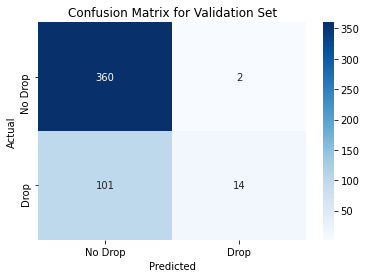

In [133]:
# Generate the confusion matrix
cm_val_2 = confusion_matrix(y_val, y_pred_val_custom_thresh_2)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6,4))
sns.heatmap(cm_val_2, annot=True, fmt='d', cmap='Blues', xticklabels=['No Drop', 'Drop'], yticklabels=['No Drop', 'Drop'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for Validation Set')
plt.show()

### Evaluate the Model on the Test Set

In [134]:
# Step 1: Predict probabilities for the test set
y_test_proba_2 = best_rf_2.predict_proba(X_test)[:, 1]  # Probability estimates for class 1

# Step 2: Apply the same custom threshold for class 1 predictions
y_pred_test_custom_thresh_2 = (y_test_proba_2 >= threshold).astype(int)

# Step 3: Evaluate model performance on the test set with the custom threshold

# Test performance
print("Test Accuracy:", accuracy_score(y_test, y_pred_test_custom_thresh_2))
print("Test Precision:", precision_score(y_test, y_pred_test_custom_thresh_2))
print("Test Recall:", recall_score(y_test, y_pred_test_custom_thresh_2))
print("\nTest Classification Report:\n", classification_report(y_test, y_pred_test_custom_thresh_2))

Test Accuracy: 0.7925311203319502
Test Precision: 0.9
Test Recall: 0.15517241379310345

Test Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.99      0.88       183
           1       0.90      0.16      0.26        58

    accuracy                           0.79       241
   macro avg       0.84      0.57      0.57       241
weighted avg       0.81      0.79      0.73       241



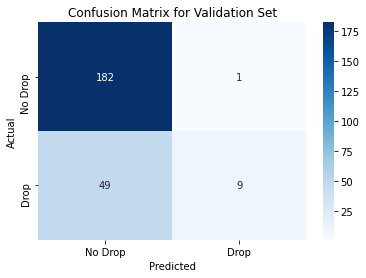

In [135]:
# Generate the confusion matrix
cm_test_2 = confusion_matrix(y_test, y_pred_test_custom_thresh_2)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6,4))
sns.heatmap(cm_test_2, annot=True, fmt='d', cmap='Blues', xticklabels=['No Drop', 'Drop'], yticklabels=['No Drop', 'Drop'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for Validation Set')
plt.show()

### Saving Predictive Model for Cluster 2

In [136]:
# Set the path to your Desktop
desktop_path = os.path.join(os.path.expanduser("~"), "Desktop/Python Works/LongShort Strategy", "best_rf_2_model.pkl")

# Save the model to the specified path
with open(desktop_path, 'wb') as file:
    pickle.dump(best_rf_2, file)

## Develop Predictive Model for Cluster 3

### Select candidate for the model

In [137]:
cluster_3_list = cluster_3.to_list()

In [138]:
# Filter the dataframe for rows where the 'Symbol' is in cluster_3_list
cluster_3_df = sp500_table[sp500_table['Symbol'].isin(cluster_3_list)]

# Sort the dataframe by the 'Date added' column in ascending order
cluster_3_df = cluster_3_df.sort_values(by='Date added', ascending=True)

# Show the first 5 values of cluster_df_3
cluster_3_df.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
312,MRK,Merck & Co.,Health Care,Pharmaceuticals,"Kenilworth, New Jersey",1957-03-04,310158,1891
114,CMS,CMS Energy,Utilities,Multi-Utilities,"Jackson, Michigan",1957-03-04,811156,1886
115,KO,Coca-Cola Company (The),Consumer Staples,Soft Drinks & Non-alcoholic Beverages,"Atlanta, Georgia",1957-03-04,21344,1886
117,CL,Colgate-Palmolive,Consumer Staples,Household Products,"New York City, New York",1957-03-04,21665,1806


In [139]:
# Create dataframe to be used in the ML model based on the selected company
cluster_3_candidate = sp500_data[cluster_3_df.iloc[0,0]]

In [140]:
cluster_3_candidate.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-29,41.669998,42.009998,41.669998,41.900002,34.608658,4881100.0
2014-09-30,41.799999,41.990002,41.590000,41.590000,34.352604,4874800.0
2014-10-01,42.049999,42.060001,41.009998,41.180000,34.013950,5573800.0
2014-10-02,41.220001,41.450001,40.910000,41.209999,34.038727,4707100.0
2014-10-03,41.410000,41.860001,41.279999,41.790001,34.517792,3430900.0


In [141]:
cluster_3_candidate.fillna(method='ffill', inplace=True)
cluster_3_candidate.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2499 entries, 2014-09-29 to 2024-08-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2499 non-null   float64
 1   High       2499 non-null   float64
 2   Low        2499 non-null   float64
 3   Close      2499 non-null   float64
 4   Adj Close  2499 non-null   float64
 5   Volume     2499 non-null   float64
dtypes: float64(6)
memory usage: 136.7 KB


### Calculate technical indicators

In [142]:
# Apply add_technical_indicators function to candidate dataframe
cluster_3_ta = add_technical_indicators(cluster_3_candidate.copy())

In [143]:
# Display first 5 rows of dataframe
cluster_3_ta.head()

,Open,High,Low,Close,Adj Close,Volume,upperband,middleband,lowerband,EMA,...,CDLHAMMER,CDLHANGINGMAN,CDLHARAMI,CDLHIKKAKE,CDLMORNINGDOJISTAR,CDLMORNINGSTAR,CDLPIERCING,CDLSPINNINGTOP,CDLMARUBOZU,CDLINVERTEDHAMMER
Date,,,,,,,,,,,,,,,,,,,,,
2014-09-29,41.669998,42.009998,41.669998,41.900002,34.608658,4881100.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2014-09-30,41.799999,41.990002,41.590000,41.590000,34.352604,4874800.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2014-10-01,42.049999,42.060001,41.009998,41.180000,34.013950,5573800.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2014-10-02,41.220001,41.450001,40.910000,41.209999,34.038727,4707100.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2014-10-03,41.410000,41.860001,41.279999,41.790001,34.517792,3430900.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [144]:
cluster_3_ta.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2499 entries, 2014-09-29 to 2024-08-30
Data columns (total 41 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Open                2499 non-null   float64
 1   High                2499 non-null   float64
 2   Low                 2499 non-null   float64
 3   Close               2499 non-null   float64
 4   Adj Close           2499 non-null   float64
 5   Volume              2499 non-null   float64
 6   upperband           2480 non-null   float64
 7   middleband          2480 non-null   float64
 8   lowerband           2480 non-null   float64
 9   EMA                 2486 non-null   float64
 10  KAMA                2469 non-null   float64
 11  SAR                 2498 non-null   float64
 12  ADX                 2472 non-null   float64
 13  AROONOSC            2485 non-null   float64
 14  MFI                 2485 non-null   float64
 15  MOM                 2489 non-null   f

### Populate the label column

In [145]:
cluster_3_ta = create_short_sell_target(cluster_3_ta, 
                                        price_drop_threshold=-0.05, 
                                        upward_move_threshold=0.03, 
                                        N=20)


cluster_3_ta.head()

,Open,High,Low,Close,Adj Close,Volume,upperband,middleband,lowerband,EMA,...,CDLHANGINGMAN,CDLHARAMI,CDLHIKKAKE,CDLMORNINGDOJISTAR,CDLMORNINGSTAR,CDLPIERCING,CDLSPINNINGTOP,CDLMARUBOZU,CDLINVERTEDHAMMER,Target
Date,,,,,,,,,,,,,,,,,,,,,
2014-09-29,41.669998,42.009998,41.669998,41.900002,34.608658,4881100.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2014-09-30,41.799999,41.990002,41.590000,41.590000,34.352604,4874800.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2014-10-01,42.049999,42.060001,41.009998,41.180000,34.013950,5573800.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2014-10-02,41.220001,41.450001,40.910000,41.209999,34.038727,4707100.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2014-10-03,41.410000,41.860001,41.279999,41.790001,34.517792,3430900.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [146]:
target_count = cluster_3_ta['Target'].sum()
print(f"Number of times Target is equal to 1: {target_count}")

Number of times Target is equal to 1: 350


In [147]:
# Remove rows with NaN values
cluster_3_ta.dropna(axis=0, inplace=True)
cluster_3_ta.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2469 entries, 2014-11-10 to 2024-08-30
Data columns (total 42 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Open                2469 non-null   float64
 1   High                2469 non-null   float64
 2   Low                 2469 non-null   float64
 3   Close               2469 non-null   float64
 4   Adj Close           2469 non-null   float64
 5   Volume              2469 non-null   float64
 6   upperband           2469 non-null   float64
 7   middleband          2469 non-null   float64
 8   lowerband           2469 non-null   float64
 9   EMA                 2469 non-null   float64
 10  KAMA                2469 non-null   float64
 11  SAR                 2469 non-null   float64
 12  ADX                 2469 non-null   float64
 13  AROONOSC            2469 non-null   float64
 14  MFI                 2469 non-null   float64
 15  MOM                 2469 non-null   f

In [148]:
cluster_3_ta.head()

,Open,High,Low,Close,Adj Close,Volume,upperband,middleband,lowerband,EMA,...,CDLHANGINGMAN,CDLHARAMI,CDLHIKKAKE,CDLMORNINGDOJISTAR,CDLMORNINGSTAR,CDLPIERCING,CDLSPINNINGTOP,CDLMARUBOZU,CDLINVERTEDHAMMER,Target
Date,,,,,,,,,,,,,,,,,,,,,
2014-11-10,43.349998,44.099998,43.169998,44.090000,36.611038,5318900.0,37.238673,35.229298,33.219922,35.791617,...,0,100,0,0,0,0,0,0,0,0
2014-11-11,44.119999,44.630001,44.099998,44.250000,36.743889,3192600.0,37.403530,35.361741,33.319952,35.918587,...,0,0,0,0,0,0,0,0,0,0
2014-11-12,44.189999,44.299999,43.939999,44.230000,36.727280,3486000.0,37.408929,35.536949,33.664970,36.026413,...,0,0,0,0,0,0,0,0,0,0
2014-11-13,44.279999,44.770000,44.209999,44.590000,37.026222,3488800.0,37.375906,35.727935,34.079963,36.159721,...,0,0,0,0,0,0,0,0,0,0
2014-11-14,44.590000,44.590000,43.680000,43.810001,36.378536,4206000.0,37.297199,35.850414,34.403629,36.188896,...,0,0,0,0,0,0,0,-100,0,0


In [149]:
cluster_3_ta.tail()

,Open,High,Low,Close,Adj Close,Volume,upperband,middleband,lowerband,EMA,...,CDLHANGINGMAN,CDLHARAMI,CDLHIKKAKE,CDLMORNINGDOJISTAR,CDLMORNINGSTAR,CDLPIERCING,CDLSPINNINGTOP,CDLMARUBOZU,CDLINVERTEDHAMMER,Target
Date,,,,,,,,,,,,,,,,,,,,,
2024-08-26,112.739998,113.260002,112.059998,112.699997,112.699997,3212700.0,113.903737,109.9340,105.964263,110.676792,...,0,0,0,0,0,0,-100,0,0,0
2024-08-27,113.059998,113.169998,112.139999,113.099998,113.099998,2705300.0,113.914718,110.3230,106.731282,110.999887,...,-100,0,0,0,0,0,100,0,0,0
2024-08-28,113.099998,113.419998,112.370003,112.900002,112.900002,3836700.0,113.817756,110.6710,107.524244,111.253235,...,0,0,-100,0,0,0,-100,0,0,0
2024-08-29,113.300003,113.500000,112.519997,112.760002,112.760002,3375800.0,114.065309,110.8015,107.537691,111.454138,...,0,0,0,0,0,0,0,0,0,0
2024-08-30,113.000000,113.470001,111.889999,113.269997,113.269997,4320100.0,114.331848,110.8995,107.467151,111.696252,...,0,100,0,0,0,0,0,0,0,0


### Augment features space

In [150]:
# Select the first 19 columns for lag and rolling statistics
columns_to_transform = cluster_3_ta.columns[:19]

# Create lagged features (lag by 20 and 60 days)
for lag in [20, 60]:
    for column in columns_to_transform:
        cluster_3_ta[f'{column}_lag_{lag}'] = cluster_3_ta[column].shift(lag)

# Create rolling statistics (mean and std over the past 20 and 60 days)
for window in [20, 60]:
    for column in columns_to_transform:
        cluster_3_ta[f'{column}_rolling_mean_{window}'] = cluster_3_ta[column].rolling(window=window).mean()
        cluster_3_ta[f'{column}_rolling_std_{window}'] = cluster_3_ta[column].rolling(window=window).std()

# Add the day of the week as a feature
cluster_3_ta['day_of_week'] = cluster_3_ta.index.dayofweek

cluster_3_ta.head()

,Open,High,Low,Close,Adj Close,Volume,upperband,middleband,lowerband,EMA,...,MFI_rolling_std_60,MOM_rolling_mean_60,MOM_rolling_std_60,ROC_rolling_mean_60,ROC_rolling_std_60,RSI_rolling_mean_60,RSI_rolling_std_60,OBV_rolling_mean_60,OBV_rolling_std_60,day_of_week
Date,,,,,,,,,,,,,,,,,,,,,
2014-11-10,43.349998,44.099998,43.169998,44.090000,36.611038,5318900.0,37.238673,35.229298,33.219922,35.791617,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2014-11-11,44.119999,44.630001,44.099998,44.250000,36.743889,3192600.0,37.403530,35.361741,33.319952,35.918587,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2014-11-12,44.189999,44.299999,43.939999,44.230000,36.727280,3486000.0,37.408929,35.536949,33.664970,36.026413,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
2014-11-13,44.279999,44.770000,44.209999,44.590000,37.026222,3488800.0,37.375906,35.727935,34.079963,36.159721,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
2014-11-14,44.590000,44.590000,43.680000,43.810001,36.378536,4206000.0,37.297199,35.850414,34.403629,36.188896,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4


In [151]:
# Drop rows with NaN values
cluster_3_ta = cluster_3_ta.dropna()

In [152]:
# Calculate the new total number of features and the length of the cleaned dataframe
num_features = cluster_3_ta.shape[1]
num_rows = cluster_3_ta.shape[0]

num_features, num_rows

(157, 2409)

In [153]:
cluster_3_ta.head()

,Open,High,Low,Close,Adj Close,Volume,upperband,middleband,lowerband,EMA,...,MFI_rolling_std_60,MOM_rolling_mean_60,MOM_rolling_std_60,ROC_rolling_mean_60,ROC_rolling_std_60,RSI_rolling_mean_60,RSI_rolling_std_60,OBV_rolling_mean_60,OBV_rolling_std_60,day_of_week
Date,,,,,,,,,,,,,,,,,,,,,
2015-02-06,45.590000,46.209999,45.330002,45.500000,37.981850,5601600.0,38.403253,37.268208,36.133163,37.522640,...,11.059293,0.235061,0.906390,0.669544,2.455893,55.133361,7.664168,3.698711e+07,8.168855e+06,4
2015-02-09,45.209999,45.209999,44.299999,44.520000,37.163780,6585900.0,38.378985,37.249760,36.120534,37.474792,...,10.673325,0.215990,0.892254,0.614884,2.413988,54.864090,7.613989,3.661088e+07,8.403661e+06,0
2015-02-10,44.680000,45.009998,44.400002,44.919998,37.497681,5210500.0,38.334302,37.232229,36.130156,37.477844,...,10.449325,0.212621,0.888707,0.604094,2.402355,54.646803,7.527949,3.637960e+07,8.512649e+06,1
2015-02-11,44.880001,45.200001,44.560001,44.930000,37.506039,4302900.0,38.354115,37.245586,36.137056,37.481603,...,10.227397,0.218545,0.894623,0.620298,2.418783,54.388323,7.369340,3.616189e+07,8.507420e+06,2
2015-02-12,45.040001,45.250000,44.799999,45.220001,37.748116,4683700.0,38.406098,37.284820,36.163541,37.517138,...,10.056894,0.214944,0.895204,0.610413,2.420474,54.324333,7.360608,3.609233e+07,8.502567e+06,3


In [154]:
cluster_3_ta.tail()

,Open,High,Low,Close,Adj Close,Volume,upperband,middleband,lowerband,EMA,...,MFI_rolling_std_60,MOM_rolling_mean_60,MOM_rolling_std_60,ROC_rolling_mean_60,ROC_rolling_std_60,RSI_rolling_mean_60,RSI_rolling_std_60,OBV_rolling_mean_60,OBV_rolling_std_60,day_of_week
Date,,,,,,,,,,,,,,,,,,,,,
2024-08-26,112.739998,113.260002,112.059998,112.699997,112.699997,3212700.0,113.903737,109.9340,105.964263,110.676792,...,11.725481,1.408651,2.752093,1.361038,2.665618,52.905512,8.010858,8.152504e+08,1.624811e+07,0
2024-08-27,113.059998,113.169998,112.139999,113.099998,113.099998,2705300.0,113.914718,110.3230,106.731282,110.999887,...,11.630152,1.534082,2.734689,1.478464,2.645268,53.381640,7.941895,8.159235e+08,1.701229e+07,1
2024-08-28,113.099998,113.419998,112.370003,112.900002,112.900002,3836700.0,113.817756,110.6710,107.524244,111.253235,...,11.808539,1.604475,2.717066,1.543650,2.626973,53.774190,7.932329,8.164508e+08,1.758584e+07,2
2024-08-29,113.300003,113.500000,112.519997,112.760002,112.760002,3375800.0,114.065309,110.8015,107.537691,111.454138,...,12.281864,1.631160,2.711083,1.567440,2.621177,54.101947,7.956196,8.168572e+08,1.801047e+07,3
2024-08-30,113.000000,113.470001,111.889999,113.269997,113.269997,4320100.0,114.331848,110.8995,107.467151,111.696252,...,12.666456,1.664517,2.706342,1.597153,2.616230,54.472539,7.985568,8.173906e+08,1.855424e+07,4


### Feature engineering

In [155]:
# Separate features and target
X_3 = cluster_3_ta.drop(columns=['Target'])
y_3 = cluster_3_ta['Target']

In [156]:
# Compute correlation matrix
correlation_matrix = X_3.corr()

# Find highly correlated features
threshold = 0.8
high_corr_pairs = correlation_matrix[(correlation_matrix > threshold) & (correlation_matrix < 1.0)]
high_corr_pairs.dropna(how='all', inplace=True)  # Remove NaN rows

In [157]:
high_corr_pairs

,Open,High,Low,Close,Adj Close,Volume,upperband,middleband,lowerband,EMA,...,MFI_rolling_std_60,MOM_rolling_mean_60,MOM_rolling_std_60,ROC_rolling_mean_60,ROC_rolling_std_60,RSI_rolling_mean_60,RSI_rolling_std_60,OBV_rolling_mean_60,OBV_rolling_std_60,day_of_week
Open,NaN,0.999688,0.999670,0.999334,0.997471,NaN,0.992394,0.993625,0.991302,0.995876,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.968200,NaN,NaN
High,0.999688,NaN,0.999577,0.999690,0.997762,NaN,0.992696,0.993637,0.990997,0.995850,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.968814,NaN,NaN
Low,0.999670,0.999577,NaN,0.999698,0.997889,NaN,0.991860,0.993318,0.991247,0.995669,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.967540,NaN,NaN
Close,0.999334,0.999690,0.999698,NaN,0.998123,NaN,0.992112,0.993257,0.990842,0.995582,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.968191,NaN,NaN
Adj Close,0.997471,0.997762,0.997889,0.998123,NaN,NaN,0.994506,0.995863,0.993671,0.997962,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.974670,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MOM_rolling_std_60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ROC_rolling_mean_60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.920678,NaN,NaN,NaN,0.882187,NaN,NaN,NaN,NaN
RSI_rolling_mean_60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.816200,NaN,0.882187,NaN,NaN,NaN,NaN,NaN,NaN
OBV_rolling_mean_60,0.968200,0.968814,0.967540,0.968191,0.974670,NaN,0.976755,0.977324,0.974336,0.977220,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [158]:
# Step 1: Split the dataset into training + validation (90%) and test set (10%)
X_train_val, X_test, y_train_val, y_test = train_test_split(X_3, y_3, test_size=0.10, random_state=42, stratify=y_3)

# Step 2: Split the training + validation set into training (70%) and validation (20%)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.22, random_state=42, stratify=y_train_val)  # 22% to get 20% of the original dataset

# Verify the shapes of the partitions
print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}")

Training set: (1691, 156), Validation set: (477, 156), Test set: (241, 156)


### Train Random Forest Model

In [159]:
# Define the Random Forest model
rf_3 = RandomForestClassifier(random_state=42, class_weight='balanced')  # Handle class imbalance by assigning weights

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [200],  # Number of trees in the forest
    'max_depth': [6],  # Maximum depth of the tree
    'max_features': ['sqrt', 'log2'],  # Number of features to consider at each split
    'min_samples_leaf': [15],  # This ensures that leaf nodes contain more samples
    'min_samples_split': [90]  # This controls how many samples a node must have before it can be split
}

# Set up StratifiedKFold for cross-validation to preserve class distribution
tscv = TimeSeriesSplit(n_splits=5)

# Set up GridSearchCV with cross-validation only on the training data, using precision score for imbalanced data
grid_search_3 = GridSearchCV(estimator=rf_3, param_grid=param_grid, 
                           cv=tscv, scoring='precision', n_jobs=-1, verbose=2)

# Fit the model using GridSearchCV on the training data
grid_search_3.fit(X_train, y_train)

# Get the best parameters from GridSearchCV
best_params_3 = grid_search_3.best_params_
print("Best Hyperparameters:", best_params_3)
print('---------------------------------------------------------------')

# Train the Random Forest with the best hyperparameters on the training data
best_rf_3 = RandomForestClassifier(**best_params_3, random_state=42, class_weight='balanced')
best_rf_3.fit(X_train, y_train)

# Step 1: Predict probabilities instead of hard class labels
y_train_proba_3 = best_rf_3.predict_proba(X_train)[:, 1]  # Probability estimates for class 1
y_val_proba_3 = best_rf_3.predict_proba(X_val)[:, 1]

# Step 2: Apply a custom threshold for class 1 predictions
threshold = 0.7  # Adjust this value to increase precision for class 1
y_pred_train_custom_thresh_3 = (y_train_proba_3 >= threshold).astype(int)
y_pred_val_custom_thresh_3 = (y_val_proba_3 >= threshold).astype(int)

# Step 3: Evaluate model performance with the custom threshold

# Training performance
print("Training Accuracy:", accuracy_score(y_train, y_pred_train_custom_thresh_3))
print("Training Precision:", precision_score(y_train, y_pred_train_custom_thresh_3))
print("Training Recall:", recall_score(y_train, y_pred_train_custom_thresh_3))
print("\nTraining Classification Report:\n", classification_report(y_train, y_pred_train_custom_thresh_3))
print('---------------------------------------------------------------')

# Validation performance
print("Validation Accuracy:", accuracy_score(y_val, y_pred_val_custom_thresh_3))
print("Validation Precision:", precision_score(y_val, y_pred_val_custom_thresh_3))
print("Validation Recall:", recall_score(y_val, y_pred_val_custom_thresh_3))
print("\nValidation Classification Report:\n", classification_report(y_val, y_pred_val_custom_thresh_3))

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best Hyperparameters: {'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 15, 'min_samples_split': 90, 'n_estimators': 200}
---------------------------------------------------------------
Training Accuracy: 0.9195742164399764
Training Precision: 0.9230769230769231
Training Recall: 0.4878048780487805

Training Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.99      0.95      1445
           1       0.92      0.49      0.64       246

    accuracy                           0.92      1691
   macro avg       0.92      0.74      0.80      1691
weighted avg       0.92      0.92      0.91      1691

---------------------------------------------------------------
Validation Accuracy: 0.89937106918239
Validation Precision: 0.9565217391304348
Validation Recall: 0.3188405797101449

Validation Classification Report:
               precision    recall  f1-score   suppor

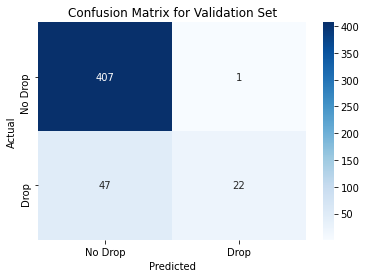

In [160]:
# Generate the confusion matrix
cm_val_3 = confusion_matrix(y_val, y_pred_val_custom_thresh_3)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6,4))
sns.heatmap(cm_val_3, annot=True, fmt='d', cmap='Blues', xticklabels=['No Drop', 'Drop'], yticklabels=['No Drop', 'Drop'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for Validation Set')
plt.show()

### Evaluate the Model on the Test Set

In [161]:
# Step 1: Predict probabilities for the test set
y_test_proba_3 = best_rf_3.predict_proba(X_test)[:, 1]  # Probability estimates for class 1

# Step 2: Apply the same custom threshold for class 1 predictions
y_pred_test_custom_thresh_3 = (y_test_proba_3 >= threshold).astype(int)

# Step 3: Evaluate model performance on the test set with the custom threshold

# Test performance
print("Test Accuracy:", accuracy_score(y_test, y_pred_test_custom_thresh_3))
print("Test Precision:", precision_score(y_test, y_pred_test_custom_thresh_3))
print("Test Recall:", recall_score(y_test, y_pred_test_custom_thresh_3))
print("\nTest Classification Report:\n", classification_report(y_test, y_pred_test_custom_thresh_3))

Test Accuracy: 0.8796680497925311
Test Precision: 1.0
Test Recall: 0.17142857142857143

Test Classification Report:
               precision    recall  f1-score   support

           0       0.88      1.00      0.93       206
           1       1.00      0.17      0.29        35

    accuracy                           0.88       241
   macro avg       0.94      0.59      0.61       241
weighted avg       0.89      0.88      0.84       241



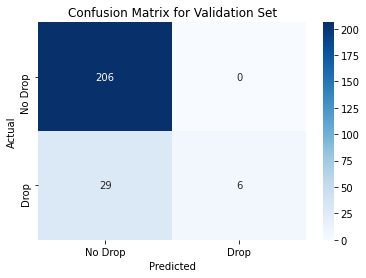

In [162]:
# Generate the confusion matrix
cm_test_3 = confusion_matrix(y_test, y_pred_test_custom_thresh_3)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6,4))
sns.heatmap(cm_test_3, annot=True, fmt='d', cmap='Blues', xticklabels=['No Drop', 'Drop'], yticklabels=['No Drop', 'Drop'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for Validation Set')
plt.show()

### Saving Predictive Model for Cluster 3

In [163]:
# Set the path to your Desktop
desktop_path = os.path.join(os.path.expanduser("~"), "Desktop/Python Works/LongShort Strategy", "best_rf_3_model.pkl")

# Save the model to the specified path
with open(desktop_path, 'wb') as file:
    pickle.dump(best_rf_3, file)

## Apply predictive models to out of sample stocks

### Application to stocks in cluster_0

In [164]:
"""Define a function to apply the selected model to each ticker belonging to a specific cluster"""

def apply_model_to_cluster(cluster_list, stocks_df, model, threshold=0.7):
    predictions = pd.DataFrame()

    for ticker in cluster_list:
        # Extract data for the ticker from the multi-index DataFrame
        try:
            ticker_df = stocks_df[ticker][['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].copy()
        except KeyError:
            print(f"Ticker {ticker} not found in the dataframe.")
            continue  # Skip tickers not found in stocks_df

        # Apply technical indicators
        ticker_df = add_technical_indicators(ticker_df)

        # Select the first 19 columns for lag and rolling statistics
        columns_to_transform = ticker_df.columns[:19]

        # Create lagged features and rolling statistics
        for lag in [20, 60]:
            for column in columns_to_transform:
                ticker_df[f'{column}_lag_{lag}'] = ticker_df[column].shift(lag)
        
        for window in [20, 60]:
            for column in columns_to_transform:
                ticker_df[f'{column}_rolling_mean_{window}'] = ticker_df[column].rolling(window=window).mean()
                ticker_df[f'{column}_rolling_std_{window}'] = ticker_df[column].rolling(window=window).std()

        # Add the day of the week as a feature
        ticker_df['day_of_week'] = ticker_df.index.dayofweek

        # Drop rows with NaN values from shifting/rolling operations
        ticker_df = ticker_df.dropna()

        # Prepare features (X) for prediction
        X = ticker_df

        # Get probability predictions for class 1
        y_proba = model.predict_proba(X)[:, 1]  # Probability estimates for class 1
        
        # Apply custom threshold for classification
        y_pred_custom_thresh = (y_proba >= threshold).astype(int)

        # Store predictions in the result DataFrame with the ticker as column name
        predictions[ticker] = pd.Series(y_pred_custom_thresh, index=X.index)
        
    return predictions

# Example usage:
# test_df = apply_model_to_cluster(test_list, sp500_data, best_rf_0)


In [165]:
# Upload ISIN-Symbols mapping file
mapping = pd.read_excel('/Users/lucadonghi/Desktop/Python Works/LongShort Strategy/long_book_ISIN.xlsx', index_col=0)
mapping.head()

,ISIN,EQY_PRIM_SECURITY_TICKER,LONG_COMP_NAME
2,US64110W1027,NTES,NetEase Inc
4,US30303M1027,META,Meta Platforms Inc
11,US9485961018,WB,Weibo Corp
14,US90184L1026,TWTR,Twitter Inc
15,US9858171054,YELP,Yelp Inc


In [166]:
# Extracting list of symbols present in the long book
long_book_symbols = mapping['EQY_PRIM_SECURITY_TICKER'].tolist()

In [167]:
# Exclude from cluster_0 the symbols used to train the model and the symbols present in the long book
cluster_0_list_short = [
    symbol for symbol in cluster_0_list 
    if symbol != cluster_0_df.iloc[0, 0] 
    and symbol not in long_book_symbols 
    and symbol not in missing_stocks # We also exclude the missing stocks
]

# Printing length of cluster_0 lists to double-check we are dropping unwanted symbols
print(f"Number of symbols in cluster_0_list: {len(cluster_0_list)}")
print(f"Number of symbols in cluster_0_list_short: {len(cluster_0_list_short)}")

Number of symbols in cluster_0_list: 239
Number of symbols in cluster_0_list_short: 228


In [168]:
# Get the list of symbols in the top level of sp500_data's multi-level columns
sp500_symbols = sp500_data.columns.get_level_values(0).unique()

# Find the intersection of cluster_0_list and sp500_symbols
symbols_in_data = [symbol for symbol in cluster_0_list_short if symbol in sp500_symbols]

# Print the results
print(f"Number of symbols in cluster_0_list_short that are present in sp500_data: {len(symbols_in_data)}")

Number of symbols in cluster_0_list_short that are present in sp500_data: 228


In [169]:
# Define the date threshold
date_threshold = '2019-06-30'

# Filter columns where there is no data (all NaN) before the threshold date
columns_with_data = [
    col for col in sp500_data.columns
    if not sp500_data.loc[:date_threshold, col].isna().all()
]

# Keep only the columns with data before the threshold date
sp500_data_filtered = sp500_data[columns_with_data]

print(f"Number of columns from original dataset: {len(sp500_data.columns.get_level_values(0).unique())}")
print(f"Number of columns retained: {len(sp500_data_filtered.columns.get_level_values(0).unique())}")

Number of columns from original dataset: 501
Number of columns retained: 490


In [170]:
# Subset the data to keep only observations from 2019-06-30 onwards
sp500_data_filtered_subset = sp500_data_filtered.loc['2019-06-30':]

# Forward-fill any missing values
sp500_data_filtered_subset.ffill(inplace=True)

# Check for remaining missing values
missing_values = sp500_data_filtered_subset.isna().sum().sum()
print(f"Number of remaining missing values after forward-fill: {missing_values}")

# Display the shape of the final subset
print(f"Subset DataFrame shape: {sp500_data_filtered_subset.shape}")


Number of remaining missing values after forward-fill: 0
Subset DataFrame shape: (1302, 2940)


In [281]:
# Select a threshold for the application of the four predictive models
model_threshold = 0.6

In [282]:
# Apply the pre-trained machine learning model to stocks present in cluster_0
cluster_0_preds_df = apply_model_to_cluster(cluster_0_list_short, sp500_data_filtered_subset, best_rf_0, threshold=model_threshold)

Ticker CARR not found in the dataframe.
Ticker OTIS not found in the dataframe.


In [283]:
cluster_0_preds_df.head()

,STX,ALL,MAA,CMCSA,DRI,STT,HSIC,CB,AIG,LULU,...,PNR,HCA,WELL,CFG,TJX,CE,GS,KEY,O,ZBH
Date,,,,,,,,,,,,,,,,,,,,,
2019-11-06,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-11-07,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-11-08,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-11-11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-11-12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


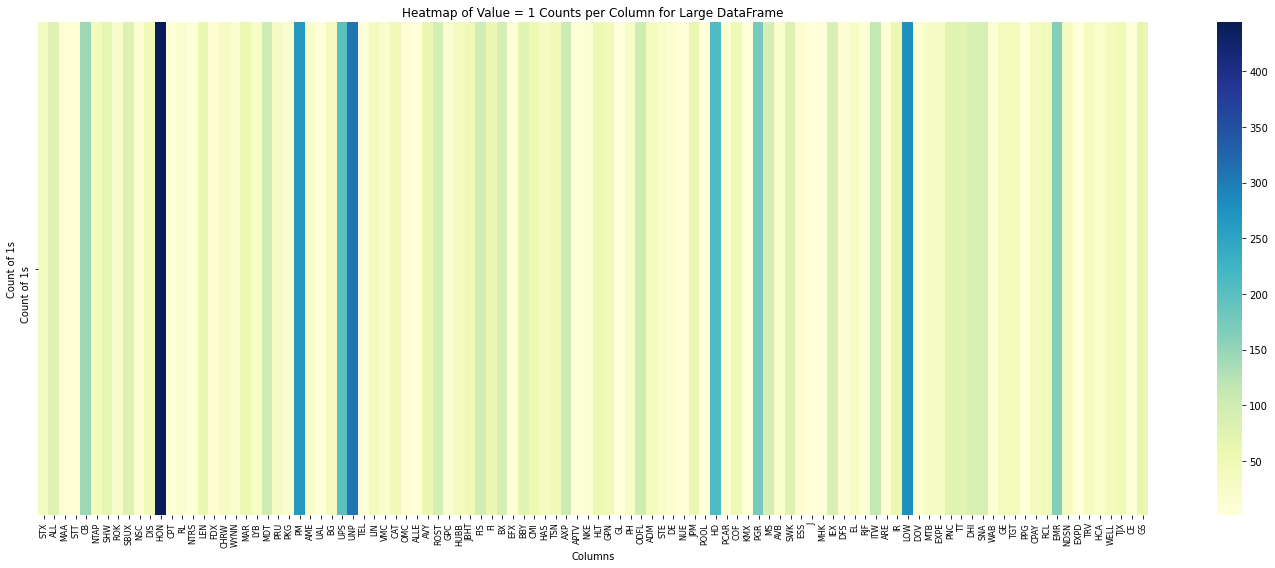

In [284]:
# Fixing the code by passing the appropriate data structure to the heatmap

# Count the number of observations with value = 1 for each column
value_counts_0 = cluster_0_preds_df.apply(lambda x: (x == 1).sum())

# Selecting columns with at least one occurrence of the value 1
columns_with_one_0 = value_counts_0[value_counts_0 > 0]

# Visualizing with a heatmap for large number of columns
plt.figure(figsize=(20, 8))
sns.heatmap(columns_with_one_0.values.reshape(1, -1), annot=False, cmap="YlGnBu", 
            cbar=True, xticklabels=columns_with_one_0.index, yticklabels=['Count of 1s'])

# Adjusting x-axis for readability
plt.xticks(rotation=90, fontsize=8)
plt.title('Heatmap of Value = 1 Counts per Column for Large DataFrame')
plt.xlabel('Columns')
plt.ylabel('Count of 1s')
plt.tight_layout()
plt.show()

### Application to stocks in cluster_1

In [285]:
# Exclude from cluster_1 the symbols used to train the model and the symbols present in the long book
cluster_1_list_short = [
    symbol for symbol in cluster_1_list 
    if symbol != cluster_1_df.iloc[0, 0] 
    and symbol not in long_book_symbols 
    and symbol not in missing_stocks # We also exclude the missing stocks
]

# Printing length of cluster_1 lists to double-check we are dropping unwanted symbols
print(f"Number of symbols in cluster_1_list: {len(cluster_1_list)}")
print(f"Number of symbols in cluster_1_list_short: {len(cluster_1_list_short)}")

Number of symbols in cluster_1_list: 101
Number of symbols in cluster_1_list_short: 87


In [286]:
# Get the list of symbols in the top level of sp500_data's multi-level columns
sp500_symbols = sp500_data.columns.get_level_values(0).unique()

# Find the intersection of cluster_1_list and sp500_symbols
symbols_in_data = [symbol for symbol in cluster_1_list_short if symbol in sp500_symbols]

# Print the results
print(f"Number of symbols in cluster_1_list_short that are present in sp500_data: {len(symbols_in_data)}")

Number of symbols in cluster_1_list_short that are present in sp500_data: 87


In [287]:
# Apply the pre-trained machine learning model to stocks present in cluster_0
cluster_1_preds_df = apply_model_to_cluster(cluster_1_list_short, sp500_data_filtered_subset, best_rf_1, threshold=model_threshold)

Ticker PLTR not found in the dataframe.


In [288]:
cluster_1_preds_df.head()

,QRVO,NXPI,PAYC,CTLT,FDS,EW,MSCI,RMD,ACN,AAPL,...,TRMB,ENPH,ANET,DAY,EBAY,MRNA,WST,ROP,TYL,CRL
Date,,,,,,,,,,,,,,,,,,,,,
2019-11-06,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-11-07,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-11-08,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-11-11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-11-12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


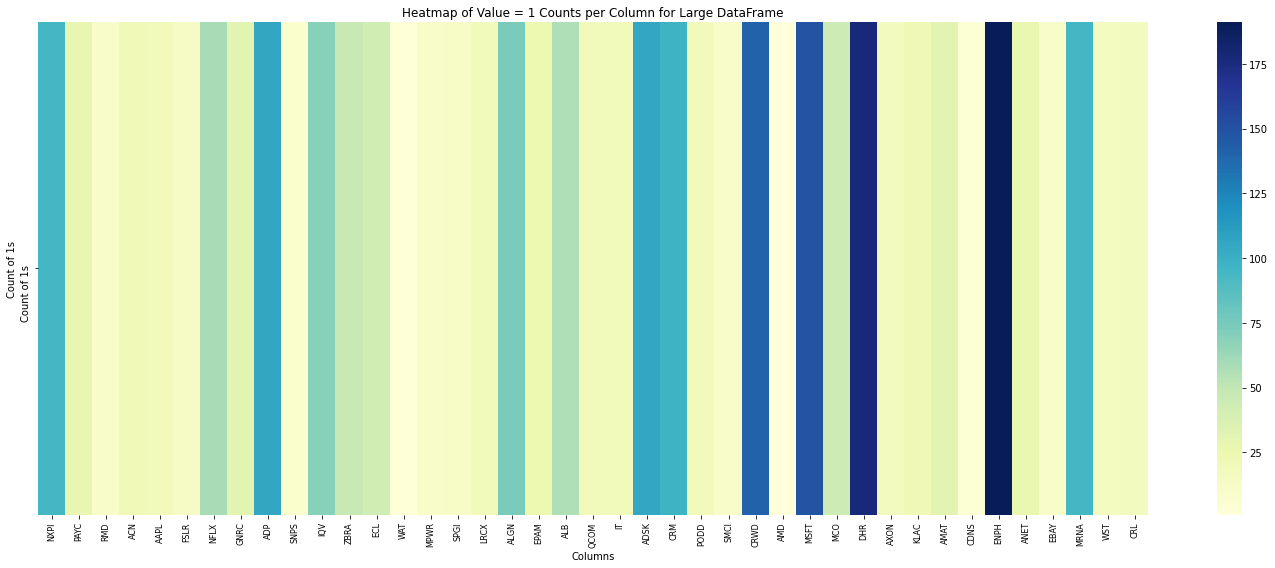

In [289]:
# Fixing the code by passing the appropriate data structure to the heatmap

# Count the number of observations with value = 1 for each column
value_counts_1 = cluster_1_preds_df.apply(lambda x: (x == 1).sum())

# Selecting columns with at least one occurrence of the value 1
columns_with_one_1 = value_counts_1[value_counts_1 > 0]

# Visualizing with a heatmap for large number of columns
plt.figure(figsize=(20, 8))
sns.heatmap(columns_with_one_1.values.reshape(1, -1), annot=False, cmap="YlGnBu", 
            cbar=True, xticklabels=columns_with_one_1.index, yticklabels=['Count of 1s'])

# Adjusting x-axis for readability
plt.xticks(rotation=90, fontsize=8)
plt.title('Heatmap of Value = 1 Counts per Column for Large DataFrame')
plt.xlabel('Columns')
plt.ylabel('Count of 1s')
plt.tight_layout()
plt.show()

### Application to stocks in cluster_2

In [290]:
# Exclude from cluster_2 the symbols used to train the model and the symbols present in the long book
cluster_2_list_short = [
    symbol for symbol in cluster_2_list 
    if symbol != cluster_2_df.iloc[0, 0] 
    and symbol not in long_book_symbols 
    and symbol not in missing_stocks # We also exclude the missing stocks
]

# Printing length of cluster_2 lists to double-check we are dropping unwanted symbols
print(f"Number of symbols in cluster_2_list: {len(cluster_2_list)}")
print(f"Number of symbols in cluster_2_list_short: {len(cluster_2_list_short)}")

Number of symbols in cluster_2_list: 24
Number of symbols in cluster_2_list_short: 23


In [291]:
# Get the list of symbols in the top level of sp500_data's multi-level columns
sp500_symbols = sp500_data.columns.get_level_values(0).unique()

# Find the intersection of cluster_1_list and sp500_symbols
symbols_in_data = [symbol for symbol in cluster_2_list_short if symbol in sp500_symbols]

# Print the results
print(f"Number of symbols in cluster_2_list_short that are present in sp500_data: {len(symbols_in_data)}")

Number of symbols in cluster_2_list_short that are present in sp500_data: 23


In [292]:
# Apply the pre-trained machine learning model to stocks present in cluster_0
cluster_2_preds_df = apply_model_to_cluster(cluster_2_list_short, sp500_data_filtered_subset, best_rf_2, threshold=model_threshold)

In [293]:
cluster_2_preds_df.head()

,BKR,WMB,HES,SLB,EQT,PSX,KMI,CVX,MPC,VLO,...,TRGP,OXY,COP,MOS,MRO,CF,APA,XOM,FANG,CTRA
Date,,,,,,,,,,,,,,,,,,,,,
2019-11-06,0,0,1,0,0,1,0,1,1,1,...,0,0,1,0,0,0,0,1,1,0
2019-11-07,0,0,1,0,0,1,0,1,1,1,...,0,0,1,0,0,0,0,1,1,0
2019-11-08,0,0,1,0,0,1,0,1,1,1,...,0,0,1,0,0,0,0,1,1,0
2019-11-11,0,0,1,0,0,1,0,1,1,1,...,0,0,1,0,0,0,0,1,1,0
2019-11-12,0,0,1,0,0,1,0,1,1,1,...,0,0,1,0,0,0,0,1,1,0


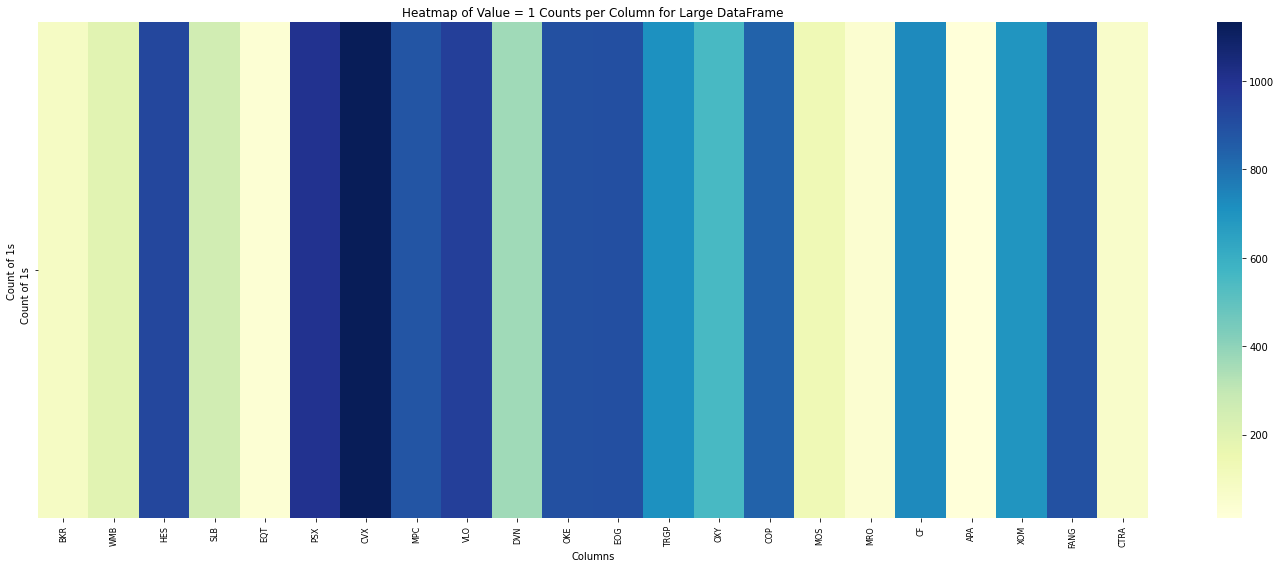

In [294]:
# Fixing the code by passing the appropriate data structure to the heatmap

# Count the number of observations with value = 1 for each column
value_counts_2 = cluster_2_preds_df.apply(lambda x: (x == 1).sum())

# Selecting columns with at least one occurrence of the value 1
columns_with_one_2 = value_counts_2[value_counts_2 > 0]

# Visualizing with a heatmap for large number of columns
plt.figure(figsize=(20, 8))
sns.heatmap(columns_with_one_2.values.reshape(1, -1), annot=False, cmap="YlGnBu", 
            cbar=True, xticklabels=columns_with_one_2.index, yticklabels=['Count of 1s'])

# Adjusting x-axis for readability
plt.xticks(rotation=90, fontsize=8)
plt.title('Heatmap of Value = 1 Counts per Column for Large DataFrame')
plt.xlabel('Columns')
plt.ylabel('Count of 1s')
plt.tight_layout()
plt.show()

### Application to stocks in cluster_3

In [295]:
# Exclude from cluster_3 the symbols used to train the model and the symbols present in the long book
cluster_3_list_short = [
    symbol for symbol in cluster_3_list 
    if symbol != cluster_3_df.iloc[0, 0] 
    and symbol not in long_book_symbols 
    and symbol not in missing_stocks # We also exclude the missing stocks
]

# Printing length of cluster_3 lists to double-check we are dropping unwanted symbols
print(f"Number of symbols in cluster_2_list: {len(cluster_3_list)}")
print(f"Number of symbols in cluster_2_list_short: {len(cluster_3_list_short)}")

Number of symbols in cluster_2_list: 129
Number of symbols in cluster_2_list_short: 125


In [296]:
# Get the list of symbols in the top level of sp500_data's multi-level columns
sp500_symbols = sp500_data.columns.get_level_values(0).unique()

# Find the intersection of cluster_1_list and sp500_symbols
symbols_in_data = [symbol for symbol in cluster_3_list_short if symbol in sp500_symbols]

# Print the results
print(f"Number of symbols in cluster_3_list_short that are present in sp500_data: {len(symbols_in_data)}")

Number of symbols in cluster_3_list_short that are present in sp500_data: 125


In [297]:
# Apply the pre-trained machine learning model to stocks present in cluster_3
cluster_3_preds_df = apply_model_to_cluster(cluster_3_list_short, sp500_data_filtered_subset, best_rf_3, threshold=model_threshold)

In [298]:
cluster_3_preds_df.head()

,DLR,PEP,YUM,CI,BMY,MKC,MKTX,DG,CLX,D,...,CMS,STZ,MCD,ETR,LHX,LNT,PLD,CL,WMT,KR
Date,,,,,,,,,,,,,,,,,,,,,
2019-11-06,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-11-07,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-11-08,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-11-11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-11-12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


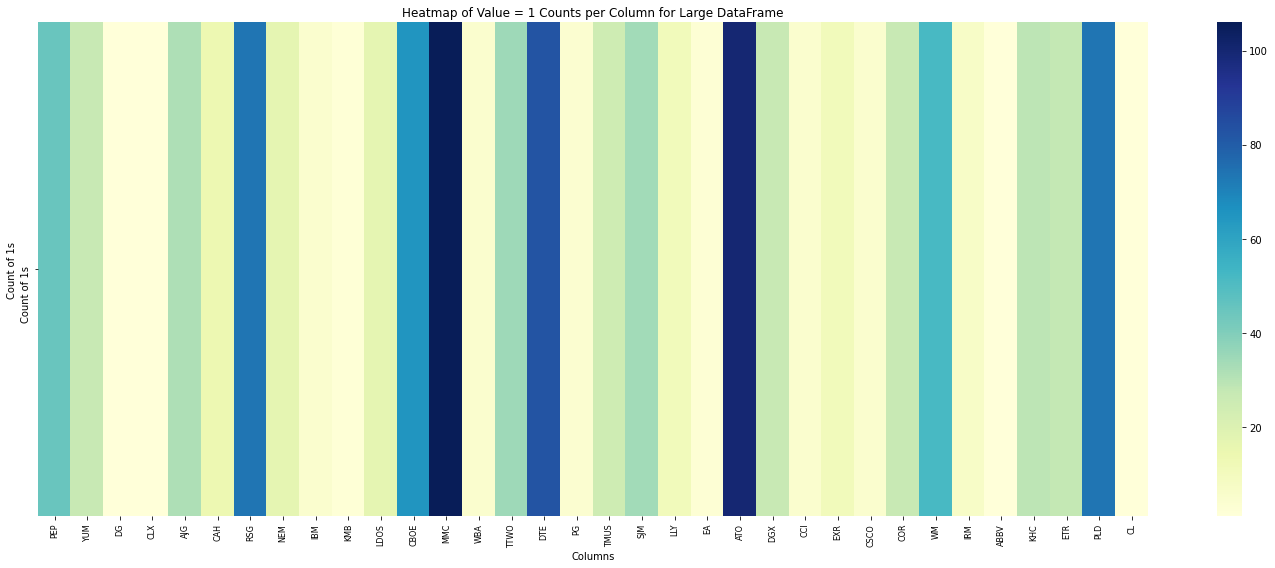

In [299]:
# Fixing the code by passing the appropriate data structure to the heatmap

# Count the number of observations with value = 1 for each column
value_counts_3 = cluster_3_preds_df.apply(lambda x: (x == 1).sum())

# Selecting columns with at least one occurrence of the value 1
columns_with_one_3 = value_counts_3[value_counts_3 > 0]

# Visualizing with a heatmap for large number of columns
plt.figure(figsize=(20, 8))
sns.heatmap(columns_with_one_3.values.reshape(1, -1), annot=False, cmap="YlGnBu", 
            cbar=True, xticklabels=columns_with_one_3.index, yticklabels=['Count of 1s'])

# Adjusting x-axis for readability
plt.xticks(rotation=90, fontsize=8)
plt.title('Heatmap of Value = 1 Counts per Column for Large DataFrame')
plt.xlabel('Columns')
plt.ylabel('Count of 1s')
plt.tight_layout()
plt.show()

## Merging predictions

In [300]:
# Assuming the dataframes are already defined
merged_df = pd.concat([cluster_0_preds_df, cluster_1_preds_df, cluster_2_preds_df, cluster_3_preds_df], axis=1)

# Display the merged dataframe
merged_df.head()


,STX,ALL,MAA,CMCSA,DRI,STT,HSIC,CB,AIG,LULU,...,CMS,STZ,MCD,ETR,LHX,LNT,PLD,CL,WMT,KR
Date,,,,,,,,,,,,,,,,,,,,,
2019-11-06,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-11-07,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-11-08,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-11-11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-11-12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [301]:
# Printing info about newly merged df
merged_df.describe()

,STX,ALL,MAA,CMCSA,DRI,STT,HSIC,CB,AIG,LULU,...,CMS,STZ,MCD,ETR,LHX,LNT,PLD,CL,WMT,KR
count,1212.000000,1212.000000,1212.000000,1212.0,1212.0,1212.000000,1212.0,1212.000000,1212.0,1212.0,...,1212.0,1212.0,1212.0,1212.000000,1212.0,1212.0,1212.000000,1212.000000,1212.0,1212.0
mean,0.028878,0.064356,0.009076,0.0,0.0,0.004125,0.0,0.119637,0.0,0.0,...,0.0,0.0,0.0,0.023102,0.0,0.0,0.061056,0.000825,0.0,0.0
std,0.167532,0.245488,0.094873,0.0,0.0,0.064123,0.0,0.324670,0.0,0.0,...,0.0,0.0,0.0,0.150290,0.0,0.0,0.239532,0.028724,0.0,0.0
min,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
25%,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
50%,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
75%,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
max,1.000000,1.000000,1.000000,0.0,0.0,1.000000,0.0,1.000000,0.0,0.0,...,0.0,0.0,0.0,1.000000,0.0,0.0,1.000000,1.000000,0.0,0.0


In [302]:
# Checking if there are NaN values
has_nan = merged_df.isna().any().any()
print("NaN values present:", has_nan)

NaN values present: False


## Short book backtest

In [303]:
short_fcst = merged_df.loc['2020-01-02':]
short_fcst.head()

,STX,ALL,MAA,CMCSA,DRI,STT,HSIC,CB,AIG,LULU,...,CMS,STZ,MCD,ETR,LHX,LNT,PLD,CL,WMT,KR
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-03,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-06,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-07,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-08,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [304]:
# Subset the DataFrame for rows starting from 02.01.2020
subset_data = sp500_data.loc['2020-01-02':]

# Select only the "Open" column for all stock tickers
open_data = subset_data.xs('Open', level=1, axis=1)

# Retain only the columns (tickers) that are in short_fcst
filtered_open_data = open_data.loc[:, open_data.columns.isin(short_fcst.columns)]

filtered_open_data.head()

,STX,DLR,PEP,ALL,MAA,YUM,CI,CMCSA,QRVO,BKR,...,CFG,TJX,CL,CE,GS,KEY,O,WMT,ZBH,KR
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,59.810001,120.010002,136.869995,112.970001,132.350006,100.900002,205.389999,45.360001,117.260002,25.680000,...,40.720001,61.330002,68.839996,123.900002,231.000000,20.360001,71.560081,39.619999,145.611649,29.030001
2020-01-03,59.860001,117.230003,135.460007,111.839996,129.089996,101.419998,202.009995,44.830002,114.059998,25.950001,...,40.000000,61.049999,67.839996,120.029999,231.600006,19.920000,69.951553,39.423332,143.126221,28.480000
2020-01-06,58.400002,119.470001,135.300003,112.339996,130.740005,101.430000,202.000000,44.660000,110.830002,25.719999,...,39.799999,61.200001,68.080002,118.919998,229.929993,19.620001,71.366280,39.133331,144.242722,28.570000
2020-01-07,58.500000,118.379997,136.000000,112.680000,130.509995,101.750000,206.179993,44.250000,111.279999,25.260000,...,39.529999,61.230000,68.459999,117.129997,235.000000,19.580000,72.383720,39.086666,144.223297,28.719999
2020-01-08,58.900002,117.839996,134.460007,112.550003,129.289993,100.470001,207.929993,44.939999,111.540001,25.020000,...,39.490002,61.730000,67.800003,117.750000,235.679993,19.480000,71.976746,38.766666,144.029129,28.709999


In [305]:
# Checking shape matches for the two dataframes
print(short_fcst.shape)
print(filtered_open_data.shape)

(1174, 460)
(1174, 460)


In [306]:
# Calculate returns on filtered_open_data
filtered_open_rets = filtered_open_data.pct_change().fillna(0)
print(filtered_open_rets.shape)

(1174, 460)


In [330]:
# Initialize the pnl DataFrame to store profits and losses for each stock
dates = filtered_open_rets.index
stocks = filtered_open_rets.columns
pnl = pd.DataFrame(0.0, index=dates, columns=stocks)

# Parameters
holding_period = 20  # Maximum holding period for short positions
loss_threshold = -0.04  # 4% cumulative loss threshold
max_weight = 0.1  # Maximum weight per stock if < 10 positions

# Initialize a DataFrame to track open positions
positions = pd.DataFrame(0, index=dates, columns=stocks)
cumulative_returns = pd.DataFrame(0.0, index=dates, columns=stocks)

# Backtesting loop
for t in range(1, len(dates)):
    current_date = dates[t]
    previous_date = dates[t - 1]

    # Get short sell recommendations from the previous day
    signals_today = short_fcst.loc[previous_date]

    # Update existing positions and calculate PnL
    for stock in stocks:
        if positions.loc[previous_date, stock] > 0:  # If a position is already open
            # Update cumulative returns
            cumulative_returns.loc[current_date, stock] = (
                cumulative_returns.loc[previous_date, stock] + filtered_open_rets.loc[current_date, stock]
            )

            # Check if the loss threshold is breached or holding period exceeded
            if cumulative_returns.loc[current_date, stock] <= loss_threshold or \
               positions.loc[previous_date, stock] >= holding_period:
                positions.loc[current_date, stock] = 0  # Close the position
                pnl.loc[current_date, stock] = (
                    cumulative_returns.loc[current_date, stock] * -1  # Short position PnL
                )
                cumulative_returns.loc[current_date, stock] = 0  # Reset cumulative returns
            else:
                # Extend the holding period
                positions.loc[current_date, stock] = positions.loc[previous_date, stock] + 1

    # Open new positions based on signals
    for stock in stocks:
        if signals_today[stock] == 1 and positions.loc[previous_date, stock] == 0:
            positions.loc[current_date, stock] = 1  # Open a new position
            cumulative_returns.loc[current_date, stock] = filtered_open_rets.loc[current_date, stock]

# Calculate the strategy PnL with weights
def calculate_strategy_pnl(pnl, positions):
    strategy_pnl = pd.Series(0.0, index=dates)

    for t in range(len(dates)):
        active_positions = positions.loc[dates[t]].sum()

        if active_positions == 0:
            continue

        weight = min(max_weight, 1 / active_positions)
        daily_pnl = pnl.loc[dates[t]].sum()

        strategy_pnl[dates[t]] = daily_pnl * weight

    return strategy_pnl

strategy_pnl = calculate_strategy_pnl(pnl, positions)

# Display the results
final_pnl = strategy_pnl.sum()
print("Final Strategy PnL:", final_pnl)

Final Strategy PnL: 0.07732050672298907


Start date,2020-01-02
End date,2024-08-30
Total months,55
,Backtest
Annual return,1.6%
Cumulative returns,7.7%
Annual volatility,3.8%
Sharpe ratio,0.44
Calmar ratio,0.23
Stability,0.06
Max drawdown,-7.0%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,6.95,2020-04-20,2022-04-21,NaT,NaN
1,0.17,2020-02-03,2020-02-11,2020-02-25,17
2,0.07,2020-03-12,2020-03-13,2020-03-16,3
3,0.00,2020-01-02,2020-01-02,2020-01-02,1
4,0.00,2020-01-02,2020-01-02,2020-01-02,1


Stress Events,mean,min,max
New Normal,0.01%,-3.06%,4.20%


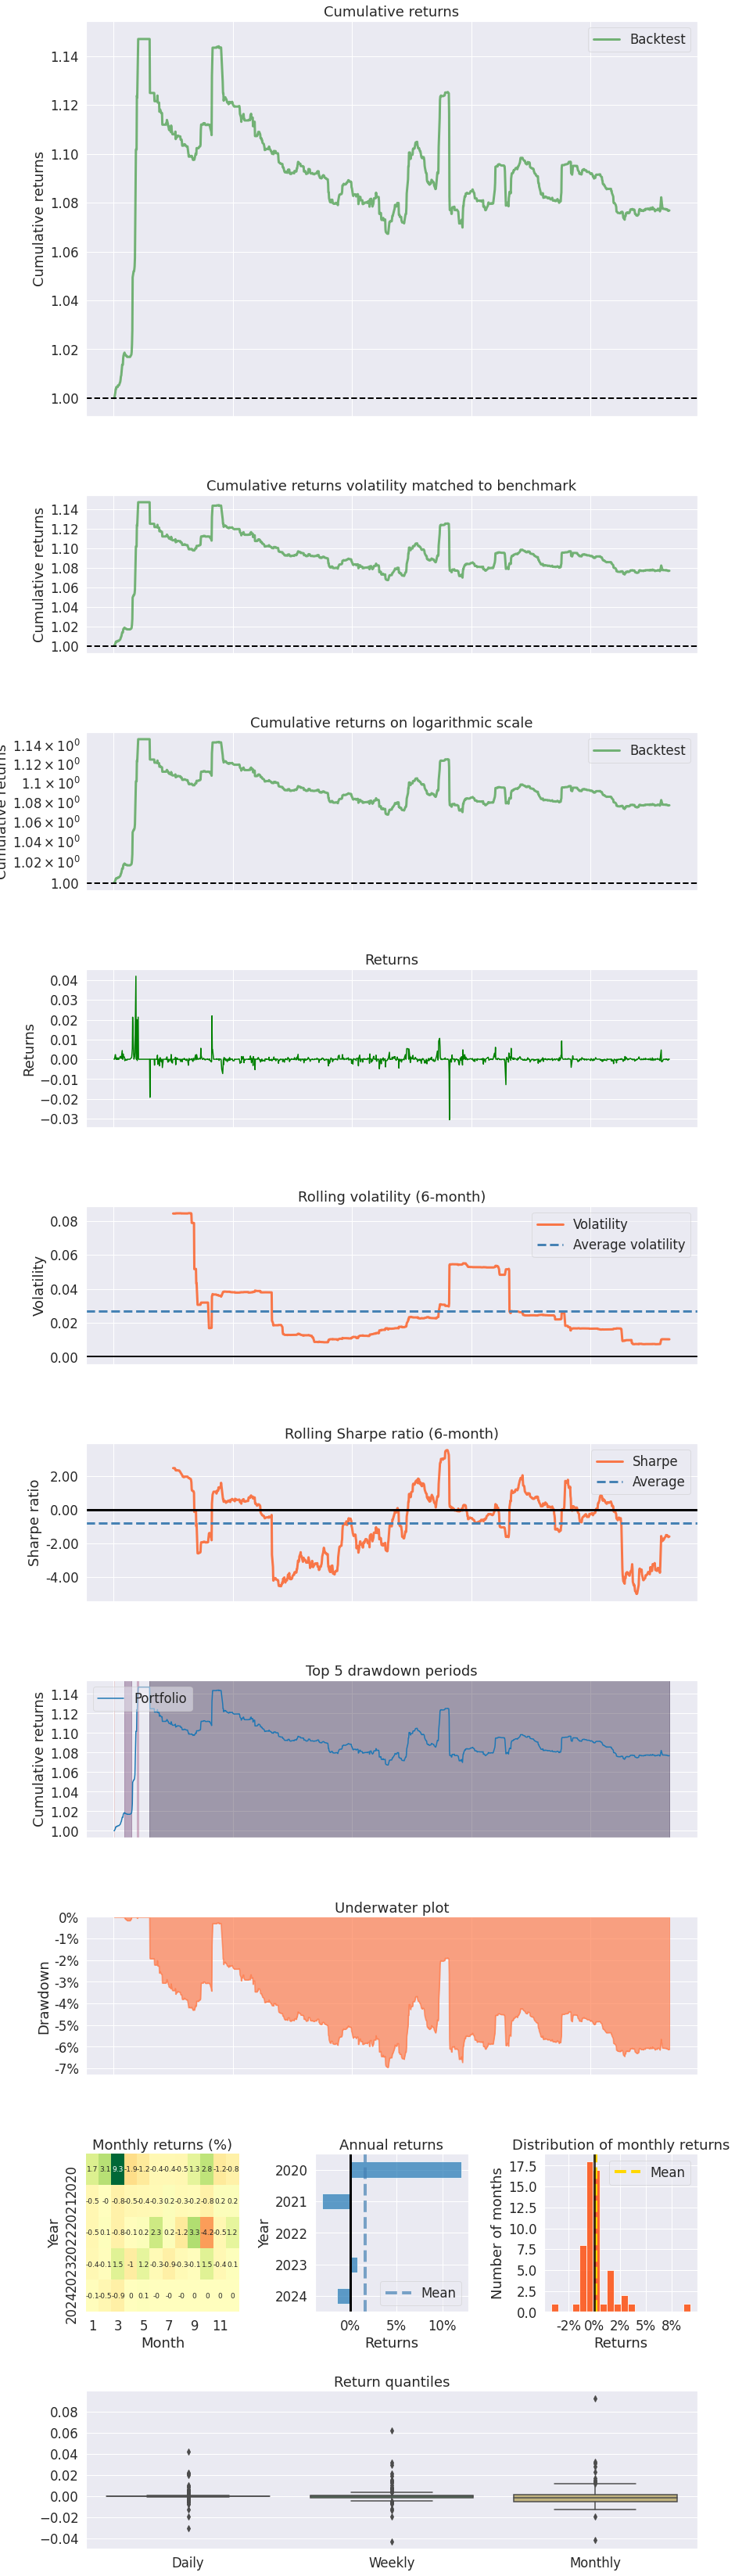

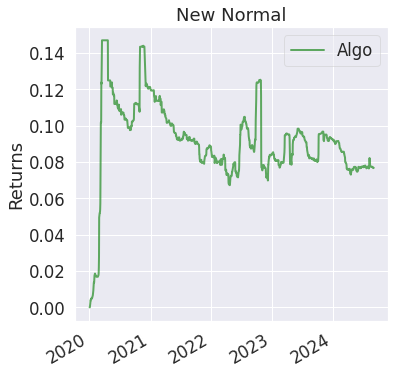

In [331]:
pf.create_full_tear_sheet(strategy_pnl, 
                          benchmark_rets=None)

## Long/Short Strategy

In [332]:
# Checking length of long and short strategies returns
print(len(hrp_returns))
print(len(strategy_pnl))

1217
1174


In [347]:
# Combine hrp_returns and strategy_pnl into ls_strategy
hrp_weight = 1
strategy_weight = 0.5

# Ensure hrp_returns and strategy_pnl are aligned on dates and fill missing values
strategy_pnl = strategy_pnl.reindex(hrp_returns.index, fill_value=0)

ls_strategy = hrp_returns * hrp_weight + strategy_pnl * strategy_weight

Start date,2020-01-02
End date,2024-08-30
Total months,57
,Backtest
Annual return,12.2%
Cumulative returns,74.2%
Annual volatility,25.3%
Sharpe ratio,0.58
Calmar ratio,0.35
Stability,0.10
Max drawdown,-35.3%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,35.27,2021-11-12,2022-06-16,NaT,NaN
1,31.25,2020-02-19,2020-03-18,2020-05-08,58
2,14.07,2021-02-09,2021-03-08,2021-06-25,99
3,10.26,2020-09-02,2020-09-24,2020-10-09,28
4,7.74,2021-09-02,2021-10-04,2021-11-04,46


Stress Events,mean,min,max
New Normal,0.06%,-10.59%,10.56%


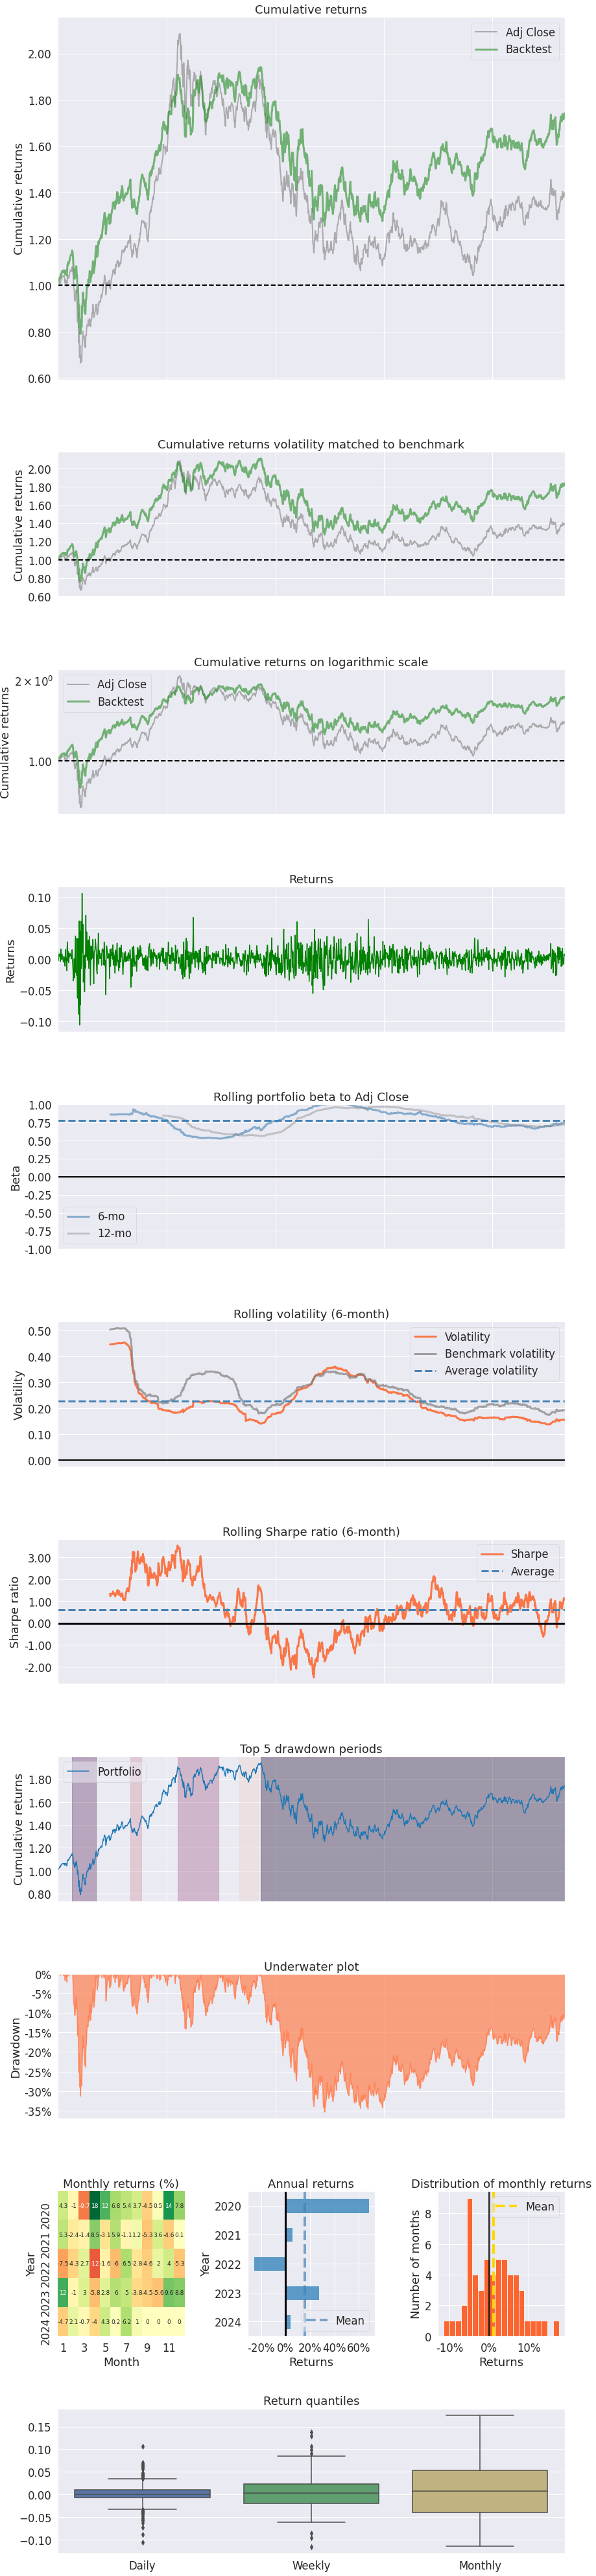

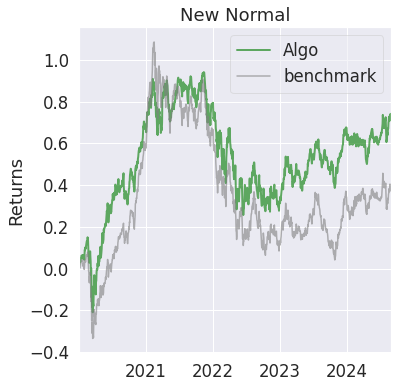

In [348]:
pf.create_full_tear_sheet(ls_strategy, 
                          benchmark_rets=komp_rets)

## Comparing strategies

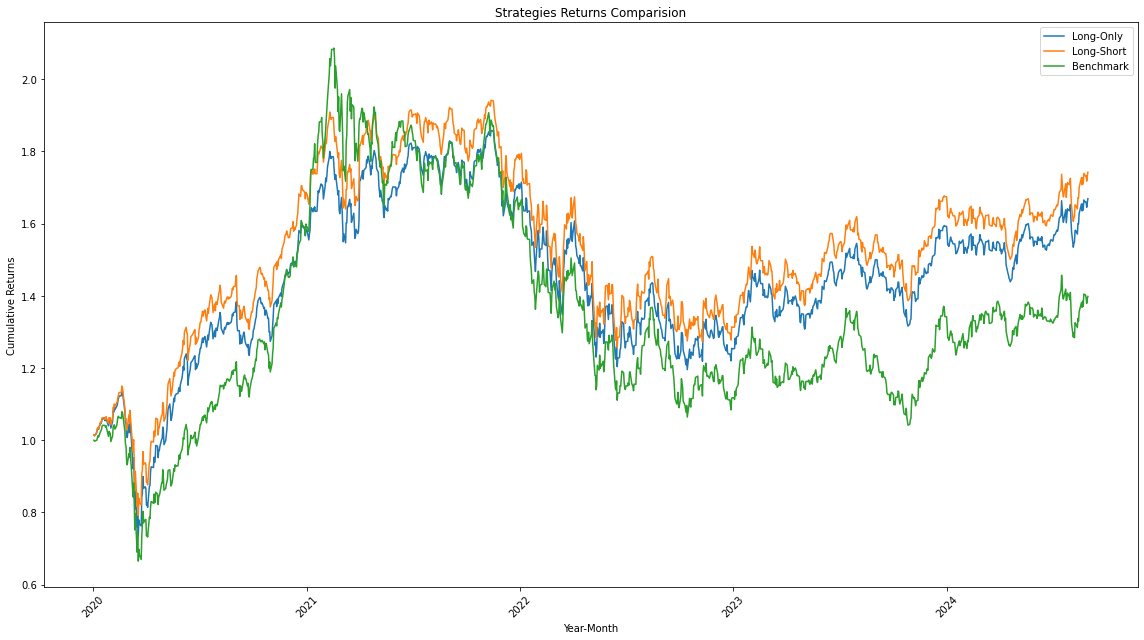

In [349]:
# Long-only strategy cumulative returns
long_cum_rets = (1 + hrp_returns).cumprod()

# Long-Short strategy cumulative returns
ls_cum_rets = (1 + ls_strategy).cumprod()

# Benchmark cumulative returns
bmk_cum_rets = (1 + komp_rets).cumprod()

# Plot size
plt.figure(figsize=(16, 9))

# Plot title
plt.title('Strategies Returns Comparision')

plt.tick_params(axis='x', rotation=45)

# Plot labels
plt.xlabel('Year-Month')
plt.ylabel('Cumulative Returns')
plt.plot(long_cum_rets, label='Long-Only')
plt.plot(ls_cum_rets, label='Long-Short')
plt.plot(bmk_cum_rets, label='Benchmark')

# Plot Legend
plt.legend()

# Display Plot
plt.tight_layout()
plt.show()

In [350]:
def portfolio_performance(portfolio_returns):

    # Portfolio returns
    portfolio_cum = (1 + portfolio_returns).cumprod()
    total_return = portfolio_cum.iloc[-1] / portfolio_cum.iloc[0] - 1

    # Annualised performance
    annualised_performance = ((portfolio_cum.iloc[-1] / portfolio_cum.iloc[0])
                              ** (252 / len(portfolio_returns)) - 1) * 100

    # Annualised standard deviation
    annualised_std = (portfolio_returns.std() * np.sqrt(252))*100
    
    # Drawdown calculations
    # Calculate the running maximum
    running_max = np.maximum.accumulate(portfolio_cum.dropna())

    # Ensure the value never drops below 1
    running_max[running_max < 1] = 1

    # Calculate the percentage drawdown
    running_drawdown = 100 * ((portfolio_cum) / running_max - 1)

    # Calculate the maximum drawdown
    max_drawdown = running_drawdown.min()

    # Calculate the return to max. drawdown ratio
    return_to_MDD_ratio = annualised_performance / max_drawdown

    # Sharpe Ratio
    mv = portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(252)

    # Print the performance metrics
    performance_metrics = pd.DataFrame(
        {'Portfolio returns (%)': round(100 * total_return, 2), 'MV ratio': round(mv, 2),
         'Annualised returns (CAGR) (%)': round(annualised_performance, 2),
         'Annualised Std. Dev. (%)': round(annualised_std, 2),
         'Maximum drawdown (MDD) (%)': round(max_drawdown, 2), 'Return-to-MDD ratio': abs(round(return_to_MDD_ratio, 2))},
        index=['Performance Metrics'])
    
    return performance_metrics

In [351]:
# Performance metrics of Long-Only Portfolio
performance_metrics_long = portfolio_performance(hrp_returns)

performance_metrics_long.rename(
    index={'Performance Metrics': 'Long-Only'}, inplace=True
)

# Performance metrics of Long-Short Portfolio
performance_metrics_ls = portfolio_performance(ls_strategy)

performance_metrics_ls.rename(
    index={'Performance Metrics': 'Long-Short'}, inplace=True
)

# Performance metrics of Benchmark
performance_metrics_bmk = portfolio_performance(komp_rets)

performance_metrics_bmk.rename(
    index={'Performance Metrics': 'Benchmark'}, inplace=True
)

pd.concat([performance_metrics_long, 
           performance_metrics_ls, 
           performance_metrics_bmk])

,Portfolio returns (%),MV ratio,Annualised returns (CAGR) (%),Annualised Std. Dev. (%),Maximum drawdown (MDD) (%),Return-to-MDD ratio
Long-Only,64.46,0.54,10.85,25.67,-35.66,0.30
Long-Short,71.70,0.58,11.84,25.34,-35.27,0.34
Benchmark,39.81,0.39,7.19,29.02,-50.06,0.14
